In [3]:
import argparse

import azureml.core
from azureml.core import Experiment,Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import TensorFlow
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from collections import defaultdict, Counter
import cv2
import glob
from imblearn.over_sampling import RandomOverSampler
import json
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import genfromtxt, isnan
from operator import concat
import os
import pandas as pd
import pickle
from PIL import Image, ImageFilter
#from pycocotools.coco import COCO
#import pydot
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score, roc_curve
from sklearn.svm import SVC,LinearSVC
from sklearn.utils import check_random_state

import shutil
import tensorflow as tf
from time import time
import traceback
import timeit
import urllib.request
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import random
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours 
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
import seaborn as sns
import umap.umap_ as umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from skmultilearn.model_selection import iterative_train_test_split
np.set_printoptions(threshold=np.inf)
import re
from ast import literal_eval

Using TensorFlow backend.


In [185]:
print(azureml.core.VERSION)

'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="9bce0414-e6b9-4c79-b146-74018a4b09ac")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_classification")
workspace_region = os.getenv("WORKSPACE_REGION", default="westeurope")
'''
'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="3e9a2408-19d1-4ca2-bb63-339d47d3baaa")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_back-up")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus")
'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="e8d26bef-c7d5-4ea0-a7e4-22fa5c586564")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="multi-label_classification_ent")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except Exception as e:
    print(e)
    print("Workspace not accessible. Change your parameters or create a new workspace below")
    
cpu_cluster_name = "cpuclusterDs4"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpucluster")
except ComputeTargetException:
    print("Creating new cpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_DS4_v2", #Standard_D2_v2
                                                           min_nodes=0,
                                                           max_nodes=4)

    # Create the cluster with the specified name and configuration
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
    # Wait for the cluster to complete, show the output log
    cpu_cluster.wait_for_completion(show_output=True)

gpu_cluster_name = "gpuclusterNC12"

# Verify that cluster does not exist already
try:
    gpu_cluster = ComputeTarget(workspace=ws, name=gpu_cluster_name)
    print("Found existing gpu cluster")
except ComputeTargetException:
    print("Creating new gpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_NC12",
                                                           min_nodes=0,
                                                           max_nodes=4)
    # Create the cluster with the specified name and configuration
    gpu_cluster = ComputeTarget.create(ws, gpu_cluster_name, compute_config)

    # Wait for the cluster to complete, show the output log
    gpu_cluster.wait_for_completion(show_output=True)


1.0.17
Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json
Workspace configuration succeeded. Skip the workspace creation steps below
Found existing cpucluster
Found existing gpu cluster


In [186]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json


In [199]:
experiment_name = 'SVM_RF_TM'
exp = Experiment(workspace=ws, name=experiment_name)

In [200]:
# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpuclusterDs4")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "Standard_DS4_v2")#"Standard_DS4_v2") #"STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. cpuclusterDs4


In [189]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
#ds.upload(src_dir='./data', target_path='data', overwrite=False, show_progress=True)

AzureBlob multilabstoragesttaiwwx azureml-blobstore-77b5704a-b7d1-4413-b1a8-b504fd99b2d0


In [166]:
script_folder = './coco-multi-label'
os.makedirs(script_folder, exist_ok=True)

In [ ]:
with open("data/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)

with open("data/annotations/instances_val2014.json") as read_file:
    val = json.load(read_file)
'''
with open("data/annotations/instances_train2014.json") as read_file:
    instances = json.load(read_file)
with open("data/annotations/person_keypoints_train2014.json") as read_file:
    keypoints = json.load(read_file)
'''

In [ ]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
val_images = val["images"]
train_annotations = train["annotations"]
val_annotations = val["annotations"]

In [9]:
train_categories = np.zeros(100, dtype=object)
val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
itemsets_val = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
for annotation in val_annotations:
    val_categories[annotation['category_id']] += 1
    itemsets_val[annotation['image_id']].append(annotation['category_id'])
unique_itemsets_val = []
for entry in itemsets_val:
    if(entry not in unique_itemsets_val):
        unique_itemsets_val.append(entry)
print(len(unique_itemsets_val))
train_categories = train_categories[train_categories != 0]
val_categories = val_categories[val_categories != 0]

82081
40137


Number of images in 2014 train: 82783
Number of images in 2014 val: 40504

Number of annotations in 2014 train: 604907
Number of annotations in 2014 val: 291875

Number of annotations/image in 2014 train: 7.307140354903785
Number of annotations/image in 2014 val: 7.206078412008691

Label density in 2014 train: 0.0913392544362973
Label density in 2014 val: 0.09007598015010863
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


1person: 185316
2bicycle: 4955
3car: 30785
4motorcycle: 6021
5airplane: 3833
6bus: 4327
7train: 3159
8truck: 7050
9boat: 7590
10traffic light: 9159
11fire hydrant: 1316
13stop sign: 1372
14parking meter: 833
15bench: 6751
16bird: 7290
17cat: 3301
18dog: 3774
19horse: 4666
20sheep: 6654
21cow: 5686
22elephant: 3905
23bear: 903
24zebra: 3685
25giraffe: 3596
27backpack: 6200
28umbrella: 7865
31handbag: 8778
32tie: 4497
33suitcase: 4251
34frisbee: 1862
35skis: 4698
36snowboard: 1960
37sports ball: 4392
38kite: 6560
39baseball bat: 2400
40baseball 

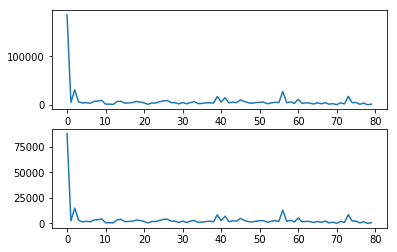


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]



10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]




In [10]:
print("Number of images in 2014 train: "+str(len(train_images)))
print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")

print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
for i in range(0, len(val_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(val_categories[i]))
    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
plt.subplot(212)
plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
#print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
#print(val_categories[-10:])

In [ ]:
corrected_ids = [0,1,2,3,4,5,6,7,8,9,10,11,0,12,13,14,15,16,17,18,19,20,21,22,23,24,0,25,26,0,0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,0,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,0,61,0,0,62,0,63,64,65,66,67,68,69,70,71,72,73,0,74,75,76,77,78,79,80]
print(corrected_ids[0])

In [11]:
def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    #img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations

def getPicture(image_id, path):
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    image_resized = resize(image, (104, 107), anti_aliasing=True)
    for annotation in annotations:
        try:
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    image_resized = np.asarray(image_resized)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,image_resized,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    i = 0
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
        print(i)
        i += 1
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    #t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = OneVsRestClassifier(LinearSVC())
    #clf = OneVsRestClassifier(SVC(kernel='poly'))
    clf = clf.fit(x_train, y_train)
    #print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def svm_rbfFit(x_train, y_train):
    print("Fitting the classifier to train")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_micro:", f1_score(y_test, y_pred, average = 'micro'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Errors:", errors)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    model = Sequential()

    model.add(Conv2D(layer_size, (kernel_size, kernel_size), input_shape=x_train.shape[1:]))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    
    return IoU

def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image
 
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
 
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def slidingWindow(img):
    image = cv2.imread('data/' + path + img +'.jpg')
    (winW, winH) = (48, 48)
    for resized in pyramid(image, scale=1.5):
        for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            box = preProcessImage(window)
            features = calculateFeatures([box])
            prediction = svmHOG.predict(features[0])
            print(prediction)
            clone = resized.copy()
            #fig,ax = plt.subplots(1)
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window", clone)
            cv2.waitKey(1)
            time.sleep(1)
            
def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

data_folder = 'data'

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

In [ ]:
labels = np.asarray(list(itemsets.values()))
keys = np.asarray(list(itemsets.keys()))
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)

rand_sets,rand_images = random_sets(labels,keys,100)
labels_train = np.array(binarized)


In [ ]:
instances_train = np.array([[key] for key in keys])
#labels_train = [to_categorical(labelset) for labelset in labels] #np.array([label for labelset in labels for label in labelset])
#labels_train = np.asarray(labels_train)
#[label for labels in l for label in labels]

In [ ]:
images = []
for [instance] in instances_train:
    bbox = getBoundingBoxesPicture(instance,path)
    images.append(bbox)

In [81]:
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.001,train_size=0.1, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)

387601
151328
86399
482122
107535
453932
455400
557762
301649
521602
407220
460031


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


264033
311521
136267
562106
47879
369792
211978
489372
497273
435076
310552
374371
538682
282147
103393
255326
54943
211686
237394
236282
365527
222397
383787
385492
1145
539797
171176
354936
259137
329661
331264
77873
338670
332594
407654
291822
20315
518321
294957
100910
244283
18252
316699
292349
12408
261843
83600
114718
391745
39682
532704
574775
343255
133410
180968
367063
58766
222587
353792
333891
160516
79720
378440
522719
533799
262454
283269
461118
511345
360808
108708
357415
524068
108599
503114
25273
510979
92696
509783
471762
330292
165855
307999
411862
503856
514071
327146
206454
432448
276332
245697
375150
462445
490400
370963
114175
41997
427395
550303
361038
298573
356060
220109
316106
425837
61683
276711
182181
55226
164751
423202
109219
410648
60874
285864
276848
215587
253796
570560
466723
467763
359860
455340
541251
178505
249348
39446
223612
115645
337277
407477
381922
192266
172957
354946
347933
435809
339711
92974
312379
515893
150354
387206
244291
548755
18205

67379
389770
107885
49402
184820
195345
343484
212523
434028
97182
537248
77557
185234
534965
350940
325384
237281
138166
100910
84803
396136
453357
532376
213838
548824
200181
360125
129108
557246
256451
6753
426408
405264
94388
176285
41754
384140
198289
146533
194663
517758
136670
364814
564361
26809
913
519273
821
450800
149179
160810
97218
47315
566043
265943
138347
442657
345218
164572
40911
130111
451283
11505
130458
506500
388281
456863
346754
12475
95308
136539
484288
33156
8063
524559
62204
552054
162769
407582
131374
316928
484593
239483
266600
218809
332204
215474
431555
499360
556056
171841
223353
307136
394756
517382
60526
208206
297104
66327
299786
65891
574953
508780
208137
271118
253183
122263
5094
10784
14883
328833
477567
289329
381828
16361
444010
32906
322634
203151
413918
516344
512634
393064
400275
214430
349099
118514
341741
254774
559235
526362
500057
48220
490328
312638
94084
339547
214870
262937
460029
375108
43936
335799
160428
355385
19002
536932
350706
374

421108
315101
27252
412238
325584
23551
388533
370868
38117
473044
474930
556021
207454
447118
337104
300501
405849
102076
47972
109666
271870
537066
18627
120159
205955
18309
391956
15273
180169
544109
110794
315640
184176
213530
275870
42418
522244
41094
358523
235233
109357
68502
462509
218917
216766
402083
446937
163478
36622
444311
153495
413560
173392
210584
54374
145518
39535
507809
44437
310808
543754
430315
22411
461657
541823
113150
337902
284297
572602
41079
406196
102037
123697
181837
559695
379052
98944
545476
490689
554886
59138
460998
124230
473420
492318
371648
205250
236769
58517
546597
369973
226424
163506
154907
85998
534334
48797
220077
464766
74365
331759
289255
9872
106941
92835
145462
33262
29607
164200
61439
225567
397231
70659
13754
494297
341341
37039
307499
545833
7201
122867
114162
104607
497202
447543
525807
100449
65218
126992
225473
431902
220942
59489
324488
202066
542181
192852
395718
333207
161242
494217
252979
419772
260321
551015
577213
477797
555921

243219
500043
474721
575628
151211
185371
466713
372357
123172
141920
496902
274248
207521
483033
151328
423234
218774
519552
242116
429769
323322
325696
58597
382854
548168
210239
442400
487228
204556
405604
71155
500057
222983
14886
115511
79338
470414
509492
283891
57213
223612
311004
38999
104299
455228
577583
145231
403357
256322
232161
102306
511668
82144
278260
383197
272026
171180
368060
429865
363257
497042
179201
62263
106371
315043
564904
580191
283573
61488
365314
114326
409623
31919
491888
283059
313234
247247
270873
363248
1298
511269
168356
2998
123190
179155
529179
481796
158198
433285
5326
67792
313605
103380
554102
515394
14662
440002
382979
31230
415912
529300
189148
26995
464616
130226
485830
261485
90122
490027
173132
202782
9413
233500
357601
477442
263453
299154
226424
59319
413927
110013
562174
174504
316581
211312
199577
63075
532535
32675
184532
192221
281214
446307
125311
507091
324124
565864
264362
56676
137378
299768
315719
195861
378711
485829
396284
43426

241265
274424
93724
98279
62464
168161
470078
98785
465101
91868
541529
285691
71434
458958
141366
164186
307894
213282
225044
179408
511625
440334
261266
565002
448985
455532
23004
457745
341429
559840
279129
336494
192114
236990
402359
265799
236385
368409
9919
537248
128256
326832
2842
504065
51977
420465
508045
61049
194461
73436
351818
358438
110240
519337
275997
342946
465375
158451
510500
170754
374553
129925
184916
1756
217487
471470
385704
73192
457926
398493
390692
531645
310021
277026
457085
388293
490556
277553
502638
113982
252919
95123
170053
540384
573336
143382
417693
303668
73808
267216
395684
448381
572587
324705
96457
558011
224734
144660
140387
294498
374575
165927
39643
484405
392657
459821
454636
347328
109095
136832
6709
406362
91487
379820
214266
312182
572165
534914
476000
74861
243558
218173
111002
224243
406292
166229
216324
389715
511650
529580
509584
303436
2963
349472
472027
270172
233210
37074
24204
500962
409731
380292
296233
244095
267111
555088
419767


50204
113449
531396
177182
312252
329230
193692
313600
62619
432890
580825
302601
77332
117784
480389
529352
75257
251842
357537
530285
470891
461835
49092
13325
228881
406317
369202
81605
121749
24296
289915
216856
334104
544082
103089
489950
228943
215558
22593
54806
143490
193049
575837
527834
188139
102357
6200
45128
290720
515275
190998
397664
461847
274881
530551
533494
499959
139612
83600
211051
522105
324365
40305
327395
439676
215805
288813
235245
555915
161156
299871
99727
390814
189645
118644
82003
373664
17401
581423
25241
453417
215881
110811
257044
467145
554106
404163
186753
86065
460234
503535
502543
480474
459794
252448
44774
338189
9735
35817
441108
118673
478582
504980
387056
572615
222987
175238
319057
65610
69344
28870
325126
98841
533451
257858
238171
473842
32231
438932
51704
553285
370843
139240
64818
301431
96640
351210
204657
42947
30109
158883
483751
260039
181885
387087
168998
506802
95850
170857
258397
115117
537689
142229
29176
412762
397167
578888
415458


241767
144505
540947
525933
404684
518834
66088
230334
375939
336385
503275
454181
143789
483955
321344
556360
145381
205672
375186
5377
474963
473553
448812
87501
577351
428093
60136
154066
391031
22636
134309
146317
35796
342347
153845
256648
336230
366799
261521
72263
521921
351062
570968
138785
267348
421382
470068
400940
335513
438071
386401
295399
281846
343204
314067
517113
9608
412632
246927
23245
208029
212682
485259
22440
281906
343162
16950
55276
517652
67565
139811
492386
190794
75487
258442
340406
323934
49770
377434
221696
81841
523968
287041
491467
91595
140909
297570
268454
176477
260716
393724
455660
325065
491660
489721
516046
270460
230708
381163
109666
274768
253031
317237
529786
77136
125352
497633
389384
409982
438297
160214
430702
8494
41155
460938
314849
211208
20853
538523
213107
512100
491665
280971
171845
110324
464715
540872
532083
286961
193709
33793
114657
406034
142259
353790
272480
367700
570522
496673
573018
266749
83202
133114
403683
59080
269004
12337

64836
216150
232701
101065
479864
333818
65343
324427
6562
177863
278638
537526
249125
117918
244646
171943
242361
369199
359687
478349
132294
447479
245817
235996
485397
244424
324717
153262
398124
328654
107745
480538
491981
335249
47893
223216
544983
380096
365565
138288
406807
261342
232387
98867
108739
108375
213207
178279
178666
176174
128750
306830
49979
309791
108859
96790
121453
284994
382080
61732
360246
496373
13720
81585
339283
389615
21206
286166
23015
523455
200788
306128
375857
276768
100448
6051
248052
421794
244782
236102
463600
400818
189982
491107
6539
94004
456648
89787
166828
468615
574009
108859
278230
63119
306420
93793
324006
205851
333984
510594
479696
62128
233242
422314
425177
322268
314436
393795
137230
336660
425430
456433
44959
411583
42578
356651
115018
479809
282293
267338
184940
48432
59141
537878
134948
397959
23361
139151
311615
206465
411238
124663
105903
548109
21544
352180
476198
339536
237919
494592
94925
471708
365431
403547
253532
168754
117116


426807
518455
438063
240813
573431
317962
501565
325862
314436
366470
1315
128215
61834
44960
553487
374553
365865
332296
441062
189742
98672
170162
92942
349410
377322
301591
388417
503015
538875
217780
47492
576973
368717
331541
11426
394905
315101
327392
203538
311229
502717
573627
109858
559752
316093
458864
352295
578972
444487
429521
439650
435549
66862
219619
115619
336075
492293
343383
483496
554215
517460
96500
548393
134871
310518
563803
419586
25903
361659
556752
522579
421421
477590
373043
4259
377589
575949
112865
571737
562510
308496
531362
13576
481036
200782
230892
561442
251564
248118
263995
171536
25142
351710
515638
124055
329125
460097
119884
424665
97507
327491
234624
321418
288021
109838
370466
521632
561910
344793
560615
138670
215457
206623
441460
136302
302443
408249
300374
151570
466664
13169
159856
146058
216789
33093
188955
96512
26498
6936
403982
350150
11299
503464
105998
984
440666
103380
226840
340535
140768
342618
91040
329191
175925
53196
493793
561931

530081
387392
62472
5237
307968
332537
557628
22149
154062
103512
257350
320045
429745
336991
485246
144320
418049
472552
303668
502606
184820
458057
92445
398999
409489
50105
543057
215227
81143
249947
450597
550912
448381
286499
8025
215462
561545
579568
392039
179278
359713
276768
486789
457146
321066
263703
143499
500099
401532
557342
123614
457481
394486
311822
571916
75726
457906
98345
105714
347829
152162
167243
450026
458856
402969
253032
117327
567813
473391
124765
283942
490646
515206
16573
30289
556871
474230
307671
259542
375093
399939
269228
97010
387513
186968
523682
565740
49758
22954
89754
136943
353907
204219
26775
361021
265622
243909
174831
537866
495750
554464
521982
511160
226632
94390
439465
182379
311087
237617
263270
346591
125494
8881
390565
228611
115226
21222
178411
194752
259312
232250
77707
458756
509584
144580
502838
362118
131909
509210
529308
173367
564915
521204
26598
398924
142767
315504
72984
21872
147178
5313
295695
423354
149410
382188
432917
243509

573142
346090
10881
383731
470398
507444
185091
254660
4444
276626
436078
253467
155739
473902
265070
53722
560542
219312
148811
458212
288627
311087
271591
102989
35571
554815
371359
362166
492851
495356
51322
370963
24411
201488
378087
446900
539235
369268
345265
465776
429776
538478
427544
162384
400726
162757
543378
504058
48685
457383
408755
182032
68662
566547
351595
332875
435750
282694
245523
525299
293524
158567
312476
71749
16063
491001
430660
259419
472827
58609
159331
396097
190513
421777
175530
537879
211686
535737
74461
376241
316363
498570
321679
77709
426026
333356
479560
63370
243156
84284
276200
26995
167505
580216
17936
157426
474709
148122
484324
43971
3442
464257
402527
89288
264244
213117
131434
455333
110381
132432
262336
528944
573627
340647
210845
277912
67802
328651
183653
535669
90251
98915
82627
232809
242677
130512
1756
105817
420425
193785
580161
198426
123457
305370
531647
42312
430940
27149
215738
516774
381000
19185
235581
506555
7049
366753
53957
31609

360535
287364
482195
192812
139105
378790
194455
536244
305788
64681
385672
86329
36758
271701
234023
401045
117935
405849
196351
552826
334954
59596
199534
335712
333081
164100
477374
264193
6004
431885
431012
91123
393629
23015
104591
541787
352288
225477
262415
241324
436383
216191
194753
7129
51434
326948
280377
563475
505963
5638
501110
480575
231538
160290
94837
302838
62648
451529
37864
447941
521998
197213
120179
360277
312380
242036
368240
382261
161738
96360
172509
256720
467774
543378
522100
156323
81099
34246
432019
476060
564063
160226
256938
193359
321821
326891
385494
321234
542804
328298
66825
38266
248839
316928
522722
547979
11613
248884
364476
424108
475370
564589
433647
382287
77936
242202
53425
355035
522173
224537
351328
250991
26895
437292
131374
568884
54149
26953
460980
432170
503212
531964
194154
95422
269862
122264
342325
494592
52497
575526
574964
60055
128539
466597
99162
385305
339547
358291
541212
305901
55984
101806
359909
216899
213260
532397
358100
344

240521
306627
528563
181149
493438
304445
478375
559055
399841
322002
141857
157230
60622
248579
128076
304748
102256
243160
35642
545022
249384
567161
540211
153585
238831
346511
166067
579419
325596
182468
122147
76681
263008
447130
478057
187162
38022
131735
350204
288627
399122
231889
421763
108850
156682
223481
484342
462512
49
391102
78466
566938
262599
352247
519053
214213
137127
112860
565435
255179
305427
532132
358029
235651
514777
71754
573635
568880
377412
408806
311926
416598
422300
36273
82414
393905
475763
322592
428266
84448
241505
447840
426556
434894
269364
209089
128428
508130
235061
306420
241208
347728
234749
353839
238717
439248
207215
471279
388053
427547
9372
503456
103252
153235
223612
483992
59141
541706
72023
333207
335552
426980
448034
37800
198856
574735
522530
272882
288649
342135
503761
151893
13332
412034
11805
394532
70868
163128
438682
459363
148165
557388
20013
84884
271592
155999
557344
445784
182756
74780
495476
541528
1232
534131
497622
502679
4981

239784
303144
218554
534965
174711
249983
142378
113244
320349
43876
427868
9767
151067
279322
496506
66859
376643
365948
365123
436507
341271
422611
209253
146449
124516
193479
63556
236661
301998
333951
378137
505152
82957
264241
340459
153824
408407
299723
514798
107686
99008
505579
279882
31082
354012
369202
28415
210597
124723
18299
63782
477451
313234
2998
330694
74431
461695
60278
528446
76122
568143
14769
185991
304314
314336
20104
212083
236314
157618
357004
311827
487060
118061
186317
496362
446899
227439
484110
439479
150541
451953
55947
492727
110516
219687
317573
115374
275997
496569
290425
330177
292289
468826
234916
53091
437949
42921
450107
199594
221400
78112
267192
50305
479474
97844
375882
130286
442277
579029
357456
12146
40248
422336
17586
387616
517584
243296
551015
152429
350272
355737
292752
285910
249538
237474
89563
292927
425150
283896
60196
274642
403358
246938
100439
193327
203794
506988
406772
328314
515937
516168
301417
231918
77841
84758
106025
482234
46

22056
291016
198993
214937
171649
518207
2742
457861
45059
166481
227318
491638
163939
377110
557283
322255
72509
236792
514435
392055
59798
266496
561352
163559
7583
370963
175391
340406
78477
143569
558274
177088
393064
469010
471654
118581
507889
452806
440291
271280
262454
30068
128918
46447
192043
237233
541505
380539
356174
369331
23487
574034
566419
22928
574244
97211
306627
58965
31948
19707
545953
365472
551413
129912
250079
82604
197221
12155
451594
489890
553812
423355
145212
233916
409382
174012
433398
149648
132888
70659
405060
369139
66292
316867
432727
347351
285990
96969
580507
421529
283868
478885
26109
221803
313803
41826
292351
339576
427221
95308
551327
170602
549183
157356
466627
390345
62245
338218
191912
197573
260456
200671
225468
154107
273200
427864
538640
445928
124052
130506
152819
400430
105388
115005
574034
237903
458308
468243
442878
286411
98390
534896
494552
111000
70000
412330
201252
74714
158582
386784
219624
204888
278816
242984
115316
204075
295540


68751
82788
395907
335212
83690
324877
74201
62390
30888
90791
563779
385423
250990
46563
3528
542048
284783
198798
572012
350552
468662
289352
98304
546944
319747
58640
569613
556544
536498
491302
572308
102835
546088
232279
439303
439712
540347
102704
66822
428345
131976
419904
178962
557496
371718
167383
461414
318241
198030
33687
551657
385299
296620
102306
322517
73824
176342
101090
532137
485484
268094
507854
68797
495969
186738
347784
87219
297876
114316
572179
318929
276845
380827
47281
575052
465027
33813
534763
242257
293573
272480
160290
417672
577940
58482
522620
427545
448976
485248
149817
123614
299466
493398
344408
176945
484227
108840
450961
121226
102766
437944
281127
215564
416918
17985
327183
92342
95202
550355
579045
516352
492293
159634
469330
257674
80311
422758
39643
358630
64170
80826
462071
255258
508064
539180
369631
43176
484948
69977
200327
398142
340623
225041
54013
384146
551073
196281
376524
77650
497179
113668
394518
203229
544449
113293
233439
18045
128

512662
194774
489744
398037
488422
371718
378558
537139
181850
389760
184547
523199
25192
5755
183219
475523
457659
171270
19766
483107
421241
497125
245298
542866
11075
324507
515377
224042
180672
395473
489856
111543
489856
66862
206583
79968
563513
523564
232322
451346
321646
52094
324403
211546
563488
161746
253479
142601
403553
227577
531290
342004
509800
19737
495124
310020
206039
123938
456761
117993
358081
201374
261500
227061
462957
556617
1271
286576
86745
210082
373342
539283
571677
149060
61510
354734
449840
391141
373426
23451
577928
62464
374102
68788
68532
224929
259677
191173
414548
462134
336854
271038
281194
63818
575163
257231
140935
230996
315094
546211
398331
439870
183266
398017
478198
214733
340976
148502
291677
345188
120210
207094
193947
451529
95999
239881
317514
227975
213174
195927
32231
202070
518303
514846
90154
563435
472620
187279
326156
5882
556089
462129
304794
93018
249947
335440
222447
461820
49904
392269
213552
194550
57684
10309
392319
135938
34770

46473
402177
168338
466964
84784
196899
440032
504058
363499
317193
259248
299850
475919
462908
265938
183940
215889
288268
254984
302989
523225
87113
94502
279920
364249
351473
155652
337711
227779
51067
26484
62195
343676
420544
38933
29457
274815
55398
185296
341075
395271
277544
8321
142225
78361
131909
313218
409674
322472
182852
473014
476785
413107
193506
118140
229398
369472
357881
165365
125311
468894
30535
578533
423481
412390
23287
540384
61732
325089
45829
65979
520349
38558
255889
165463
172151
517326
402699
215457
354268
33172
123837
355950
372989
111188
479707
394880
348907
261560
6414
482161
84284
110111
30508
222003
442786
282252
444670
201706
384176
104696
551590
231874
321036
504911
60081
115374
117722
327299
241025
287575
501339
395022
297514
396934
542925
541092
375882
2545
69339
470975
565740
54492
505420
529097
25455
274085
539966
310660
196138
545370
488952
537220
231148
208857
18930
235316
264241
109921
30437
570358
49346
319430
170857
357220
439118
475957
8722

458543
431207
305363
56456
496404
104248
443342
501059
533860
266001
561190
218106
466519
536368
472130
118916
201352
201726
553758
242002
211968
40603
17216
346653
264733
460458
494574
156120
442144
311784
3157
265010
153618
499662
395284
343792
138461
505375
224508
367951
131133
248835
46149
18670
343255
464494
384924
225331
278860
444010
394572
27769
126808
386979
194455
314390
296777
79224
284960
36278
152060
314392
215134
572282
573627
209304
561289
314572
15427
510570
67771
27710
292923
355651
237716
30838
72898
468258
505705
332417
573635
379434
170953
441182
8043
181084
59309
139907
94859
232344
449394
200033
403464
109708
229172
274970
297227
327271
519168
575417
50536
22974
275631
457660
40418
107745
15474
475318
88344
298985
141922
259652
150924
337146
560202
335902
37074
146186
189957
231524
520310
333247
240243
12574
123336
500076
556706
137127
578533
225891
116663
135938
373639
276894
377893
470333
339543
415918
521982
458184
17474
226357
318468
329623
167189
335717
51184

417143
308783
338894
92216
511455
346433
38923
318355
185006
459082
499360
105113
45942
325143
197863
136302
167746
401007
358391
540378
126129
266311
348639
523318
483144
512658
515075
354277
94807
569560
213530
21253
53221
211340
271106
65962
238500
473045
338705
293949
444956
469977
107787
334364
105194
210956
454452
360157
486513
347796
349596
552291
580277
518649
548167
22229
8043
210010
548889
203495
523682
335336
565918
68252
225271
360126
500675
144018
63572
68801
18513
442542
197629
550298
90218
430122
322394
505629
283269
421108
427726
176324
11426
192744
402087
226904
390723
288683
482468
33297
217893
80311
484186
35995
397203
478872
273268
577464
412325
340491
325596
474118
361359
434484
400625
275663
9203
338971
101110
435279
98836
240632
35150
171270
202554
336576
213389
491164
454144
464474
472439
429573
573448
495891
356771
305348
537890
492417
36725
361392
413799
468771
304530
556035
217856
123411
366839
253212
53088
59910
68751
64071
174358
391496
99159
507570
575323


136092
59995
195748
568854
356941
223892
302019
560422
394211
261514
452058
221743
470172
216805
82242
530950
252962
317728
446328
138569
458654
188229
358462
89725
245577
293906
157933
467411
72095
406716
331082
92942
262239
372685
238352
564448
174176
183068
53351
471647
319354
350552
37479
363318
553800
58531
401743
294083
115342
172017
52426
111606
59141
39542
305215
361766
448803
80293
93947
573018
312638
551710
121666
166395
223095
406298
374595
168569
573775
421157
320682
54083
518318
34795
364561
18917
273919
237511
57866
344720
463309
114648
417160
555336
481349
249200
56679
109164
393699
41377
103352
221216
251751
403454
274667
505932
427654
294549
232822
415458
243947
204273
106832
374001
402776
88324
388171
107072
48604
511438
92136
144907
362140
6725
536045
240046
205075
580120
533041
574087
429312
392329
397997
260138
478885
59079
320222
374845
498815
373346
491992
24554
240709
394113
95029
453424
184999
178538
280823
66878
388935
174012
112459
534711
323791
287695
531027

167042
93916
312907
231162
521570
561190
369095
315830
476515
157940
111759
46258
224395
129129
507237
127588
485840
13364
199960
292829
270195
296876
234916
518769
197264
134262
468313
453421
9113
513108
579255
440074
504982
79333
141785
304757
72312
263388
231958
253064
263783
202767
415283
439084
309797
495875
184052
25421
126814
40891
496410
441546
546597
380998
436038
283840
178319
208718
553202
448911
128286
284018
470189
62763
287041
190022
469888
192723
21276
500179
150258
300578
557249
581815
139711
39171
111680
506378
57242
280133
447484
114630
572282
225306
200796
191806
51985
132607
429144
152041
453706
561917
108670
372003
438447
40901
159923
350327
39398
40708
488553
464075
499500
534049
328663
400379
253962
288721
131589
88425
568208
524718
80078
156608
558705
206066
229511
572284
490791
353009
22149
236611
97021
277449
83741
27840
6602
330395
99788
302051
443490
428457
261879
200439
115862
116663
125686
119993
308349
224306
363113
566051
117667
378419
553179
243421
4074

492882
254117
461429
192768
89
305371
53722
140340
86573
218652
206636
255558
383733
577513
361736
418318
38532
253212
554518
415589
223580
279345
201599
213742
284507
383154
271906
22135
53374
568179
32061
573841
478778
52433
154343
418812
41577
89902
329629
167062
392363
54492
344932
559127
123766
490102
165674
62547
487322
284902
314259
47256
13020
245846
15198
93842
5288
470002
260639
430898
99910
162452
254670
2496
83430
229539
562330
211457
70213
479651
483714
512143
580374
37113
451863
135499
529629
64733
384176
145212
478204
275977
506955
125244
344597
322203
205967
48632
368439
415305
429990
161515
37925
346997
255330
412519
515638
491606
543657
369443
558849
412537
16125
494329
257713
103228
423356
520472
228566
88110
314741
530919
268081
302552
116497
20768
227508
62067
130215
27622
397286
102420
366326
160302
93599
567976
531153
430530
555118
257946
225071
127454
379593
312154
212859
302715
481057
519985
436362
68223
231142
352484
232701
21544
426548
331139
355480
292432
53

388960
379313
196688
80624
525782
474642
510290
322478
328833
142686
258505
154301
292522
71716
333551
297417
193954
299647
383905
564676
159175
514318
200642
211955
258676
419483
339545
236028
574784
213988
355828
379261
392606
239007
192710
283825
572949
564015
429256
44247
68866
115893
384857
53546
12490
446033
228392
309956
31536
532276
344067
58681
78225
259443
67568
300758
434962
372966
36022
290425
474123
57739
565480
286151
553366
247034
560604
258552
333356
273874
349527
64722
247190
225878
7228
430702
580906
475546
421630
500982
187230
539023
332960
405181
423355
60145
398126
29942
147228
539335
353790
147593
147694
227552
442224
478035
502712
570436
224396
45063
490099
577838
549898
64800
277788
518754
136310
141668
274323
494854
357502
344644
489255
424458
118748
243629
26367
396372
499120
457618
325486
252086
178494
524956
250910
581061
523189
294346
430076
409382
63681
324228
523344
337663
422067
98233
527112
556039
536474
521697
541838
285864
561152
336532
176192
485776


121651
386062
196290
481185
177319
535679
478140
300537
165945
224379
343863
163506
124571
35241
111972
462505
101090
553595
508665
234352
267028
213215
209056
56006
39911
540799
165063
563739
467925
115616
450381
25374
565684
526568
407246
147883
471375
407810
86655
373512
499871
48162
177214
29104
485350
260953
98390
153350
472266
340095
161719
407685
541212
322634
561529
435010
546918
181453
66126
100985
118703
491981
319863
503832
219680
386724
28560
423355
174738
275199
406755
41568
192319
187642
71631
171330
241767
558011
394186
34151
60041
265964
578030
421893
556176
360637
161762
110353
146389
95559
288683
411441
154352
517251
193213
408393
153052
295399
577087
16578
416026
557249
382289
442298
447511
161367
284964
459310
521972
89390
122863
209591
271906
71138
292257
472519
486362
448772
394874
374597
470068
163266
320812
69523
275304
212429
419908
109835
6293
495553
267388
63321
121184
165552
381619
247849
122457
460442
565940
38582
359481
462536
291894
120333
446
303436
9586

451032
78827
444315
349521
580945
18211
364361
236224
568369
188037
225959
76049
249947
49053
281840
465922
144259
559657
372555
474769
437981
1408
14138
259717
314554
45124
335405
509718
24411
365880
326836
559966
245472
226966
523700
349046
318175
426161
220077
44080
540799
273068
474955
170398
551676
266165
473420
278467
577079
484371
96414
243986
138258
197585
55458
559463
75521
34404
501289
343574
430817
179940
51985
335133
168900
333443
55873
306711
259833
39698
68444
8836
255420
56005
479651
343257
23258
57676
122857
447075
182639
117060
513105
111972
163568
573953
227456
461086
237111
57647
531032
444537
44671
135412
138591
574915
216716
518026
299122
227012
573963
234550
383250
15427
362432
504058
124578
437199
323387
8025
87616
9556
311563
547533
77990
183218
489107
466694
12522
452909
67334
563477
308635
113315
112377
351191
543697
329054
16518
129700
421877
194911
39131
331326
114718
280642
21253
456736
225717
212267
37719
572145
16773
28995
254585
80553
414479
384176
16455

58766
57871
301614
569349
70097
176523
397467
390581
561346
322934
74861
547960
312454
83005
127377
258738
312621
22056
493851
28887
325821
327841
401225
11591
390524
344729
511249
210791
576430
374598
267176
529667
462151
282239
392170
376009
360211
487869
482525
489031
177349
182181
86861
153727
335385
130287
308195
88047
281355
114288
576322
441507
522567
183923
560552
71984
556021
238177
351719
150258
315861
448607
391685
558044
324032
265158
314647
157278
461996
521894
37932
296108
248403
380474
469364
270407
480575
316699
539596
23874
488362
369268
569865
194200
376381
190575
477636
76079
52183
456753
28824
9231
16672
176335
44483
470305
123749
54869
2664
409771
366517
307091
6811
388149
58464
455322
317306
366116
178625
205668
243829
435098
211408
374598
198323
348006
304065
499408
112978
537246
318437
248337
123155
487458
317022
518649
426428
122436
209016
115992
253522
152529
230381
441753
518124
402412
274894
435076
425721
226559
388511
165874
121322
549088
327643
23094
55734

196723
451597
247521
168187
9599
9929
46065
268592
147060
102377
200735
291262
204407
534564
77745
555534
536827
549166
104149
187425
183293
531912
193659
314436
548755
537139
94210
328628
365175
71364
48267
559356
377496
441325
380440
527587
388281
396105
432037
453106
93424
196686
283600
341736
407891
189156
314964
489195
52847
304011
379781
129722
294652
392060
4259
198704
222506
343154
381683
261829
77039
442727
102319
83990
99165
79152
216771
384093
580505
481162
228478
271633
529524
21718
540270
73436
422255
109281
303036
516633
336503
464715
534312
234162
404990
487453
255115
306219
399932
242539
350280
232936
314844
395341
418984
325390
36903
269493
70913
62031
164435
78900
78517
327178
246026
501693
489827
456658
303986
315992
543513
214254
485491
297387
50667
202762
465530
577083
469034
44178
359423
462501
34246
256731
423019
282442
206225
93428
465779
176392
379067
158718
506530
67080
314766
375245
34478
133013
449528
390539
195316
275556
382341
512143
327726
23429
462505
11

397173
69733
492974
521674
26367
404633
320089
61372
47515
372824
307475
171180
539418
330952
55578
23538
131697
471966
551364
497558
181305
434028
464550
217780
10621
190828
88931
554102
336660
60196
157539
160573
447065
354282
520769
158196
271760
352407
102256
508220
438580
364691
348577
276479
379230
104126
284246
55298
504230
564589
266273
487167
550824
479442
336734
179153
32458
426451
484488
397192
82631
564958
131780
203269
132420
377778
180341
512940
15678
441382
502792
133627
89908
556360
56262
497001
157036
232351
518894
510549
83959
559358
529477
176084
124609
98233
447811
373395
362282
514161
418087
231401
157105
231532
184843
313579
472553
225271
227193
554783
128334
213268
511842
83972
390286
316561
576286
365927
489724
546765
111831
28253
331868
144817
450471
172369
41482
321959
151594
440903
554949
574455
312506
250054
52844
19637
481355
530160
107797
417261
186308
118404
400275
347042
82776
16403
426390
109117
157714
339914
458123
21740
26928
326947
564447
375961
1354

221120
175091
462123
429818
194600
424091
237385
494462
436949
310514
314436
579568
423383
221814
529433
140999
502862
172148
324689
493251
54452
164211
303430
409825
111422
273560
418196
151172
242537
30106
218379
74537
314849
220843
418445
217091
289662
457344
208698
326903
118703
449693
417607
432008
183268
390125
391219
336081
462509
446628
201460
334135
511279
426939
144484
109477
575711
485629
429971
354839
495476
223719
335013
193621
112661
368577
189148
578649
327808
33262
24932
319188
353311
134755
459026
421897
781
54348
30355
101450
135759
547846
538737
142779
312346
552001
498740
250978
441460
480712
219861
382659
112453
579735
37863
57660
76746
325821
536317
311811
151646
103486
208621
66593
54889
446269
438878
179724
414851
504560
433340
288021
383085
287388
554031
47418
397186
535753
248389
336469
155364
535852
556617
442312
293271
491684
110926
541429
201736
288171
258071
227734
300811
208773
377496
472131
422866
429602
264926
30879
429207
496215
452177
401312
388064
27

331313
319315
409982
101522
326071
381305
321702
361659
319609
451793
29328
273049
246879
442174
257815
209232
458397
524375
27667
125118
59281
143569
393760
391543
64800
123975
137056
66995
203655
217379
33213
246815
431973
120782
177658
360066
56604
348134
80475
22180
153041
292782
541293
450110
8074
336449
385326
171109
409438
462957
442840
339633
29324
85018
82081
114024
371317
125120
126531
437518
56509
13258
226148
502134
60452
72509
320722
40065
565312
476191
416117
47640
29146
287575
436073
481222
26443
289005
304248
490385
139538
425127
86745
111591
481168
340959
315294
467889
197613
97023
379315
351126
232490
262991
122142
312398
143921
232292
265145
86393
467516
197307
538018
6846
329640
475659
251897
350492
490670
34381
187803
129037
358300
395926
147618
238022
433398
328951
245472
225579
498587
512156
189794
473765
214876
144139
573314
197264
478227
507196
227825
83430
559282
232363
429371
154343
219399
187474
526166
525101
312504
19927
156958
496457
214997
286888
275658
3

405435
151854
73826
125555
556154
150053
167525
188831
354469
257928
41014
33732
314844
114149
230680
108718
288021
67077
2998
325891
490979
213780
203603
461690
88663
558166
105719
440984
13916
109399
58267
83325
267927
139012
580586
134986
293979
461868
137090
283700
99629
204004
580296
199899
558835
249508
120230
87649
174814
510979
305652
577948
7809
406013
490555
121174
324929
95850
103137
172568
406139
565740
510806
112922
115536
27742
198057
51571
560723
418988
460730
182863
206602
334041
404059
139571
573357
206137
232551
52603
410601
86797
417218
511221
399489
516205
520637
578924
350272
461226
382080
165063
389964
147718
139811
82122
242203
475810
123247
301591
71558
320379
245367
57395
423782
556145
183197
397500
224548
547636
344146
334302
179122
380429
384895
186615
35097
258552
452938
66930
286876
579614
404828
164006
305170
396179
159118
549622
36841
532194
377518
478227
36091
140088
238562
126301
435347
306990
58572
128254
504065
117916
277576
313582
218717
169826
27246

373936
35668
136184
396958
480572
480107
496121
205826
522185
350492
215070
541472
434127
356849
23024
56668
36758
434837
499026
136032
151523
89266
218802
79802
429116
363331
79111
562428
314408
289915
47983
321493
49402
218939
87743
444350
413776
125275
471468
35725
572016
323722
41950
335984
313494
487693
189359
534208
51199
162578
302241
140581
112459
501325
340171
6263
253389
544457
155268
150942
96294
68254
184828
167698
68287
417090
457725
424637
576218
572826
364797
466207
259354
26321
207330
151566
100689
186342
15582
282855
96154
558850
200500
468125
483424
274881
132874
421996
3877
171449
286511
105330
213555
353080
550767
432349
457033
524291
122597
479611
416371
391721
144484
214526
396976
382620
158342
78016
378775
32665
48150
459190
300198
162087
177958
324677
518390
335184
318974
577762
421314
334431
256189
109666
154329
256967
362509
526105
85114
31923
127581
424821
413951
189318
327421
260135
125652
73387
106229
296706
249166
532175
474822
222588
326161
82084
221289
2

168563
121879
142570
61400
405622
164462
238563
138670
156977
355562
520072
199169
433825
509406
516046
222209
105589
442743
202912
503099
457481
565429
64520
475808
510290
66862
18011
431675
329675
538615
503832
52250
373254
247126
70718
255399
285810
24305
391733
379771
350617
56715
282115
391892
473665
348203
272544
62710
229995
579520
283107
465647
230334
83117
320436
43922
374598
249621
172151
279415
319346
382104
161051
349007
566607
331518
539235
120541
481931
297495
5620
428126
77099
178460
464330
129415
388149
428152
311706
42585
243370
560885
226102
224164
355907
543689
240449
81308
436383
367754
424439
189390
186227
381694
146510
426152
452005
255554
22411
453250
50106
523729
473072
305527
29285
337833
194806
281027
176910
15427
134586
242039
277729
233617
178674
271814
143717
359156
24621
393534
575949
126734
454570
512156
290962
276854
405823
394182
331315
69270
511843
443086
276244
482858
480457
292730
61779
168993
259542
96737
407378
288848
122945
381994
468992
54806
413

541570
475902
242090
148217
2114
143764
233926
163283
217487
86715
201260
219750
273559
307662
55695
374102
353701
178382
294758
149085
318382
69625
199169
190509
265327
466775
511716
513983
462472
39555
377397
426038
193557
339830
18866
532753
569046
103812
551956
10624
122093
576237
462110
217487
489961
543684
354772
515710
556192
424218
245551
317461
341186
443820
540384
69308
343383
327183
271250
39014
245209
457087
348857
338637
215994
450152
183214
165955
50256
165373
388740
513643
500898
366174
20640
578945
312877
128998
391976
499865
415275
476761
468159
263974
295448
51471
393094
10881
450704
558759
411111
326508
259715
331457
4719
10900
315719
212970
52090
124703
289248
221494
527112
317764
515387
540326
471453
116480
396418
388019
179545
119036
127892
97372
372199
429587
515717
79269
35817
2860
136599
121778
229208
151893
222470
540056
63588
64800
277950
28595
557308
323052
570805
236571
448368
183785
221787
170045
519024
549720
235464
565399
355638
335590
371672
545324
5296

563297
389474
442743
111067
10230
126097
169865
287998
311982
78322
317461
369784
514245
361356
72189
494721
518351
216663
342583
19828
176038
489195
290543
225313
413354
192581
573874
518844
379067
166585
503500
257109
303213
313712
333083
549527
463966
48944
348403
414868
11222
321048
80406
337726
346990
116694
422969
494583
193664
402249
578521
365003
495243
386371
376934
419627
536938
222527
9462
183939
538557
110431
414961
299055
424669
137075
421491
69559
134286
109995
294778
296876
99580
235090
311890
74902
205960
443513
524559
20917
71749
478140
36448
71043
437832
248031
22228
566547
379965
453191
52628
208586
209460
531765
91948
496160
491727
554809
407102
78836
411969
516168
482493
457476
501624
254003
670
266271
331724
109483
442878
314801
131580
27660
533666
218775
71441
15885
103486
104466
461236
248333
219739
77298
232963
327660
348274
88458
486413
195975
110105
276842
505768
290724
188239
38584
495149
383929
537774
388805
228119
41284
156020
442287
327455
78633
507148
18

73925
521269
256215
452102
419294
291898
226713
458654
181022
502114
447231
429236
497567
505418
187324
97029
171270
236336
326028
299764
271622
81057
511221
578683
326229
87813
558705
127441
504769
191334
287201
214213
66041
361672
581605
491273
476191
89166
255069
47992
391966
451169
267885
370945
50464
330677
354616
386603
388347
553671
89788
441045
336374
368775
550311
565740
446628
33297
264363
352767
98543
572171
393306
128256
250124
327841
276696
380500
301537
45854
341027
318937
227495
375186
225228
227198
455300
452500
338458
408099
198607
452236
152505
522704
561156
208857
411111
62815
56261
84211
95880
207734
406245
226350
170695
227957
375826
83353
93382
307990
392039
132500
311899
17392
58834
297906
404450
410256
524672
523997
221540
436719
499871
28287
296867
20882
460231
357435
41022
424560
523445
257544
112053
179095
211098
530038
80168
547503
346499
492243
210450
211850
215107
26747
390000
313434
57213
561891
189212
522119
126246
394565
342807
330752
87652
349943
23517

566054
433531
279588
282692
207584
390969
261271
469024
177922
94825
187442
530717
26310
127527
281906
540205
528687
114500
192369
404226
74902
262145
298353
413122
340082
474769
113521
2184
537879
72095
100300
670
471410
179990
100667
412491
91051
280484
388248
22529
154888
259717
297954
515815
86031
466247
128275
405849
30133
208024
290457
10073
579137
280740
204657
455339
90862
554232
509483
210134
282568
209097
550356
363333
157242
274547
449904
58929
250903
289821
94535
515204
263826
492627
427335
405906
310561
100471
99104
355347
218606
430101
530551
124723
119808
538126
343154
101292
165945
227000
460055
375321
119560
486713
247065
400241
50031
27902
63043
139469
99025
523262
549709
23004
260748
85893
326098
131388
373645
154888
216952
38558
283682
489617
396172
435454
95953
196035
544933
224869
266910
421619
15472
461835
273771
126734
251168
344807
145262
86282
127296
516988
81585
49268
363602
512696
282158
4694
331594
138780
443084
90148
516344
94210
448607
441795
13267
292051

540989
343498
148655
174375
392222
144018
568288
132521
218031
452186
200056
309744
540716
268200
121393
261280
455677
136302
69270
476086
565675
387333
35916
536855
435718
434765
178951
107868
193892
338086
257339
359775
308349
530211
419904
154310
576634
324006
10545
90317
21931
530386
82737
150652
73661
391219
55651
579663
303608
547594
292346
282456
283408
27252
305752
435010
541999
298835
81504
151893
86435
369966
439855
206083
258095
502197
448607
319105
351203
122263
191283
208752
396082
407482
312718
530781
457822
426980
501967
402245
571885
102599
217531
560713
270716
458172
558678
398214
374904
375304
253848
2402
479125
77067
448656
552740
73976
464151
184843
9695
511781
457827
263826
212523
535820
240841
6710
342030
85254
23487
391486
276376
292893
65564
3389
227769
301988
152020
325389
182406
340700
498809
328605
338670
506653
361148
332243
406543
306820
561713
504974
427166
117026
81555
222036
23134
218467
20136
418141
309181
163927
477555
223023
386058
180087
502748
10627

299444
355481
279169
298672
54995
519985
419232
424137
140291
149442
573997
310049
552066
222572
286998
539631
458925
532175
562937
115911
380797
291854
113402
120887
548323
307153
167184
347811
338258
433662
555911
237502
444956
151637
4180
154600
265938
501204
243296
543911
561789
437464
520551
90570
528299
527134
380148
565861
10701
673
70804
221057
368148
223831
351262
91123
126992
63689
44679
229149
164543
490496
291182
365707
218201
27050
30646
302618
211641
532131
448475
464237
304735
558448
330909
426445
503472
187611
294236
121461
36968
369777
561917
432307
174188
9095
473384
233224
403720
272846
370234
31587
41174
534972
344720
325956
189229
352787
56473
167675
427909
84128
183829
289693
43464
537909
472432
21083
461657
396703
363947
260034
282329
548375
40912
579123
571575
27792
485491
136575
155470
536776
560978
72354
548834
425746
234624
209253
567713
225989
561082
66444
27352
435492
17057
40957
418812
200796
190882
427362
393036
194108
252751
519136
405520
516595
430215
1

486581
39406
56699
258248
467245
59244
24446
38910
319676
227549
60054
462488
496673
564186
423162
283875
200764
574731
92041
286888
371376
349658
360277
296978
513541
141659
446351
292226
240648
338218
473765
545226
523332
331702
22624
167354
68340
27190
58801
359823
185760
75258
576012
518866
356845
122498
45624
364228
103297
349931
419445
127268
414010
125316
470211
571575
3124
344138
164522
480894
132997
525171
239866
560713
321059
467063
18559
255554
295884
556108
115055
151954
120247
577079
468537
460937
53670
508343
59403
51199
166693
188658
88835
185225
119560
269171
393896
227678
100396
426997
182933
249151
458308
440372
335534
561424
345543
310867
488215
68121
265933
158794
532912
507460
61732
92696
426500
384924
217515
291503
421810
577076
377084
451420
278525
340102
144971
84341
410774
385805
108876
422480
175830
533222
198600
558567
161438
252314
311271
74835
564063
75133
549166
212963
531016
190998
390269
195716
180169
344280
132306
104935
349744
291503
184052
367125
2074

404530
290262
578453
278060
115018
81383
469770
387401
581091
369267
91808
61510
559186
377008
381683
255010
382011
246307
157105
415322
425289
396421
24305
11426
364549
244795
72716
463319
299394
429416
233975
359722
221012
248948
162386
42683
256659
469913
93947
410144
269986
243846
445859
303010
285913
364252
126856
397997
454255
422283
382559
157017
387543
73903
154343
13908
329553
353216
16111
394186
39779
342662
499135
481391
289147
428152
485705
528667
537289
132081
445249
413970
446870
579899
64800
533063
499061
350826
157249
510391
470720
81143
64933
453646
523669
574964
378821
319990
74840
241392
161705
54614
174526
82737
461189
43809
37165
565699
405934
242218
53660
561907
288733
542221
523576
313601
260634
219946
205794
187576
557355
436717
80549
490508
577979
134490
542452
77092
336980
403913
148205
343165
554453
133650
42173
283999
58296
437592
526825
77639
336395
140074
327392
372381
433446
477471
293074
88576
254179
571048
54406
103228
38840
239101
18045
447976
574471
3

480841
438477
403358
490578
242090
383605
319260
417549
365470
79152
119093
189353
469105
477497
164435
35864
354846
161367
32611
420007
162551
435811
53643
511786
528230
572807
414764
150421
364571
290856
556669
340003
502517
72354
73814
69486
578171
235545
69428
99474
296419
163498
339589
223216
290942
581697
378906
145896
373893
215873
246940
510684
53975
530712
210079
481162
579137
215273
441546
413927
519075
448825
221015
123028
427544
17206
500457
357572
321048
471153
196090
539941
550239
302250
497610
188955
298573
327392
369789
50412
159152
147204
27190
501565
496902
363120
349215
462517
368738
421432
213034
236818
371313
578597
219760
56508
133532
30387
429256
295282
471470
465301
568880
317788
43742
66520
228463
332427
91056
171435
269580
71126
59868
421893
533451
14375
544220
181682
433770
194022
434328
369180
86588
251487
390571
212859
27015
331426
214300
577907
374873
504382
271495
503697
327468
110794
515287
20849
182758
286190
44178
269325
448985
417595
493296
258129
587

101697
538247
27950
549423
177974
8429
457292
24411
356344
26900
267324
525513
29356
91841
227612
288451
327579
544783
494202
569783
494217
581857
390559
116656
46816
15963
452944
141668
417469
104177
95749
475103
454144
376719
297409
6229
231987
145820
261283
53756
131465
517370
110013
295082
314983
253674
498690
467746
277470
518667
170476
196170
558748
499682
229352
327586
563355
543494
400622
327318
281214
97283
327843
430101
320275
1407
370831
494894
277334
463108
231401
505629
398808
55630
227205
8285
274949
154212
27522
344255
306451
251036
219225
482433
535692
448865
469587
539430
147103
320371
244635
147823
168569
144242
385323
436564
397010
542779
318506
482505
47434
465163
275211
327660
198558
91604
478859
423313
124732
487571
331885
266114
430101
203730
515829
533799
5755
349905
557508
50031
448558
460148
317489
326706
479094
210252
394756
158915
105933
384058
191159
251168
529427
308139
223827
89931
260748
551050
496932
203870
423313
547846
363593
492383
419501
337321
5349

297043
538615
574271
208927
64834
80916
576262
415822
285399
491737
312843
562495
188443
229936
469619
496018
204657
373895
436046
332931
259137
368397
39733
312184
231393
265236
500165
261720
193254
402335
117768
278060
345833
549714
321448
532128
519432
105936
412281
104999
455339
580274
34828
428537
297104
222913
162452
196131
129890
232656
183790
239350
352899
415283
181920
60572
188329
481796
321209
138401
201969
134454
59327
161348
493841
130997
246797
574784
68654
92696
240046
83809
2244
349875
558071
523487
387392
93070
581061
280437
131703
188639
187336
575734
102175
530403
205374
280187
346812
468159
491857
32809
234941
56521
206731
454255
65353
279733
550761
20707
401812
153652
530649
467647
201519
569596
93600
438755
252457
73823
371132
235925
195296
370082
425622
92685
536265
538273
359141
96082
163229
384675
408405
152556
199458
469139
73620
521572
321048
114784
560360
571773
125311
494066
39017
503407
187131
200080
411385
102942
545900
329993
56362
453561
543947
104444
5

436975
401369
571366
392269
464875
278763
1947
181867
567439
185247
29324
547662
379173
393036
200008
535896
473607
165086
128608
536950
297363
24305
84677
309409
357728
116497
166959
446500
486417
393064
441129
131450
436662
96737
43960
152871
154530
297019
396581
474699
44232
519337
251754
283257
264526
327215
475808
152844
130081
465638
509484
554215
518659
341399
131509
89132
547265
550455
366109
14388
316937
96435
213922
485788
372804
94632
277145
77517
229008
314277
358534
166349
311988
272412
562766
469373
293975
550438
93078
38686
45146
419387
448571
403489
220486
376919
516590
148956
86393
246796
331670
9113
571653
558900
151328
426408
472079
117418
264018
213268
92942
241911
516889
289510
355967
404172
408681
475804
412931
90051
121782
262538
331264
104028
537022
506148
36827
97371
490126
138265
116512
196766
192886
472521
487693
562679
73000
521269
429536
214577
581821
480996
336874
329841
547846
310338
352866
333207
437199
148994
346924
360273
144503
224961
267372
359695
16

551676
231259
471698
452115
97825
210728
243017
515803
440160
291009
240046
537235
577964
240046
360313
188079
446899
7890
466261
477137
491580
139507
457383
17587
469838
181851
40205
504057
101140
211048
81017
117512
530712
459514
480239
351852
448843
109145
363764
284644
255402
420287
412755
357202
501867
444235
170666
180386
39171
267927
288157
351141
393534
421320
409367
370029
57249
97330
159081
475580
580052
127067
253212
323240
456572
283611
325596
214704
468394
573931
190387
310645
409558
324877
328810
493398
321539
659
455523
122950
200503
462134
53095
523334
397736
367222
19994
102190
62942
314420
509493
565939
318733
335855
464898
488862
109778
1403
392974
253528
130892
99893
401743
141586
482024
353519
469893
338807
386768
429184
17474
313362
490712
388149
136663
267825
115197
224961
497244
397365
193479
11677
339295
424124
297585
514628
178890
215994
212682
267813
40165
116224
344157
466723
491659
248928
280484
301890
504065
394653
238260
49143
296793
106644
379498
309386


90490
185200
546586
160899
458198
545834
409374
53147
110800
126909
446271
540959
341189
54764
334275
455758
380935
106269
163220
506045
464812
354392
259297
202855
311229
51963
457678
225071
128581
124580
194845
478115
572765
144091
379987
290370
209353
105399
311616
306584
121046
325387
304385
504980
69355
296884
332925
181769
175238
65183
295838
61046
238639
64492
169718
37779
454155
361567
312398
486581
269693
330952
260310
14337
18402
77709
466491
380109
510979
422185
156852
276017
180055
164040
74722
152529
406739
279803
325089
186399
59321
546981
435688
577275
281005
314481
224083
412697
264828
277470
310707
363885
525572
16246
105800
335197
565116
540728
333831
524255
345455
58766
426052
199212
193682
525529
16483
333910
340633
210752
355830
122097
552432
282843
265267
275793
32390
235069
287415
108859
388960
231056
489409
259489
530683
286349
372514
237608
234297
480489
300745
141860
519136
510998
527785
62604
83430
62204
477442
320125
97391
170432
275168
95875
306044
303935
4

194677
441952
203450
378030
230745
70913
257976
225399
496392
996
462813
151732
524679
107705
412222
108375
279108
507424
45750
170990
368249
333277
114807
192566
88582
161929
102599
417248
175020
502284
32868
97053
408272
149
109591
129006
73997
375801
15564
473040
74923
277038
101243
139198
64744
373198
408258
192513
79660
90523
559288
209785
418260
160952
530560
222276
175421
572172
476515
149863
341985
310588
280829
73626
478992
571858
277426
86229
179672
26274
114408
331302
90324
277553
122834
545948
105066
42735
107691
579329
258397
178505
178526
166481
61830
367425
363022
403358
114226
457474
259715
524167
104325
245096
428345
536806
44827
324923
166622
293165
236744
451707
204273
193293
300028
137963
234666
519218
122460
504306
253212
145538
17057
576780
3804
66328
4020
126486
54957
169653
518392
354813
80065
157288
233871
578459
47192
565155
523281
15427
106755
191177
575305
136245
42463
87685
218765
196773
457892
284676
386018
539632
158701
457274
342279
221317
305117
503385


356921
413160
505903
329799
53756
280069
468258
474067
197289
275839
354402
445269
551524
378029
21830
509032
215341
122511
409091
535981
270984
15193
274196
432522
32206
400075
198319
458785
95744
322979
382997
86221
221803
325366
31157
436117
93875
68254
480572
574356
39159
425758
43912
441327
382881
413012
294866
453191
38718
511763
303108
183260
563477
334441
39682
335138
442008
10831
342459
510919
61308
49542
168173
459082
61711
284144
184106
129820
517455
95201
339042
408177
529133
370568
51465
518462
180970
86652
208880
162557
67084
387105
384176
105859
364953
123799
22729
125720
481631
372305
416950
416878
415641
115676
362213
206309
291098
488940
483288
39083
421488
549330
378786
479749
579926
287094
82039
161083
298050
513956
416258
446088
253032
132493
359394
16169
23429
43894
200796
129648
237210
517049
120926
298146
31161
432933
158055
525163
457827
272171
444415
499862
157618
365015
404450
29466
454928
252943
123008
472925
145311
189880
149961
481736
347131
387442
485426


In [ ]:
image_ids_all, images_all, bounded_annotations_all  = list(zip(*images))
image_ids_all_list = list(itertools.chain.from_iterable(image_ids_all))
images_all_list = list(itertools.chain.from_iterable(images_all))
bounded_annotations_all_list = list(itertools.chain.from_iterable(bounded_annotations_all))

In [82]:
#images_all_list = np.array(images_all_list)
images_all_np = np.array(images_train)
'''
for image in images_all_list[1:]:
    np.concatenate((images_all_np,np.array(image)))
'''

'\nfor image in images_all_list[1:]:\n    np.concatenate((images_all_np,np.array(image)))\n'

In [32]:
print(images_all_np.shape)

(60485, 50, 50, 3)


In [ ]:
categories_subset = [2,3,4,5,6,7,8,9]

bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
imgs = bbox[0]
y_train = bbox[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))

In [78]:
print(len(bounded_annotations_train))
print(images_train.shape)

6049
(60485, 50, 50, 3)


In [83]:
dataset_size = images_train.shape[0]
imgs_flat = images_train.reshape(dataset_size,-1)
'''
nsamples, nx, ny, dim = images_all_np.shape
imgs_flat = images_all_np.reshape((nsamples,nx*ny))
'''

'\nnsamples, nx, ny, dim = images_all_np.shape\nimgs_flat = images_all_np.reshape((nsamples,nx*ny))\n'

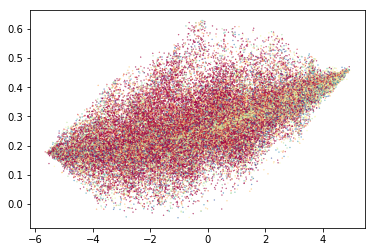

In [84]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=80,
    random_state=42,
).fit_transform(imgs_flat)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=bounded_annotations_train, s=0.1, cmap='Spectral')
#kmeans_labels = cluster.KMeans(n_clusters=5).fit_predict(imgs_flat)
#plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=0.1, cmap='Spectral')
#lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(lowd_train)

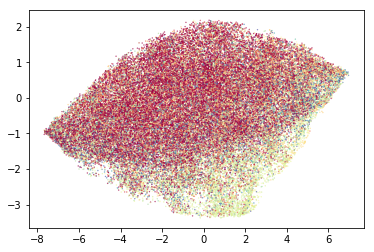

In [85]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=bounded_annotations_train, s=0.1, cmap='Spectral');

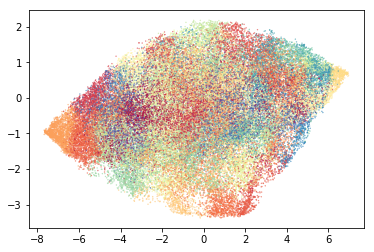

In [86]:
kmeans_labels = cluster.KMeans(n_clusters=80).fit_predict(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [87]:
clustering_rand_score = adjusted_rand_score(bounded_annotations_train, kmeans_labels),
clustering_MI = adjusted_mutual_info_score(bounded_annotations_train, kmeans_labels)


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


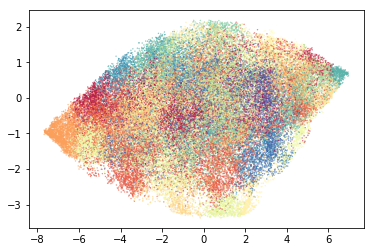

In [88]:
lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
kmeans_labels_pca = cluster.KMeans(n_clusters=80).fit_predict(lowd_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels_pca, s=0.1, cmap='Spectral')
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

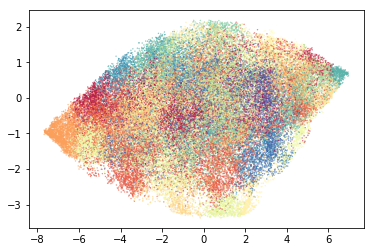

In [108]:
kmeansPCA = plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels_pca, s=0.1, cmap='Spectral')
kmeansPCA.figure.savefig('KmeansPCA.png')

In [ ]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)

colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []
fig,ax = plt.subplots(1)
ax.imshow(image)
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

In [ ]:

'''
#testsplits = list(chunks(dummy_annotations, 50))
#labels, features = splitPreprocessing(testsplits, data_folder, path)

'''

categories_subset = [2,52]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))




In [ ]:
iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.999)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.999)

In [ ]:
iterative_split_train = []
for instance in iterative_x_train:
    iterative_split_train.append(itemsets[instance[0]])
iterative_split_val = []
for instance in iterative_x_test:
    iterative_split_val.append(itemsets[instance[0]])

In [ ]:
iterative_train_categories = np.zeros(100, dtype=object)
iterative_val_categories = np.zeros(100, dtype=object)
for subset in iterative_split_train:
    print(subset)
    for item in subset:
        iterative_train_categories[item] += 1

for subset in iterative_split_val:
    for item in subset:
        iterative_val_categories[item] += 1

iterative_train_categories = iterative_train_categories[iterative_train_categories != 0]
iterative_val_categories = iterative_val_categories[iterative_val_categories != 0]
for i in range(0, len(iterative_train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(iterative_train_categories[i]))
    iterative_train_categories[i] = (categories[i]["name"], iterative_train_categories[i])

for i in range(0, len(iterative_val_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(iterative_val_categories[i]))
    iterative_val_categories[i] = (categories[i]["name"], iterative_val_categories[i])

plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in iterative_train_categories])
plt.subplot(212)
plt.plot([i[1] for i in iterative_val_categories])

In [ ]:
mskf = MultilabelStratifiedKFold(n_splits=100, random_state=0)

for train_index, test_index in mskf.split(instances_train, labels_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_split, test_split = instances_train[train_index], instances_train[test_index]
    y_train_split, y_test_split = labels_train[train_index], labels_train[test_index]

In [ ]:
print(len(train_split))

In [ ]:
random_images_bboxes = []
random_images_bboxes_val = []
for image in rand_images[0]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for image in rand_images[1]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)

In [ ]:
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))


In [ ]:
ax = plt.subplots(1, figsize=(8, 4))
ax.axis('off')
ax.imshow(images_train[1][3])

In [ ]:
images_train_stack = np.vstack(images_train)
images_val_stack = np.vstack(images_val)


In [ ]:
test_image = getPicture(iterative_x_train[0][0],path)
#print(test_image[1])
print(images_train_stack[0])

In [ ]:
images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
#images_train_stack = np.vstack(images_train)
#images_val_stack = np.vstack(images_val)
full_picture_features = calculateFeatures(images_train)
full_picture_features_val = calculateFeatures(images_val)
np.set_printoptions(threshold=np.inf)
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

In [ ]:
iterative_y_train_bool = iterative_y_train == 1
iterative_y_val_bool = iterative_y_val == 1
print(iterative_y_train[2:20])

In [ ]:
svmHOG = svmFit(picture_features, bounded_annotations_train)
svmHOGResults = svmPredict(picture_features_val, bounded_annotations_val, svmHOG)


In [ ]:
#slidingWindow("000000002664")

In [ ]:
fit_rf = RandomForestClassifier(random_state=42)
param_dist = {'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 5,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(picture_features, bounded_annotations_train)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)

In [ ]:
rfHOG = randomForestFit(picture_features, bounded_annotations_train, 500)
rfHOG_results = rfPredict(picture_features_val, bounded_annotations_val, rfHOG)

In [ ]:
print(rfHOG.feature_importances_)
print(rfHOG.oob_decision_function_)

In [ ]:
# width 578.2023976316078
# heigth 483.5494085111049

path = "data/train2014/COCO_train2014_"
def getPictures(itemsets, path, instance):
    images = []
    image_ids = []
    image_tags = []
    avg_width, avg_height = (0,0)
    try:
        for itemset in itemsets:
            print(itemset)
            print(itemsets[itemset])
            if(instance in itemsets[itemset]):
                image_id_string = str(itemset).zfill(12)
                image_ids.append(str(itemset))
                image = Image.open(path + image_id_string +'.jpg')
                processed_img = preProcessImage(image)
                image.close()
                resized_image = resize(processed_img, (350, 292),anti_aliasing=True)
                images.append(resized_image)
                image_tags.append(itemsets[itemset])
    except Exception as ex:
            print(ex)   
    return image_ids,images,image_tags

pictureData = getPictures(itemsets, path, 18)
#print(pictureData)

In [ ]:
def example_errors():
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)
categories_subset = [2,6,19]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))

#images = np.asarray(pictureData[1])

'''
#x_train, x_test, y_train, y_test = train_test_split(
#    imgs, y_train, test_size=0.25, random_state=42)
'''
x_train = imgs/255
x_test = imgs_val/255

'''
for (i,value) in enumerate(y_train):
    if value == 2:
        y_train[i] = 0
        continue
    if value == 6:
        y_train[i] = 1
        continue
    if value == 19:
        y_train[i] = 2
        continue
    if value == 20:
        y_train[i] = 3
        continue
    if value == 33:
        y_train[i] = 4
        continue
    if value == 46:
        y_train[i] = 5
        continue
    if value == 49:
        y_train[i] = 6
        continue
    if value == 55:
        y_train[i] = 7
        continue
for (i,value) in enumerate(y_test):
    if value == 2:
        y_test[i] = 0
        continue
    if value == 6:
        y_test[i] = 1
        continue
    if value == 19:
        y_test[i] = 2
        continue
    if value == 20:
        y_test[i] = 3
        continue
    if value == 33:
        y_test[i] = 4
        continue
    if value == 46:
        y_test[i] = 5
        continue
    if value == 49:
        y_test[i] = 6
        continue
    if value == 55:
        y_test[i] = 7
        continue
'''
datagen = ImageDataGenerator(
    zca_whitening=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(zca_whitening=True)
datagen_test.fit(x_test)         
ylabels_test = to_categorical(y_test)
ylabels_train = to_categorical(y_train)

#joblib.dump(value=ylabels_train, filename='outputs/ylabels_train2,6,19,20,33,46,49,55c.npy')
#joblib.dump(value=ylabels_test, filename='outputs/ylabels_test2,6,19,20,33,46,49,55c.npy')

In [ ]:
print(x_train[0:10])

In [ ]:
x_train = joblib.load('outputs/trainset2,6,19,20,33,46,49,55.npy')
x_test = joblib.load('outputs/testset2,6,19,20,33,46,49,55.npy')
#ylabels_train = joblib.load('outputs/y_trainlabels2,6,19,20,33,46.npy')
#ylabels_test = joblib.load('outputs/y_testlabels2,6,19,20,33,46.npy')

In [ ]:

datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)    

In [ ]:
sess = tf.Session()
early_stopping_monitor = EarlyStopping(patience = 3)



dense_layers = [1,2,3]
layer_sizes = [64]
dense_sizes = [64]
conv_layers = [1]
kernel_sizes = [3]
for dense_layer in dense_layers:
    for dense_size in dense_sizes:
        for kernel_size in kernel_sizes:
            for layer_size in layer_sizes:
                for conv_layer in conv_layers:
                    model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, 3, x_train)
                    NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel-{}".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size, int(time()))
                    print(NAME)
                    tensorboard = TensorBoard(log_dir="logs2,6,19,20,33,46,49,55c/{}".format(NAME))
                    #model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                    model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                                        epochs=15, callbacks = [early_stopping_monitor], validation_data = (x_test, ylabels_test))
                    
'''
y_pred = model.predict_classes(x_test)
true_preds = [(x,y) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

'''
'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [],shuffle=True)
model.save_weights('model.h5')
print(model.summary())
'''

In [ ]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    	print("%f (%f) with: %r" % (mean, stdev, param))

In [131]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from random import shuffle
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC, LinearSVC
import itertools
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#from skmultilearn.model_selection import iterative_train_test_split
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    i = 0
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
        print(i)
        i += 1
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    #t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    #print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'micro'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Errors:", errors)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    return IoU

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list


def print_memory_usage(memory_variable):
    total, available, percent, used, free = psutil.virtual_memory()
    total, available, used, free = total / memory_variable, available / memory_variable, used / memory_variable, free / memory_variable
    proc = PROCESS.memory_info()[1] / memory_variable
    print('process = %s total = %s available = %s used = %s free = %s percent = %s'
          % (proc, total, available, used, free, percent))


path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"


train_annotations = train["annotations"]
#val_annotations = val["annotations"]

train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]

labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
rand_sets,rand_images = random_sets(labels,keys,200)


random_images_bboxes = []
random_images_bboxes_val = []
for image in rand_images[0]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for image in rand_images[1]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.997)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.997

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
'''

image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
print(images_train[0:10])
print(images_val[0:10])
'''
images_train_stack = np.vstack(images_train)
images_val_stack = np.vstack(images_val)
full_picture_features = calculateFeatures(images_train_stack)
full_picture_features_val = calculateFeatures(images_val_stack)
joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp.npy')
joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp.npy')
print("linear SVM random 100/50")


del images_train
del images_val
del images_train_stack
del images_val_stack
del image_id_train
del image_id_val

#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

#picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
#picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val
#svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
#svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
#joblib.dump(value=svmrbf, filename='outputs/svm_rbf_all_0.02random.npy')
svm = svmFit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
joblib.dump(value=svmResults, filename='outputs/confusion_matrix_svm_all_100/50random.npy')
joblib.dump(value=svm, filename='outputs/svm_lin_all_100/50random.npy')

'''
'''
categories_subset = [2,6]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))
    
joblib.dump(value=imgs, filename='outputs/bounded_imgs2,6,19,20,33,46,49,55.npy')
joblib.dump(value=imgs_val, filename='outputs/bounded_imgs_val2,6,19,20,33,46,49,55.npy')
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)
joblib.dump(value=features, filename='outputs/features2,6,19,20,33,46,49,55.npy')
joblib.dump(value=features_val, filename='outputs/features_val2,6,19,20,33,46,49,55.npy')
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]
print("SVM")
svm = svmFit(features_concat, y_train)
svm_results = svmPredict(features_val_concat, y_test, svm)
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')
print("RF")
rf = randomForestFit(features_concat, y_train, 1000)
rf_results = rfPredict(features_val_concat, y_test, rfHOG)
joblib.dump(value=rf, filename='outputs/rf.pkl')
'''

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: 

In [195]:
%%writefile $script_folder/neural_network.py

import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import itertools
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
import keras.backend as K
from random import shuffle, seed
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score, roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
import time



def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # How many selected items are relevant?
    precision = c1 / c2

    return precision

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / c3

    return recall

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list


def equalClassSizes(annotations, number_instances, path):
    bounded_images = []
    bounded_annotations = []
    image_ids = []
    instance_counts = [0] * 91
    seed(42)
    shuffle(annotations)
    for annotation in annotations:
        if instance_counts[annotation['category_id']] < number_instances:
            try:
                image_id = annotation['image_id']
                image_id_string = str(image_id).zfill(12)
                image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
                image = preProcessImage(image) 
                image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                       , (104, 107),
                               anti_aliasing=True)
                bounded_images.append(image_resized)
                bounded_annotations.append(annotation['category_id'])   
                image_ids.append(image_id)
                instance_counts[annotation['category_id']] +=1
            except Exception as ex:
                    print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    image_ids = np.asarray(image_ids)
    return image_ids,bounded_images,bounded_annotations

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            image_id_string = str(image_id).zfill(12)
            image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (50, 50),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
outputs_folder = os.path.join(args.data_folder, 'outputs')
print('Data folder:', data_folder)
print('output folder:', outputs_folder)
run = Run.get_context()

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

'''
with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)
train_annotations = train["annotations"]
del train
'''

'''
with open(os.path.join(data_folder, "annotations/instances_val2014.json")) as read_file:
    val = json.load(read_file)
val_annotations = val["annotations"]
del val
images_bboxes_equal = equalClassSizes(train_annotations,100, path)
images_train = images_bboxes_equal[1]
bounded_annotations_train = images_bboxes_equal[2]
#del images_bboxes_equal
images_bboxes_equal_val = equalClassSizes(val_annotations,100, valpath)
images_val = images_bboxes_equal_val[1]
bounded_annotations_val = images_bboxes_equal_val[2]
'''

'''
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.1,train_size=0.15, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)
'''
'''
joblib.dump(value=images_train, filename='outputs/images_train_strat_0,85.npy')
joblib.dump(value=images_val, filename='outputs/images_val_strat_0,9for0,85.npy')
joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_strat_0,85.npy')
joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_strat_0,9for0,85.npy')
'''
'''
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets
'''
'''
rand_sets,rand_images = random_sets(labels,keys,200)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:30]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for image in rand_images[30:60]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
print("bboxes finished")
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
'''

'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])
del labels
del keys
iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.8)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.8)

del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test
del iterative_x_val
del iterative_y_val

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
del images_bboxes_val
del image_id_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
'''
'''
x_train = joblib.load(os.path.join(data_folder, 'trainset2,6,19,20,33,46,49,55c.npy'))
x_test = joblib.load(os.path.join(data_folder, 'testset2,6,19,20,33,46,49,55c.npy'))
ylabels_train = joblib.load(os.path.join(data_folder, 'ylabels_train2,6,19,20,33,46,49,55.npy'))
ylabels_test = joblib.load(os.path.join(data_folder, 'ylabels_test2,6,19,20,33,46,49,55.npy'))
'''
#joblib.dump(value=images_train_stack, filename='outputs/images_train_stack_all_0,99rand.npy')
#joblib.dump(value=images_val_stack, filename='outputs/images_val_stack_all_0,99rand.npy')
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_all_0,99rand.npy')
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_all_0,99rand.npy')

'''
datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
print("datagen train")
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)
print("datagen test")
'''
'''
images_bboxes_equal = equalClassSizes(train_annotations,100, path)
images_bboxes_equal_val = equalClassSizes(val_annotations,100, valpath)

images_train_stack = images_bboxes_equal[1]
bounded_annotations_train = list(images_bboxes_equal[2])
images_val_stack = images_bboxes_equal_val[1]
bounded_annotations_val = list(images_bboxes_equal_val[2])
'''
'''
x_train = images_train_stack/255
x_test = images_val_stack/255
'''


images_train = joblib.load(os.path.join(data_folder, 'images_train_strat_0,85.npy'))
images_val = joblib.load(os.path.join(data_folder, 'images_val_strat_0,9for0,85.npy'))
bounded_annotations_train = joblib.load(os.path.join(data_folder, 'bounded_annotations_train_strat_0,85.npy'))
bounded_annotations_val = joblib.load(os.path.join(data_folder, 'bounded_annotations_val_strat_0,9for0,85.npy'))


print(images_train.shape)
print(images_train.shape[0])
dataset_size = images_train.shape[0]
TwoDim_dataset = images_train.reshape(dataset_size,-1)
'''
smt = SMOTETomek(random_state=42)
X_res_tm, y_res_tm = smt.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''

tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)
x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50, 3)

images_train = x_res_3d
bounded_annotations_train = y_res_tm
joblib.dump(value=images_train, filename='outputs/TOMEKLINKS_train_strat_0,85.npy')
joblib.dump(value=bounded_annotations_train, filename='outputs/TOMEKLINKS_annotations_train_strat_0,85.npy')
'''
joblib.dump(value=images_train, filename='outputs/images_train_SMOTETOMEK_0,85.npy')
joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_SMOTETOMEK_0,85.npy')
'''
x_train = images_train/255
x_test = images_val/255
print("divided by 255")
corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_0,9rand.npy')
#joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_0,9rand.npy')
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")
print("15% TOMEK NN")
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    early_stopping_monitor = EarlyStopping(patience = 5)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [128]
    dense_sizes = [128]
    conv_layers = [3]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=200, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                        y_pred = model.predict(x_test)
                        #print(y_pred)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        true_class_list = true_class.eval()
                        predictions_list = predictions.eval()
                        print(classification_report(true_class_list, predictions_list, digits=3))
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        '''
                        model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        epochs=10, callbacks = [tensorboard], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
                        confusion = tf.confusion_matrix(labels=y_, predictions=y, num_classes=num_classes)
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        model.save('outputs/' + NAME +'0.85_SMOTETomek_100epochs.h5')
'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                    epochs=100, callbacks = [], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
'''

Overwriting ./coco-multi-label/neural_network.py


In [201]:
%%writefile $script_folder/train.py

import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from random import shuffle, seed
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC, LinearSVC
import itertools
from imblearn.under_sampling import TomekLinks
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.dummy import DummyClassifier
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def svm_rbfFit(x_train, y_train):
    print("Fitting the classifier to train")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    return IoU

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            image_id_string = str(image_id).zfill(12)
            image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (50, 50),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations



parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
outputs_folder = os.path.join(args.data_folder, 'outputs')
print('Data folder:', data_folder)
print('output folder:', outputs_folder)
run = Run.get_context()

'''
path = "train2014/COCO_train2014_"
valpath = "val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

#with open(os.path.join(data_folder, "annotations/instances_val2014.json")) as read_file:
#    val = json.load(read_file)
print("dummy random 0.98")
train_annotations = train["annotations"]
#val_annotations = val["annotations"]
'''
'''
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.1,train_size=0.1, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)

full_picture_features = calculateFeatures(images_train)
del images_train
full_picture_features_val = calculateFeatures(images_val)
del images_val
'''
'''
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

rand_sets,rand_images = random_sets(labels,keys,200)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:20]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for imageset in rand_images[20:40]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val

strategies = ['stratified','most_frequent','prior','uniform']
for strat in strategies:
    clf = DummyClassifier(strategy=strat, random_state=42)
    clf.fit(images_train_stack, bounded_annotations_train)
    DummyClassifier(constant=None, random_state=42, strategy=strat)
    print(clf.score(images_val_stack, bounded_annotations_val))
    y_pred = clf.predict(images_val_stack)
    print("Accuracy:", accuracy_score(bounded_annotations_val, y_pred))
    print("Precision_weighted:", precision_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(bounded_annotations_val, y_pred))
'''   
'''
full_picture_features = calculateFeatures(images_train_stack)
del images_train_stack
full_picture_features_val = calculateFeatures(images_val_stack)
del images_val_stack
'''
'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.97)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.97)

del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test
del iterative_x_val
del iterative_y_val

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
del images_bboxes_val
del image_id_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
full_picture_features = calculateFeatures(images_train_stack)
del images_train_stack
full_picture_features_val = calculateFeatures(images_val_stack)
del images_val_stack

'''
print("TOMEK SVM RF 0.075")
images_train = joblib.load(os.path.join(data_folder, 'images_train_strat_0,925.npy'))
images_val = joblib.load(os.path.join(data_folder, 'images_val_strat_0,925.npy'))
bounded_annotations_train = joblib.load(os.path.join(data_folder, 'bounded_annotations_train_strat_0,925.npy'))
bounded_annotations_val = joblib.load(os.path.join(data_folder, 'bounded_annotations_val_strat_0,925.npy'))
images_train_gray = []
images_val_gray = []
for img in images_train:
    images_train_gray.append(rgb2gray(img))
del images_train
for img in images_val:
    images_val_gray.append(rgb2gray(img))
del images_val


images_train_gray = np.asarray(images_train_gray)
print(images_train_gray.shape)
print(images_train_gray.shape[0])
dataset_size = images_train_gray.shape[0]
TwoDim_dataset = images_train_gray.reshape(dataset_size,-1)
'''
smt = SMOTETomek(random_state=42)
X_res_tm, y_res_tm = smt.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''

tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)

x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50)

images_train_gray = x_res_3d
bounded_annotations_train = y_res_tm

full_picture_features = calculateFeatures(images_train_gray)

full_picture_features_val = calculateFeatures(images_val_gray)


np.set_printoptions(threshold=np.inf)
#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

svm = svmFit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
joblib.dump(value=svm, filename='outputs/svm_strat_tm_0,925.npy')
joblib.dump(value=svmResults, filename='outputs/svm_strat_tm_confusion_matrix_0,925.npy')

del picture_features_svm
del picture_features_svm_val

picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val
#svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
#svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
#joblib.dump(value=svmrbf, filename='outputs/svm_rbf_all_0.02random.npy')



try:
    rf = randomForestFit(picture_features_rf, bounded_annotations_train, 300)
except Exception as ex:
    print(ex)
try:
    rf_conf = rfPredict(picture_features_rf_val, bounded_annotations_val, rf)
except Exception as ex:
    print(ex)
joblib.dump(value=rf, filename='outputs/rf_strat_tm_0,925_300trees.npy')
joblib.dump(value=rf_conf, filename='outputs/conf_mat_rf_strat_tm_0,925_300trees.npy')

'''
categories_subset = [2,6]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))
    
joblib.dump(value=imgs, filename='outputs/bounded_imgs2,6,19,20,33,46,49,55.npy')
joblib.dump(value=imgs_val, filename='outputs/bounded_imgs_val2,6,19,20,33,46,49,55.npy')
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)
joblib.dump(value=features, filename='outputs/features2,6,19,20,33,46,49,55.npy')
joblib.dump(value=features_val, filename='outputs/features_val2,6,19,20,33,46,49,55.npy')
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]
print("SVM")
svm = svmFit(features_concat, y_train)
svm_results = svmPredict(features_val_concat, y_test, svm)
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')
print("RF")
rf = randomForestFit(features_concat, y_train, 1000)
rf_results = rfPredict(features_val_concat, y_test, rfHOG)
joblib.dump(value=rf, filename='outputs/rf.pkl')
'''


Overwriting ./coco-multi-label/train.py


In [202]:
import shutil
shutil.copy('utils.py', script_folder)

'./coco-multi-label\\utils.py'

In [203]:
from azureml.train.estimator import Estimator


script_params = {
    '--data-folder': ds.as_mount(),
}


est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn', 'scikit-image', 'pillow', 'opencv', 'numpy'],
                pip_packages=['scikit-multilearn', 'imblearn'])

run = exp.submit(config=est)
run
'''

keras_est = TensorFlow(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='neural_network.py',
                       pip_packages=['keras', 'scikit-learn', 'scikit-image', 'pillow', 'numpy', 'scikit-multilearn', 'imblearn'],
                        use_gpu=True)

run = exp.submit(config=keras_est)
run
'''
'''
from azureml.widgets import RunDetails
RunDetails(run).show()

run.wait_for_completion(show_output=True) # specify True for a verbose log

print(run.get_metrics())

print(run.get_file_names())
'''
# register model 
#model = run.register_model(model_name='svm_hog', model_path='outputs/svm_hog.pkl')
#print(model.name, model.id, model.version, sep = '\t')

'\nfrom azureml.widgets import RunDetails\nRunDetails(run).show()\n\nrun.wait_for_completion(show_output=True) # specify True for a verbose log\n\nprint(run.get_metrics())\n\nprint(run.get_file_names())\n'

In [43]:
print(images_train)

[[[[0.01992471 0.02656627 0.03154745]
   [0.03118353 0.03423137 0.03889412]
   [0.0406     0.029      0.02843137]
   ...
   [0.26213725 0.24337255 0.22381176]
   [0.25690588 0.24337255 0.22799686]
   [0.18596392 0.17766196 0.16769961]]

  [[0.02542118 0.0338949  0.0402502 ]
   [0.03978588 0.04367451 0.04962353]
   [0.0518     0.037      0.03627451]
   ...
   [0.33445098 0.3105098  0.28555294]
   [0.32777647 0.3105098  0.29089255]
   [0.23726431 0.22667216 0.21396157]]

  [[0.03091765 0.04122353 0.04895294]
   [0.04838824 0.05311765 0.06035294]
   [0.063      0.045      0.04411765]
   ...
   [0.40676471 0.37764706 0.34729412]
   [0.39864706 0.37764706 0.35378824]
   [0.28856471 0.27568235 0.26022353]]

  ...

  [[0.01288235 0.02576471 0.01545882]
   [0.02301176 0.03730588 0.02452941]
   [0.036      0.04217647 0.03264706]
   ...
   [0.18670588 0.06052941 0.00864706]
   [0.14449412 0.07514118 0.02001176]
   [0.09275294 0.05925882 0.01803529]]

  [[0.01059216 0.02118431 0.01271059]
   [0.0

In [216]:
path = "data/train2014/COCO_train2014_"
train_annotations = train["annotations"]
#val_annotations = val["annotations"]
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.05,train_size=0.05, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)

115218
332463
53778
152320
41008
530950
101127
351262
455090


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


351539
336479
164200
506910
540428
161871
469024
462065
403132
762
543661
309461
64008
136070
431207
30779
578128
520063
18802
39016
529490
220321
30001
424692
435090
576286
546211
539180
458286
436698
79498
364868
67657
103089
466217
5689
8686
311324
576622
149060
98943
416576
346026
254637
179408
495695
189975
523921
47667
327788
271488
386784
73999
78225
152406
169003
465723
241818
229995
63121
14774
401608
363202
478448
311109
437868
550028
577125
293679
572173
36292
56109
295838
34793
67560
138659
191616
193824
496933
461336
246009
388403
279844
292146
220077
289644
111277
469768
501022
297581
338971
298031
6846
184106
524249
418087
399499
532710
141382
438878
282558
515550
198631
560180
56126
97211
490112
221615
150911
498786
166926
399181
521200
479412
351126
381217
408204
369443
122818
421529
175480
323470
230864
325833
98601
84744
108124
10711
326891
521070
255930
282514
216119
136323
319676
479560
293169
155749
133505
492492
185656
495095
53595
387329
381509
542431
234994
255

334104
568873
242592
552114
563475
307259
533045
347167
512147
130147
511281
169360
234475
349103
332724
135288
378522
400603
402184
155344
542112
286302
394065
387401
269477
394880
10318
523641
505738
341060
433334
37035
83482
460092
167645
310013
289758
120706
540554
130972
308524
257928
507876
306811
456800
326237
468258
329343
158823
576012
117821
444799
56753
63143
424692
452380
312346
220991
486567
205967
426548
96538
294404
299085
525012
496673
271136
33057
156073
364796
211283
176195
368626
158087
255660
41437
357017
373415
211918
41832
515638
59024
495840
83770
509620
72016
300415
117774
178171
105063
78380
33861
498938
48428
409982
59080
441605
395684
501006
86620
470711
427154
53539
479452
404948
278675
4244
83878
328314
355481
552368
378146
506231
163125
539596
210079
253863
409897
115345
103419
238086
315462
83914
103331
292146
230334
463702
424124
501625
526168
284144
520213
306830
194941
482596
305366
532461
25759
10058
254194
117417
297131
542589
139590
474720
267870
37

161356
263111
27348
8285
98123
328314
416372
504165
514563
421432
416723
65144
502366
141519
534917
20966
505421
263456
151619
392657
532471
137661
439270
439185
318637
486404
187574
194459
517362
348269
207077
177238
428152
146819
273276
254179
138659
351972
207094
500032
34616
161809
344597
467746
193042
100542
557869
358534
298004
430261
30677
442926
170754
387518
504258
141586
19250
540162
131300
473337
491182
460666
404450
381619
565435
326190
213117
551446
27950
523561
67802
22525
314703
197005
385674
22696
451101
139389
188889
428304
288099
404899
483769
314904
426085
78412
426390
498639
308653
289326
14083
304455
278315
500764
72595
223295
343243
407808
294587
444692
275450
496059
197629
373747
169726
579862
46002
22008
260634
364222
341245
2931
232379
106371
108722
495641
66236
26995
431555
543911
35052
509509
194752
356182
227723
324682
338833
334850
6151
40248
48971
422563
461644
455322
303436
26938
86292
157158
276854
487948
519218
199930
312003
185486
236102
219379
257513


253970
212532
390646
87783
204919
229622
575761
173297
369078
327876
290185
233351
220156
14027
131343
290767
298353
519228
287575
89052
202532
563592
291009
116155
79660
469495
384030
569505
32629
119423
224042
152020
314766
44878
518273
249226
540059
498980
317659
48797
98479
355050
231907
175951
519548
290398
258882
465265
505552
24730
211138
83986
312247
272034
350837
264309
73574
512292
285821
285958
145178
305724
516264
103554
81585
541764
413942
76187
374454
64170
171180
251702
216694
73192
373731
298545
240618
232919
407590
538999
282293
22871
388865
178171
157811
234285
329476
157087
419276
364770
351608
142426
51199
47548
470474
581218
137583
42109
77899
525128
289738
457437
304765
288905
472344
447574
420465
155106
174554
353507
526701
427180
244132
486738
131703
479666
349047
473665
87649
194653
155652
332932
63347
125116
330253
393922
471279
113700
143269
183395
22222
422593
141336
315508
49988
81065
334852
148871
277096
246539
86183
531958
207749
406056
94687
32906
486581

536145
100642
273559
409767
469315
402541
12838
537220
465853
213433
501189
219335
81177
88540
40870
560311
208196
634
332773
363469
573476
290354
161006
226966
94453
124364
259346
320077
250238
547348
556709
239515
425342
221004
476575
470068
452930
474073
556060
185281
114392
454222
288032
152429
170483
71964
581744
401440
27792
307534
984
188987
324006
229616
95880
179505
118543
280926
447738
111933
67259
467905
385672
269483
571407
121366
368409
545163
445093
566938
310523
446628
15354
209126
41008
265330
567037
272351
89155
177182
433900
554031
404964
456224
472103
342495
172158
466719
150444
232181
557081
38923
381000
64733
537555
545721
472041
285570
201488
438477
288852
481036
495670
241496
153128
210187
523007
370843
160428
346360
50056
536374
134819
383841
152789
578714
421476
16672
548416
281158
442343
452236
103437
524069
308687
340976
426343
16677
232001
554668
37035
208782
79269
429448
383205
551418
316178
556617
268213
302019
339453
510522
337111
27190
68594
351062
28504

255425
235687
157037
335133
67749
555473
313644
502441
399078
469851
355697
159309
197662
542514
238535
169360
404750
493199
240902
337780
436975
501110
562138
265080
185656
114326
325570
277263
444749
239884
195411
53928
184806
144337
386853
333144
53304
458198
264581
225579
549135
158567
77055
39698
55344
241860
496064
367835
249727
283682
129921
265327
2281
224272
472553
228155
8066
389777
408303
271994
302680
548958
537222
158794
453299
310759
402936
386768
423355
507520
359996
515470
296573
47792
415150
204422
261945
300537
229707
450904
60999
281262
158897
577830
124827
408917
239001
60526
515550
121219
175552
277799
21175
531032
452087
509225
302569
299495
564421
102037
250417
215033
401826
474709
255889
451550
218870
276829
210079
522258
342662
476151
9929
6539
409740
284664
563764
299836
579329
22256
191159
9615
372357
72424
326108
529310
93793
521663
554301
381193
409275
168758
536312
248818
298458
451033
381093
317874
278936
58407
567423
190921
453311
366702
385342
152461
54

73302
508722
252407
200625
538018
548253
20391
43873
315101
444418
383933
460115
393251
561126
119129
443410
272803
136202
222475
182556
376241
368717
250295
532062
289492
160443
185151
169322
399686
151351
316699
231466
61992
238729
469499
426052
259420
351401
223315
285548
438346
147290
399780
380949
50995
461189
377716
462517
96765
78553
441199
197583
127681
551164
579255
469248
49979
236515
348621
25192
357877
143089
319735
365236
83155
514546
494980
578521
374553
173284
111277
506576
195508
461222
118785
393268
522173
24086
563391
263603
274724
434940
511789
259359
260500
42972
136145
343225
42042
527155
330164
2614
60305
514435
403999
226263
246345
434354
233526
417153
393442
55443
18529
56006
136599
386890
428152
423414
322934
386408
57313
337147
395271
421314
50913
528756
368066
67462
65962
399232
463715
152857
325369
54411
412544
102471
48451
341399
251772
202657
13124
171766
502370
252217
112459
466530
234234
441105
453680
5469
544760
199029
487145
349153
267152
305557
406909

381458
52418
353839
363607
398053
132533
93708
506710
479577
468615
196290
57676
488191
309002
190939
108100
553896
559497
303986
385050
189993
485931
327713
456608
132420
245118
413073
113952
560576
238584
267661
128512
278371
92869
5608
578337
555143
101750
580082
536023
506673
184135
370793
159768
482665
39309
425542
406047
372404
169179
365351
151016
402167
554643
269343
145211
245806
120052
52497
524249
351796
566385
201352
576810
439560
175020
560525
90433
311566
144580
369369
503460
491611
148375
168001
411617
579729
456106
264741
479697
136241
24239
154869
574579
312686
300333
396499
381244
36728
91712
89147
166481
294002
404684
443018
224414
163591
387517
430345
47667
225164
355582
494409
209919
567935
338637
560571
311783
552755
490646
18294
128254
205931
520471
563514
321389
324521
101575
136300
409275
196917
49312
147082
135554
280829
157491
145186
181612
315092
165610
431112
90218
475146
148165
481391
293448
252883
67155
311324
537780
146467
208082
364835
521649
128248
896

403358
349787
183890
509358
391786
215896
429065
382997
451283
454541
76970
553849
268388
270111
65407
294811
530293
311882
271235
247071
527112
203252
246029
399258
480864
574717
375809
435471
566419
257908
226383
556666
102175
331680
515428
255368
266676
181682
557783
343215
506832
152502
386936
518555
566899
437282
157105
495169
446956
73096
452269
183562
224971
26800
25858
564680
563692
439463
506414
356153
470937
478092
395504
97818
453762
339545
310015
436780
485649
299675
31948
382631
116677
48267
471708
472439
280368
76349
214526
325132
305259
456640
415822
240467
287904
286619
205621
337663
267704
325570
384326
7174
541730
223719
253945
566828
113261
7746
244425
223984
343650
277503
77650
159409
543058
512582
581900
202762
556154
570457
294866
506087
7504
549166
569742
116049
183247
321991
191806
55818
70380
30779
167027
323862
159026
189148
320759
371166
145631
86248
399618
547797
377262
409574
81200
337975
472452
461222
19906
355801
542576
469921
67496
104788
461170
21811
40

299836
276644
25230
213389
261902
511346
252136
579751
481807
821
227117
10239
580505
153736
495124
142050
288578
355674
424982
314371
424124
73549
104384
554238
529629
118459
38317
450026
506172
448220
197950
281846
504325
7232
71984
467347
275348
517005
346653
536265
130180
442735
210010
519844
508722
247247
500778
471788
253600
358586
87007
95633
93025
245551
320472
127866
134085
83690
50134
52943
98641
305282
575743
327181
144796
59244
274586
246375
34279
423355
108840
128154
249813
10890
571318
490646
277576
147823
334180
437900
576676
365950
418054
554587
196021
581218
242036
51396
451620
86825
540840
56007
524180
151403
61877
235871
542452
234468
485188
88720
464303
62652
292549
140067
51285
82813
24699
149539
564759
448174
379962
440894
533957
199460
469770
559986
159280
176298
457926
156977
103504
440460
523304
92188
221880
230340
211336
226046
335914
93724
6572
17057
41305
182275
21138
192183
261702
379777
272412
42591
304548
307156
332296
563364
104953
217407
516046
249968
3

402603
359909
451969
220082
524730
304047
313437
365351
77095
157108
167692
541553
474979
321879
424018
226424
569591
75213
476189
546847
226528
154140
274547
205955
502838
484171
283257
187560
290623
540892
448547
263328
273081
16273
4172
551609
541580
293240
449088
381619
156367
54354
525075
162963
424632
179203
7621
159199
442451
359567
63866
127196
44782
305746
263883
123514
370378
321879
248694
302349
215135
508467
523349
456453
479914
35094
443136
205724
33094
500324
556838
158053
252136
33861
497930
230597
132521
167551
90122
120969
549442
331724
262207
293825
109450
209875
63556
302713
532595
500761
579663
403579
52609
543027
460780
275038
460222
180987
151482
152588
304999
111280
221746
34779
204407
48670
331541
466277
132249
29405
119543
484790
526664
173252
193529
170540
249348
390286
208372
348290
432424
531391
30888
306431
20769
567396
564655
119618
109591
491981
267700
247919
112053
23676
452619
404270
481796
580286
109836
443479
547869
104309
385837
179408
45181
559647
1

289971
234416
542809
372726
555073
335212
240054
306627
257308
381186
125213
515212
245675
279345
28392
437660
510399
552461
223500
11667
459787
211351
363750
515550
410731
397186
485595
472329
114718
446565
231863
532175
61053
459993
352835
292554
68662
425243
472620
116131
454631
86393
468125
317036
330238
239528
126129
28304
58565
223598
581256
525693
468742
299346
5917
414046
341341
575837
336077
427864
16578
281217
432153
346026
313993
347462
576527
142262
548375
71126
535164
132529
162488
249620
447678
57617
209195
572926
399887
17183
71917
45491
74861
328969
211536
30148
268192
133257
93580
495454
211185
529667
381556
58708
55947
97722
369491
552406
6336
32997
411862
458082
39754
120145
78323
496192
274232
179245
391456
528994
317905
465829
156682
455875
164485
329502
391823
260439
127
354827
27810
122511
288943
459953
569024
179904
6780
59993
37433
356880
360277
81206
107425
9789
133114
206704
236424
356174
413277
285484
299712
490461
468318
121929
574497
181223
524559
198476
3

90428
517049
409050
129359
18507
554541
230644
161367
449510
65610
76740
74232
445607
570430
26221
500646
407221
419664
107353
82301
330481
322197
55629
201352
331695
144394
47125
346653
291140
324699
92731
240741
274039
491581
267372
55984
363917
558271
364104
131879
567036
337675
332333
59281
331523
368424
33743
108075
202326
325080
494795
470720
435096
69308
451893
450003
387731
532768
400860
532866
485631
214319
579576
101157
191850
562124
576963
36729
404131
315101
474979
543517
184843
520361
531834
533955
205955
357762
37716
44827
257243
394992
200138
235871
182765
449712
507243
3276
390414
275199
466390
76627
316542
546093
504909
88621
487757
74534
573297
51643
403301
187659
84851
379678
147952
116663
423083
529300
56928
445893
488952
270198
390581
484847
515020
510540
383637
410590
378720
115372
384967
381795
556883
75843
186615
26427
52426
276842
248308
24842
144337
310499
407606
5620
238245
179203
125652
355481
559900
182258
532188
54594
310315
208348
184999
213215
262001
680

462398
289490
551571
535358
59972
131913
529309
461687
573063
198119
28402
222506
304078
208365
256190
570512
136015
569046
442008
509397
262207
364770
15644
67634
123041
115156
476934
295257
555640
296648
286550
65063
468401
556617
86393
10890
460362
197155
237111
161958
323457
258304
25695
510813
332925
4968
406710
203492
375053
121363
351534
62204
296289
88868
477398
190764
393534
59236
264645
480939
299307
220364
372618
20251
110634
116064
308752
196035
321550
76414
195062
437949
530369
458123
540206
328391
556282
458682
404005
525152
367003
23718
475277
95726
402167
510012
555808
84221
536949
40723
347042
516596
328732
110423
43308
448826
209794
10136
267516
68069
345989
374308
59319
327105
507424
434190
203336
242625
522100
279415
199151
560753
179278
70133
373585
345047
151594
580600
36157
484100
567036
206501
161006
143665
491826
480712
211281
516432
494194
111591
554778
94487
210271
433992
160325
279934
520696
210845
437949
238729
239792
510676
273665
432727
19185
103108
55412

275758
463505
221814
410963
84096
271696
122147
36569
339687
483677
559525
310216
543817
125311
567836
307757
253970
12711
126204
87137
271235
205093
277914
178184
148217
492114
293328
262932
562895
38432
425912
163319
505510
201083
503674
569174
387977
209537
28010
16403
308950
303257
458123
156835
175038
355481
514318
34624
250639
322749
280850
557888
353899
225566
532239
505595
267216
361547
40906
441992
389498
184679
142779
108049
320253
105330
399095
230436
530408
519738
40205
447688
226555
438075
442298
444166
168141
93078
226702
185760
495875
10991
486304
344932
251368
492298
315200
206198
22652
62129
218985
540162
267064
441228
53426
286862
299974
417261
319209
478224
439106
10037
118199
513850
276854
355210
317134
343255
565381
287399
366247
52123
312763
511392
304603
402705
360604
294933
514934
344149
243173
269871
429587
514781
327643
73302
509870
561988
442218
145161
365284
15193
51012
382784
247126
290204
300620
432964
250677
272228
504123
184201
308777
182624
148480
34528

161242
232344
307757
162309
139994
356256
49902
360747
190521
107331
432019
422255
113211
264987
181829
152632
10881
442687
117507
378711
111646
99988
579752
86064
393095
470172
504896
284956
498406
192464
561931
480065
495169
489890
41074
255399
211683
252544
297206
444206
78859
118131
159026
476198
224735
458664
457926
40304
58627
207828
425944
298122
110514
279041
180768
554373
449847
64010
119299
65518
544449
261022
83730
134924
159026
409825
112882
547411
138501
234949
157636
510220
444262
107313
330671
144488
297684
122724
21528
190521
507671
334413
260299
257176
41272
209537
500896
336021
264353
257066
379987
22530
84238
361659
121211
444010
404826
560571
276931
463944
326836
190136
10130
320159
175013
146501
392408
577358
258226
181054
341143
515058
91917
334630
56715
349686
276854
371143
15089
309552
171185
490723
14483
496902
268081
239204
420397
137320
228669
374282
136963
196170
395198
375939
170235
148639
24991
397899
263362
464490
150636
54244
512304
311087
125512
570255


478525
163992
130096
382342
512923
476984
378035
78482
296281
254025
167264
271960
532866
521775
561673
308192
424489
232809
532505
8025
260040
236318
497010
377672
248031
428851
177349
394658
276417
8063
71441
48971
172135
150746
349423
518626
483971
501323
78920
68636
318529
485180
505552
57719
534892
6004
307884
233871
148099
125769
25322
504172
236882
418315
134165
342130
211771
46310
19838
291911
35964
342085
158514
166742
97330
578334
474803
569946
281634
547265
340082
192982
118674
82894
111673
158876
13230
74340
119665
57071
33417
102357
262116
277218
500323
480391
93953
574760
75621
492151
430621
515754
459824
549199
530729
458134
33476
287324
357967
60874
115316
123074
428420
523055
235893
468538
461530
493227
230851
117781
273200
1915
300333
94544
294811
93992
549347
323114
530171
391175
551575
88047
72177
282579
418173
84192
158694
576801
2089
235652
40910
180827
441258
103098
330220
241955
165267
1507
16359
305366
4579
426869
448139
313280
43513
147051
336812
559768
429111

43960
27859
191477
65407
216820
435764
472552
300326
546097
251702
545891
331724
507882
45138
123282
561382
287308
555045
496530
119665
59403
296419
383929
19871
436085
148208
121363
348680
305254
287232
398712
571366
468585
444010
446956
282042
5508
54245
156695
197888
437522
534473
581637
486170
129888
428485
517026
72233
424553
316113
493446
132196
318445
540978
294942
131621
295952
65924
146954
63949
255808
265330
418609
434409
52394
130735
105708
60526
242257
541570
41482
403520
438196
223942
70339
16773
312961
202755
323213
542202
557200
471669
492236
351553
76970
355481
353507
548971
537152
163692
44788
525675
337728
537968
500136
152764
87363
214191
544449
478532
438805
99030
192114
90392
494534
95812
335492
395740
365123
326108
81966
499932
418087
130880
247487
438349
495568
408204
354145
112661
101215
26166
26713
5313
268711
293453
289075
119621
207739
504769
366022
322662
22240
440381
451154
387301
176759
92031
87762
514902
460187
257109
423711
52562
75258
171378
107969
2034

16955
356290
409956
438167
289147
129166
38417
14230
501534
388117
290724
223870
202532
417141
554125
68700
109700
473491
218647
355737
475578
188660
197613
254138
23451
522269
436975
471470
32997
92553
437620
34246
12233
181885
190381
530386
210010
382287
288262
529352
291897
96568
166556
79077
387809
554036
196351
226148
23718
88185
170432
94701
8602
496151
95850
289236
183427
5620
45259
434877
492943
289248
440291
267059
543480
449004
173288
26800
130362
53674
464812
119618
235081
524297
165147
531322
72495
243280
329817
323478
271495
283213
421658
214373
264396
180197
255016
307825
20289
137833
556954
71159
232198
522579
242296
508299
322203
571677
261696
38317
227978
30038
55947
292053
63121
377713
549898
397129
474256
506955
552276
166813
259655
176671
570458
441659
555781
96820
40593
218603
501325
546002
326210
288986
9744
228356
66369
127555
6747
175584
124311
102885
371911
142510
153126
180639
171378
24393
56323
91188
369610
136651
161234
317112
320936
381858
429384
248694
574

381758
110611
101014
309536
388933
354221
49402
264647
384874
383364
336077
426908
378030
46429
410898
419534
389292
352623
358581
394529
488422
494285
414111
475626
539299
545082
158794
236744
352063
65262
563746
273142
10784
247555
380924
21599
189274
237271
423330
366146
40498
426388
209386
463140
270135
110108
489856
79172
416653
450777
449599
137220
148181
290962
310472
319126
135122
118219
502179
22275
423454
535160
305885
16359
201530
285457
452930
359537
183071
580057
194455
232167
226587
232254
341399
70602
481036
263574
14269
271987
478266
297104
383873
130226
346178
22374
298306
203236
83085
115169
244549
211281
345944
320685
426548
136289
160938
475527
224471
186720
360604
55585
288215
304997
185200
277088
104124
58511
520696
451980
34086
144734
352813
237002
571773
238345
481452
513461
9620
43912
468163
225508
454745
29895
42481
130786
396105
151732
78553
286129
165757
238003
117781
147973
182455
156986
400395
363750
57719
394595
288905
432914
496045
280829
246725
473952
1

94293
283809
377878
526350
126707
7558
558917
8160
85403
133540
250565
486644
513053
55389
331222
41085
426975
376153
572405
337802
453548
531681
402448
425342
392947
545538
535143
472617
331453
291497
351210
559079
464652
459515
318164
405111
126907
401225
355621
474383
228953
326891
100435
247301
23298
281774
470710
250084
455649
136092
204181
447109
228624
558759
81944
240820
581539
327132
141336
201726
107119
156213
442298
88282
426445
265145
424124
343183
203216
431012
125686
215341
163331
418927
566968
567199
502089
552517
338807
269160
65063
543814
240344
189156
191551
149737
32270
387685
549928
361130
245086
110855
478811
372554
274267
59244
354342
566969
303800
405324
235996
435076
81964
229583
181851
206857
203975
210139
367869
323203
273276
464444
576431
312050
379777
298835
39686
37925
243986
107797
386253
558291
362804
118771
269364
61832
125120
238189
501028
209176
300578
310450
226442
271476
365329
329527
534655
330649
336129
514392
454813
554066
247397
329141
552617
402

443268
385567
527344
146454
509110
546499
466985
364222
97283
270123
59816
108575
553388
151353
457184
396179
401967
32985
49309
326836
571160
527112
478741
348751
332692
261485
335308
540664
92420
117839
378611
248337
123914
474157
52248
538701
492476
562544
88470
156035
124178
437073
441032
19093
9836
232344
11332
220835
216324
385744
144734
366405
314671
487288
466536
223078
244282
257071
566385
490267
459899
319738
144130
569492
521865
271136
287509
445723
2377
17392
392035
146881
541901
237954
24972
363120
130972
394501
537289
470378
51168
286645
359805
328673
276721
88653
490870
336385
571311
507460
380797
531963
518819
85847
187642
272480
174814
350040
22863
574194
93332
136900
531453
104325
283960
511848
84253
74466
509682
557888
376972
397105
161367
378711
383662
155177
510977
554561
524314
118837
397687
262529
463564
265161
325936
148239
154912
292289
128850
24699
298981
474062
215984
64270
14366
389184
118249
163176
89407
417638
44960
367335
246959
566237
298614
418988
54536

308384
432307
564237
249288
427040
87652
313073
539056
168754
455166
566993
107144
461236
180593
338427
468263
133278
56432
325366
388740
524924
341917
60402
393080
34469
37719
382341
139150
140990
152632
276735
453424
309949
505655
16253
518509
432233
578369
533364
440885
554524
86183
426663
59596
538291
21079
174351
186550
216740
330677
48680
29964
271495
282466
494341
514605
192524
453704
469206
421380
128608
364067
200335
306267
15588
164205
456666
32286
138189
100396
289621
109008
160302
64622
144388
109513
156073
413923
565780
268385
456658
242663
161367
401400
480474
392703
98694
83368
147226
238051
302903
286870
296153
448507
576780
528467
88487
197324
533542
158786
2536
129407
479301
432526
132038
204217
488440
16253
401603
363386
362314
285486
229583
372660
31188
469024
148032
321209
268901
294829
516957
106100
114162
24723
497847
312902
569725
50791
436932
392780
251789
285990
270790
166594
316657
443084
4201
47347
357994
401885
455405
277150
94087
290761
498492
476046
57994

11619
240695
30488
490261
68430
325389
530750
174677
445113
64283
393677
520679
58979
33749
16465
71044
167903
204775
94702
86907
80123
520213
443909
540342
208629
301479
327561
96213
13020
132954
212866
296599
291625
416810
55682
572012
181562
526187
514732
195748
510549
88477
425380
279608
546097
420938
72792
377598
251036
313600
181217
30588
391887
150331
62216
9904
254396
182575
203612
279849
288737
279169
441199
251804
525035
178207
285249
341060
254179
29114
209292
377008
206137
490908
375838
401291
157639
260664
130024
222688
88458
95018
502508
424821
576286
10166
473678
430617
522416
393656
260439
39617
60812
226541
123753
356445
522054
100912
301273
96728
548416
577520
287234
311366
569017
296847
207703
437808
435811
552136
17839
208196
491346
217165
386029
551631
223146
162741
324688
91841
418397
347989
77039
zero-size array to reduction operation minimum which has no identity
56699
452819
156221
511716
580033
83625
324829
415429
545082
501565
145911
566938
469587
337394
1838

12228
129037
537248
534917
18045
146208
426300
516474
29647
458205
231126
8816
406756
327153
47757
550761
578805
88325
426826
572998
385837
138290
339489
283475
115392
329386
352861
404322
116911
175672
186998
50003
528080
249682
223992
214419
443545
7159
403720
496294
147710
332124
325261
41284
360412
64896
106756
442345
21190
452272
536167
317431
554855
319747
10903
247871
241767
484287
320085
449781
326724
143655
219411
214526
136185
536059
450193
271235
451698
458022
257211
98943
229241
27162
103510
78517
91837
104325
123995
505553
493829
296706
14036
573724
348274
256451
457587
386788
27163
10281
206583
214526
177821
13969
28995
490347
456302
252779
529273
530038
289170
279920
216820
420937
279182
414260
538537
552318
24454
485180
426869
51720
421315
541367
77912
484960
70755
576089
495956
209574
420363
418087
75212
63662
325015
215428
172776
302078
313553
425540
461501
212429
37396
449866
258158
144574
403716
416610
53091
154907
578055
229566
367425
197636
140473
144130
436802
28

339536
379172
554169
319676
379004
208927
78263
492754
288691
374598
328651
565264
283263
113248
282466
15514
520635
42819
546708
558826
41008
56312
297880
128076
527216
575711
216279
259677
303986
369499
438333
557368
208350
178871
84422
396909
120676
211190
166179
321493
62477
48261
493822
366770
387932
144727
280302
80906
385445
429384
162645
404565
321794
34828
576809
458397
231978
267516
425864
468844
104485
469014
29075
141053
116725
305385
186476
431606
123473
567082
93785
24782
48340
37198
442732
72902
258337
23594
463625
538398
153736
106241
297600
39040
450833
296617
368564
229856
112574
230340
442332
10318
483690
211217
278710
368066
162792
533041
367106
299675
327551
139173
533019
248789
125773
124935
355477
151250
269986
476268
210437
248229
161745
490129
16060
293851
242505
563659
307968
460628
430581
228514
302885
79498
440623
419372
317537
367763
192867
423330
483690
514619
380928
182406
293272
396743
261151
5368
512143
405848
369952
7139
520480
357971
72889
72156
54962

544649
63426
35241
576581
168417
327281
95850
475578
565595
331759
216364
498406
263147
435855
36447
17488
477936
359775
565767
79077
565500
93078
350028
333356
495929
172051
44816
452022
462957
536932
454887
194643
464537
106504
518242
19399
143958
154354
376572
444274
473320
94132
535143
34837
171045
216075
293851
294397
41343
295394
298109
277706
381458
71608
533957
104541
263098
505020
384034
510859
255500
275557
120644
295294
463844
360473
36950
354309
186552
318122
149
578734
318279
271344
75565
171885
321013
571656
95349
418462
514127
253725
109219
32646
94000
394682
494894
256334
110797
419980
229583
398579
52153
106517
363621
490646
423796
111777
15486
448843
163965
259565
99077
200724
19387
267870
65098
352908
249261
91639
210214
444274
371114
19828
464303
266618
223612
317557
9133
439003
149833
136992
287167
56928
193709
281351
172392
458170
374308
362713
343470
494574
254362
324823
360246
33764
137491
18866
546952
346817
260906
59611
16665
438682
491249
362853
119561
216930

266618
502134
567375
2686
47151
341628
195797
354382
263604
497528
283323
27890
345702
221252
235062
142532
517998
236571
292923
412000
184751
336385
435152
85501
85483
72898
326239
278297
363829
313449
420608
175126
555586
178971
48263
318681
93427
462879
432873
485259
483453
61510
512100
496569
380528
389292
417763
173157
372219
60639
81784
295103
427366
176736
28858
423739
222964
56676
306232
86234
244835
92975
445671
230898
50791
496499
530285
567036
521823
83149
483039
68223
32984
320964
86552
387849
307061
464150
358421
39131
312247
490556
128337
220972
195296
294787
289428
544709
563858
37779
367518
568432
94155
157708
196931
482320
227402
163738
43001
151170
502678
78900
464271
335336
150354
424068
447135
143168
307894
476040
70800
254218
245982
235996
44827
502504
173430
459234
187007
419375
70000
394242
120241
376047
535049
333984
72984
111943
59641
384907
526608
244908
179460
358486
401829
492244
182897
300070
202128
245938
51583
3236
403683
109386
45026
447688
214526
200024

354277
270574
542450
366517
250588
481479
400818
556955
360277
55735
164680
185687
381556
194879
575227
164908
35211
280437
162084
54989
77039
554031
538640
312958
175217
24689
117327
492627
346270
256474
554031
287998
56784
447484
512506
160226
280024
518774
531033
110581
166223
551931
6709
171834
63856
312247
147187
75871
554561
136145
253945
206749
228732
338478
91841
67802
181260
114340
284144
131879
48658
298464
120718
488955
122605
336749
125230
111646
373905
571799
348370
4130
129599
5608
579291
289698
48118
328663
88720
511053
570879
89407
173745
49312
296424
361158
501902
189645
213780
49321
505507
283999
381619
560389
320115
256539
167264
115359
314378
164485
406662
127620
41233
83878
216674
214326
223836
91541
331544
48749
522758
359805
521031
320085
525513
400107
575733
369782
188037
394640
134078
439299
227109
42355
551522
395667
460882
393386
448267
521232
532457
91935
348221
562248
308027
215889
84529
248839
435311
535278
326077
73801
501902
509949
249226
537673
385464
2

133540
415283
490247
101248
125499
324381
5522
96016
297921
274039
500576
239586
67560
515623
165086
487571
569827
532014
503734
202010
439678
392099
550333
428761
354205
507471
124804
509876
423966
32626
391686
328120
30371
465874
131366
168282
433217
83332
237467
491833
425131
55951
20707
375331
375802
515581
501820
426839
116270
311065
107535
205486
360374
533128
177090
402335
122405
223315
360300
358438
38652
39203
98213
357089
251777
551314
115639
408833
488845
26783
348381
502366
556472
214067
334867
51982
268715
238831
242539
18559
427545
143756
267174
510859
93267
365008
267885
179242
194653
96535
66831
565975
543392
249835
477243
259514
132568
223434
295159
552054
28314
418030
367835
402541
510500
386796
173316
530899
160906
399191
53426
42855
281214
199930
53989
23569
229472
257874
281700
368363
322707
186944
187015
299780
523081
275327
458625
563058
404285
37113
228519
377416
569050
22142
561424
226705
346540
218774
529475
160573
463458
125120
24393
297645
283999
160653
5557

197663
528213
105444
570951
190052
163128
376843
121255
533800
208288
334184
45989
312541
133284
538270
33930
173515
97878
505705
522438
232969
35272
510977
511869
159634
217136
305390
191957
211322
502485
249151
369860
459319
547752
28797
543585
228783
319458
523332
119560
133650
111371
271360
391374
259103
388031
140247
185760
467245
29712
300374
537066
539575
363750
209460
445007
68385
73669
400913
66209
538709
144646
311208
196294
349129
375926
70133
430798
397997
238563
436195
500690
60699
404905
5620
471409
169937
343857
304603
457586
206583
452441
339545
50618
237617
256075
112226
403683
581605
129379
249543
547475
352601
246382
11794
297921
473553
19534
473438
286961
81474
400241
397605
65085
456109
366934
222227
220942
294348
181711
93649
565869
502847
138265
286120
185514
125848
73436
397315
224753
500060
252943
405055
498508
308139
44471
102473
550617
320275
90570
549435
71427
200625
392458
446088
380192
176729
263703
420396
427166
155047
493926
12109
81971
180505
171353
121

164910
467979
74080
229544
426500
84015
127839
102862
523433
317153
94079
187537
495077
375535
319766
553736
296946
508398
404612
542221
250645
431650
26304
379434
131465
515234
97492
544623
288941
59910
399208
161738
420864
377594
176716
53825
121682
195861
276479
134914
84803
469853
518645
513708
175855
514887
56432
401917
61266
341981
323588
385145
418984
360868
38663
396703
136832
75843
380440
469639
505552
95867
444156
403459
356015
143965
229874
491269
55695
231500
28451
251777
244933
580797
503886
24411
241764
6935
135327
313812
176463
62547
80140
462134
488422
223500
208055
254042
441777
20450
487194
320840
504968
528892
264676
11694
276200
542587
43191
549563
390814
545447
99728
237611
109277
312435
359005
160615
132196
255271
511200
205093
18396
451836
465530
378786
365817
426300
412762
212575
176324
537422
514161
243610
369204
512854
246312
560495
31922
217725
402880
179965
445216
319688
167169
114162
459185
310878
513461
103512
522150
259232
12283
444483
469147
3236
241767


441045
139237
303608
381208
452331
481728
278230
35844
490541
63347
243384
52819
496478
302102
580051
553370
439445
245089
89232
36029
426088
36953
378305
76607
30073
526781
559235
262286
254701
144230
474383
365309
465235
311596
580741
495489
313946
93382
567663
401225
385145
563597
217832
119016
510087
344264
41152
334857
566911
59912
568076
411061
174026
59169
375531
382342
491111
447573
10342
561913
32149
244416
4888
556089
307069
247893
146103
252448
428381
248091
234211
147122
69866
493300
87378
170204
409616
297517
193148
391525
230727
94127
510399
157539
104343
177917
519506
455881
82003
360604
360300
581495
159135
53406
105781
527720
579862
542638
520800
86861
328120
19074
392520
299672
355991
493953
368397
279189
530124
580277
17712
278793
221378
100581
452229
331616
74138
68482
59278
499985
155306
208145
102166
178645
514191
111911
568495
48267
295233
546161
254134
70236
254884
494622
164552
311620
106704
357649
374651
112011
419364
161356
67191
299672
35945
266469
130069
22

67446
260512
18000
444794
177277
83818
203859
543622
286186
59388
73837
344187
288440
516774
481652
24393
364535
360002
468357
526445
379034
257669
30109
3862
538857
116049
52628
287386
135589
531032
160264
416878
342932
506283
540068
103778
371758
122511
341596
179580
239101
150942
148437
95533
319139
423162
34779
550308
128838
188151
23096
57739
131927
315
30395
532414
27394
20651
416604
256664
176925
326064
265566
530069
564952
347736
339248
149916
392315
80360
434141
365437
415283
6247
10545
444956
120778
326892
35817
560347
428109
506172
277334
510387
268141
60822
7796
103699
569310
143764
195840
357572
224772
324018
235687
412922
304023
525678
395216
448930
286129
160708
261800
388348
10900
385552
522270
456505
421534
492137
284888
135438
310649
448876
322625
425864
450162
492156
120644
267950
474024
562826
440695
165674
441058
341809
109417
239728
294667
485397
85623
576622
51829
315168
183539
511406
444043
533041
225313
322268
163599
398301
6465
539317
570824
485933
521482
1199

339796
425061
36547
580461
491287
95202
280069
192920
6004
337752
221814
473090
7946
42682
200476
186827
466243
5522
277503
501700
444560
518859
457184
236155
250079
11271
368
391887
459026
67297
189850
295394
575331
230007
23429
290656
472654
142291
562176
154083
321194
485180
469770
560343
549199
366839
287841
403981
17078
193867
325781
211593
57870
38290
577766
223461
318355
574717
155795
334216
417143
98554
365015
376972
210450
115544
442774
111933
309531
508429
282900
576896
436046
220860
324427
437481
16773
353098
536365
561180
539216
478958
137847
547391
97032
489995
572173
69745
125603
502606
510349
259414
461267
293393
58008
498436
127921
4172
72437
376828
346021
52037
269171
543182
400722
9968
361190
208868
580919
410401
420304
60360
291009
491287
420582
229616
343498
265532
176229
448280
130610
386784
418173
128434
314822
131374
397736
469567
528342
360309
559053
105633
24393
57753
82273
91712
256549
152915
170366
447041
499789
508252
444418
38722
99321
108293
539099
90782
1

474963
556986
243160
488547
109752
542088
313798
512625
212698
211312
114674
559186
56005
524375
461183
103775
530019
64684
117993
494985
106567
399490
122782
548732
292538
129843
469197
469024
210395
343639
122164
74630
59123
99363
286696
152954
453496
289561
261720
491833
480683
76676
457703
209128
189318
390213
335913
455523
457225
193529
580957
111568
141496
414202
46512
384161
574456
112182
437282
442590
568050
210134
358083
381948
359141
2083
56116
122639
272578
224949
87862
376384
433041
407040
459659
247404
33172
308963
154354
350535
219861
215457
202888
351242
446794
435951
471731
44878
97369
539596
33471
252679
219663
184669
348180
435688
555516
86226
491191
577225
363370
259535
330894
246323
368547
456443
444033
452979
185965
159828
175359
444664
367428
87465
324682
560997
287578
50105
425497
162700
578521
280642
434084
152980
179122
243986
549527
568507
433830
118356
158883
463546
539897
82039
361021
197862
555273
26454
549559
391170
254194
10245
149921
331629
478198
121211

88609
187792
123008
133650
325298
115851
242537
578714
511482
570196
432448
11233
50040
234296
79957
276768
469009
483766
553865
566419
166477
139639
240467
107745
552679
226162
561382
532175
292356
96105
107691
506832
308
358223
178872
123041
228329
422869
259719
24296
214174
272538
389660
568854
57586
238390
420831
373613
373177
206749
93842
790
363079
176945
233688
578055
69625
371511
40643
44592
8602
554665
233143
173579
456310
16060
505629
56641
41711
453137
27667
89787
210848
381093
218302
123453
406250
44178
363764
186606
489700
223892
533011
220795
538640
433435
32816
407080
498072
66825
8469
496953
59571
205724
222587
550023
79696
536534
339876
553548
36017
83669
242113
394874
501307
267192
458202
185025
189094
81222
269588
296777
291497
334103
388740
45573
147674
288848
269508
529352
259484
569878
405451
89725
506832
93992
504023
236677
516685
27307
540384
48797
496089
393576
261448
302678
96268
576684
407135
6066
485342
533154
502508
82228
311250
140180
470147
105728
306267


270912
370682
47235
159850
319118
397894
10545
233871
284297
79269
113985
559358
242900
108589
486315
91942
238881
107586
511402
40987
477587
497327
79654
390061
301432
232417
374102
264197
271363
313579
25374
289075
27451
47621
342307
285911
139296
203450
298141
382655
482223
185358
427100
342184
266334
292928
452380
170623
524730
578317
103428
561673
44827
113488
99788
43966
418397
273304
23368
249435
455252
536562
549114
533494
373765
414849
200339
536286
318175
34828
320045
305538
269921
267008
183692
390692
255971
415378
516988
145994
377019
449847
15451
516945
235996
371548
70827
425691
350327
379987
543860
125321
549017
95903
459110
347068
378747
36157
303991
7616
249905
146049
451032
548583
42921
412566
21079
68125
71984
480200
112865
460780
173527
457781
428391
280622
62821
336708
185700
68636
49346
544086
239671
546597
381093
235624
76264
81365
409740
65955
58640
113857
303370
394271
28988
533197
75846
50791
152529
152529
239139
312841
166467
269858
474472
84448
300537
122605

331616
190087
185291
405842
54936
285376
67573
450748
36925
119525
271696
310671
171536
137341
406121
537198
177349
458827
231395
179968
211868
486066
290965
431024
566491
570111
389965
539729
1947
371940
207749
540205
24132
346450
348180
388852
463655
211033
201062
558142
292844
277129
288204
361373
432019
369382
549849
420864
343418
389031
156593
445592
309937
189565
211644
139500
283448
97504
242618
467308
36606
55681
155379
108859
442467
559586
27252
185902
530396
239204
117679
433607
506172
538517
286092
419396
220790
71646
183611
347976
361512
288379
443084
86393
74126
420713
52628
362395
79423
73192
438422
44922
239101
307671
108642
485871
126356
460459
394879
32984
185760
413160
219250
464303
409653
24091
214481
332203
165291
54749
176826
265532
420465
316446
563070
226162
100396
42740
335244
357790
126489
39131
78089
404163
402281
407092
150372
341060
398367
321448
386927
508454
306988
3353
521375
189706
315734
576518
340611
365728
410933
536752
200201
21423
5368
392170
561931

498000
112845
568396
208857
494548
114653
253416
121232
522530
168926
145843
115169
490146
11754
419678
207734
325487
57676
580505
550395
456919
546499
71271
556370
511482
340331
483677
455252
55169
150286
199698
521914
15219
134562
545163
460187
275775
531752
454131
445726
60328
303036
106792
265010
318723
408755
541570
390658
554031
34687
449250
431192
132888
568187
47475
360271
6518
357003
499396
427123
166467
281273
201192
243629
114408
236340
41404
445495
253032
290498
406233
279753
136903
386377
128076
480161
390518
106902
166201
481665
108217
151364
518509
202772
287833
383733
353881
326190
375806
411979
226825
273268
130972
139686
146972
548835
539023
494733
444764
31329
312154
142771
545874
168215
149030
495633
313798
24368
241345
385837
168161
575711
164543
410239
519157
368893
426880
229827
303407
406011
137748
91998
82031
224989
40593
221661
210395
560978
364770
189903
59309
509740
288548
176736
71109
544556
482493
79423
99803
188845
546408
546959
318937
246718
22683
471113

558656
63588
454541
225044
56550
516176
53604
448137
86524
383841
447103
501698
359707
424439
256589
163559
87756
439595
268855
318740
89397
551931
334920
306354
176736
349337
152041
69809
37074
396223
33861
226528
476681
338549
189148
32829
170451
151729
78065
339798
52250
136832
552124
253143
205904
296882
481407
558917
88780
382006
117034
29559
136832
506500
296831
33213
292242
193986
494335
63075
137984
237850
185334
350040
39597
334561
382441
178871
129031
308520
375882
579053
339159
494236
271416
42819
107109
168879
511869
572586
203108
178034
129722
149583
166450
11801
456658
255969
378684
554125
327039
130972
512757
338541
387685
398850
297570
27987
518769
358965
47164
253863
254666
180853
393795
242074
250808
28480
514346
209467
380909
523594
576526
370963
39321
252193
293379
244283
280674
561495
436929
131666
44327
287337
102550
174185
71550
555206
517545
15653
9095
21599
298893
261585
310851
311522
32458
512263
36048
234637
301558
303436
412101
233143
540486
243205
462037
15

454408
399332
444941
388281
495344
42103
134032
501618
347019
189345
215134
475576
64251
143386
122854
98390
213897
500135
521663
40930
256608
53803
337883
480644
34478
293254
353582
524248
577072
354268
217636
310606
332411
306267
104559
360485
113455
107384
354813
236336
361394
565861
6414
224733
399275
325891
356941
73549
318185
108701
413092
2964
41135
250578
318240
246761
305685
204759
187576
178951
132778
46056
544732
3124
178763
340771
224677
539174
523893
530216
189648
188229
123692
40685
68987
117781
192539
102090
471470
386722
500585
421893
325390
93644
324952
209718
27907
122073
73159
135344
440885
215584
107969
105564
112574
437138
323499
284925
321980
569037
560910
194413
547837
459185
508281
128691
268454
368087
88068
287239
145606
213530
496018
99191
397161
373500
41357
18614
516945
381932
114807
561352
460115
518764
157239
320200
248478
304841
555640
451690
253196
301671
141003
539434
96973
499719
96254
1732
90358
562388
28853
20417
176397
169803
579156
411238
510564
34

101355
106003
6339
359996
29639
541117
26292
223121
432233
434991
53939
22367
379111
147733
465353
19695
427395
240054
147568
35725
43206
47189
535737
475635
185862
518321
156073
56845
208678
162193
513200
399600
364535
148366
136673
367285
27237
385141
319492
465018
200024
377594
101479
307930
258832
446533
157356
541293
415077
128327
47467
56664
221311
575717
289031
549003
468258
110473
296135
415206
336735
336511
144230
370380
531369
426390
82604
401291
94630
19450
480196
218774
192707
531987
259393
92869
580781
131352
446863
253238
167397
103380
289147
520204
139538
15658
298189
544968
157153
263779
133113
353622
164339
162031
44372
463788
396622
296648
277038
487834
292213
124859
22222
421903
551099
540922
454969
580631
379987
398200
484371
397664
149442
488928
41231
290331
542499
566375
512186
141941
89882
182104
314565
220226
344629
469768
561176
574140
539299
369931
5587
14089
335140
183321
321209
159409
70269
420617
180280
329411
566785
249348
55608
559752
418087
436580
503920

160014
157036
234536
349472
128029
358706
267205
390756
381514
160238
353839
128957
561006
334777
36157
239478
359996
189402
429116
509394
349425
485705
348042
519639
292763
434940
244986
24081
373575
329502
312254
1586
324778
209106
86512
581507
395473
456438
375568
208008
47757
149
506979
240618
196545
210239
306902
148502
167411
93916
317153
470292
259951
250749
579229
580919
470618
424532
533602
375961
335434
311271
386341
41753
171017
422255
211686
578334
112286
381193
41890
153814
61585
416950
61850
22411
116694
81841
183594
372319
274422
260395
493471
67647
445338
200946
151364
456639
72509
572830
447179
528566
538566
384857
48797
11661
266805
348957
304466
532286
510781
496942
46258
321550
496404
67077
309260
430731
322350
27718
424907
541313
44946
141003
458970
129254
307817
209232
397132
155061
264381
154379
449705
14203
139658
482885
371179
378214
465813
524559
101090
276950
177922
439060
300990
230996
343185
135250
366399
125365
316581
268333
146389
264388
554031
263651
292

564825
249968
493507
213357
248932
443673
555808
254357
498204
480346
452380
308399
42312
255714
192954
381122
214385
196981
90744
22974
23089
60325
369087
352814
5383
142418
519382
15399
211850
97458
331479
569024
282568
359868
532856
90433
185248
74211
575284
374102
204217
505038
491244
93428
246307
311982
207152
526881
436698
361601
229564
465476
5260
251230
537461
561888
152588
142668
505477
14159
537223
569742
306342
11138
490385
383905
297984
530729
379561
496499
370124
480582
244088
113009
168624
264804
581189
169494
526922
481099
517625
221478
46242
19766
354070
470685
83990
82381
343960
557640
87612
443634
361844
542685
399668
223942
348609
324713
532245
438688
274170
358070
557548
266114
486595
335524
457286
419324
426513
394518
485083
564646
577657
172637
523700
434028
552093
484812
47066
43510
569046
400417
357673
284649
295893
396685
427688
58997
316703
528147
413541
459755
515249
323722
567847
505479
17839
352252
550925
360503
215534
7179
33431
409063
571825
431681
396499

422899
313071
72263
253125
204705
559235
181934
316466
256096
554555
244894
580957
327110
279129
128607
530896
145793
131465
460187
106003
482479
465825
178966
341455
101310
119214
16629
553202
139469
379766
276739
315322
273653
159554
561673
484304
340038
zero-size array to reduction operation minimum which has no identity
567438
510027
383364
469026
324923
252193
87783
351473
80566
578002
478809
204491
158223
353662
570951
351852
38241
153620
429735
14849
56699
88068
157190
224047
501038
445528
500890
248823
65011
484327
369726
86552
57217
539335
38923
122731
496673
509394
365261
413128
434072
268067
552163
69136
290846
106952
391821
520975
335552
258073
564304
298458
476846
95185
65292
39538
23673
321150
485856
461211
271924
75110
117991
513795
114139
109513
112377
332960
104537
473902
387335
177954
222958
528224
5294
553777
299438
281038
221894
491346
195968
281052
6216
116166
94300
449469
563793
183015
363764
376776
508045
370843
40428
436759
503920
36098
402941
550355
347189
1972

547154
180169
469124
955
224958
465353
164386
457720
345142
208024
172387
88757
312329
412972
515710
576896
28287
468013
539418
161333
439060
346093
411171
405461
315768
382005
134871
188927
267780
75362
464927
183327
13944
403910
330359
41745
64357
491346
562523
373073
409825
115942
393985
150646
176732
403592
491664
498492
397500
77177
23287
379401
535971
23405
140898
272194
161917
62763
111277
383658
176769
367372
519759
144717
304434
161354
111195
128649
256606
484835
486125
177571
258240
214577
58880
571885
272578
475482
178020
130116
292893
136683
401231
228518
112327
320045
113211
63270
96132
124501
295448
289766
576157
508723
425685
304067
234244
503249
452621
359379
22374
255016
176833
417573
383461
160774
424797
573260
358523
140365
103083
113
120159
190087
574562
491053
129456
194108
68633
272538
391543
147054
320292
191376
175162
477417
148437
33761
169270
419483
380086
383014
442178
39654
433389
332540
5288
538693
493000
269462
125814
555615
111573
116268
407808
102942
479

14036
491830
77805
379853
404592
120907
488745
553735
332020
72628
473018
13650
546037
333978
89931
304841
373648
80916
97683
407221
406666
449152
22484
508855
412734
93992
287585
103978
73189
260317
462040
463319
241675
354221
509931
229507
271034
560311
64008
500579
107421
56615
54989
328449
432755
360302
390855
122469
421380
545334
35741
170962
458208
315043
138387
161941
529258
563793
260901
125658
2068
106148
320111
41389
320275
50409
546581
439506
214131
111406
384146
369644
5459
280651
337833
247166
117046
274337
213340
573627
40342
407734
533957
71608
160901
154362
286101
514567
551427
196899
459463
429289
95659
516990
514821
10784
409275
114943
445404
93789
150858
92631
154637
475815
403358
287041
554010
200033
328216
319714
351933
319260
356908
129004
333807
577592
499911
503500
395768
471373
283891
320085
456670
344181
147973
162227
480538
400449
521021
534772
189735
275608
131162
212877
181628
147115
435882
514209
13020
147593
409488
560685
483646
301855
190387
214055
28654

238757
496783
242307
85856
309840
397648
298109
445113
232963
201030
407482
497610
449019
91759
120147
253131
314692
174412
81323
389498
17192
185351
95027
224670
383929
84089
277507
9148
206861
198947
574563
415634
358767
373021
324332
399932
508984
419232
48261
329952
469040
410845
136310
34752
404865
274970
72485
374661
402041
250566
17183
407373
120782
561594
518359
414401
381117
263770
435556
437810
190868
231538
143482
354309
296943
336497
563329
297465
287998
342591
531696
224199
206700
31536
120247
211985
496847
57926
578619
503382
64800
360082
98830
297417
566876
366139
315640
541832
504566
398623
4377
478845
521379
93851
240586
540586
111124
131211
399097
515754
491361
90310
374302
263418
421813
69866
348027
244635
554752
341232
311162
228042
175334
363607
17483
37682
366789
372740
88315
131911
310499
342340
298644
437073
310851
183068
230334
468891
573931
387161
580216
109357
169094
74555
482393
399680
555156
309169
69971
417347
157618
558211
294847
398615
225044
49234
44015

222026
81686
436300
147971
1237
373765
162557
4394
561746
485367
9465
32984
213344
497807
311899
234211
269738
442872
21079
374166
472880
128385
35367
435897
261633
455322
315322
503460
199256
254775
524420
214395
378905
551036
69200
54038
430261
127042
439175
135438
23298
471283
110658
424439
289833
86107
396150
384176
6709
450634
298380
387392
331266
387058
480729
106010
445395
488980
580454
406047
252018
300169
217143
72535
158686
327233
528796
46142
21830
287029
470393
88835
6042
527785
472519
400311
161510
68866
387124
284012
296711
284454
229666
330041
316141
330726
347167
156682
517579
308119
511024
112793
468615
433985
115028
425380
256549
189493
326712
103927
409669
550642
193095
288450
581042
357898
548375
94127
384700
89579
120370
425175
147366
138265
30303
543042
408425
418325
450026
268640
494819
196290
355697
244804
577481
391747
554783
42682
266880
361685
88324
27109
239784
177625
561888
425430
475236
109117
288627
153616
435718
330607
350363
174012
239144
496870
126070


542180
448865
407040
391745
405418
575842
465243
466910
532753
140115
395520
161941
350009
578714
572308
524118
103380
461593
422172
439824
131697
142485
91808
69866
76250
509700
361778
450800
37782
237611
444336
374598
10581
13455
48632
282661
291630
269235
546041
230109
532817
449125
494684
475974
434549
496673
164208
339715
124739
296690
504140
253992
433647
258249
362328
484180
315339
318175
571648
145348
309368
571311
435548
150324
116944
222676
34793
129956
321897
17604
331082
448423
460031
272143
471658
429514
159704
351818
386467
421432
307751
128385
374661
480257
537919
405376
581423
122263
453311
342220
361291
168571
358586
533197
445411
195027
214852
413676
2448
129565
282572
470190
570786
280302
274860
415388
512625
132888
254242
124360
242539
389244
333951
433826
266976
188952
342109
121678
402167
36907
402671
550127
412220
409394
210999
37789
53608
310338
95501
184585
456286
213382
123831
58681
49402
51322
534297
129129
472707
286611
249531
2445
573953
147115
142946
80911

In [ ]:
full_picture_features = calculateFeatures(images_train)
del images_train
full_picture_features_val = calculateFeatures(images_val)
del images_val

In [54]:
#picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
#picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]
#del full_picture_features
#del full_picture_features_val
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=2)
svm = clf.fit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


Predicting the test set
Accuracy: 0.28826446280991735
Precision_micro: 0.28826446280991735
Precision_macro: 0.08528793000626976
Recall_micro: 0.28826446280991735
Recall_macro: 0.0695392961320078
F1 score_weighted: 0.23817080763098497
F1 score_macro: 0.073295069086595
Hamming loss: 0.7117355371900826
              precision    recall  f1-score   support

           1       0.47      0.76      0.58      1853
           2       0.10      0.08      0.09        50
           3       0.21      0.16      0.18       308
           4       0.11      0.08      0.09        60
           5       0.03      0.03      0.03        38
           6       0.14      0.09      0.11        43
           7       0.10      0.06      0.08        32
           8       0.13      0.10      0.11        70
           9       0.06      0.04      0.05        76
          10       0.15      0.20      0.17        92
          11       0.00      0.00      0.00        13
          13       0.29      0.14      0.19       

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


In [ ]:
fig,ax = plt.subplots(1)
ax.imshow(train_strat[55])
print(train_split_strat_y[55])

In [14]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import itertools
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
import keras.backend as K
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as sklm
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    #img = rgb2gray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    print(annotations)
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            print(image_id_string)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # How many selected items are relevant?
    precision = c1 / c2

    return precision

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / c3

    return recall

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])# 'recall', 'precision'#, 'fmeasure'])

    return model

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def equalClassSizes(annotations, number_instances, path):
    bounded_images = []
    bounded_annotations = []
    image_ids = []
    instance_counts = [0] * 91
    random.Random(4).shuffle(annotations)
    for annotation in annotations:
        if instance_counts[annotation['category_id']] < number_instances:
            try:
                image_id = annotation['image_id']
                image_id_string = str(image_id).zfill(12)
                image = Image.open(path + image_id_string +'.jpg').convert('RGB')
                image = preProcessImage(image) 
                image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                       , (50,50),
                               anti_aliasing=True)
                bounded_images.append(image_resized)
                bounded_annotations.append(annotation['category_id'])   
                image_ids.append(image_id)
                instance_counts[annotation['category_id']] +=1
            except Exception as ex:
                    print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    image_ids = np.asarray(image_ids)
    return image_ids,bounded_images,bounded_annotations

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            print(image_id)
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (50, 50),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
path = "data/train2014/COCO_train2014_"
valpath = "data/val2014/val2014/COCO_val2014_"

In [59]:
with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

train_annotations = train["annotations"]

In [ ]:
imageToUse = random_images_bboxes[1][0]
print(imageToUse)
plt.imshow(imageToUse, interpolation="nearest")

In [ ]:
model = load_model('outputs/3-conv-128-nodes-3-dense-128-dense_size-3-kernel0.99_100epochs.h5')
model.summary()

In [ ]:
test= model.get_layer("conv2d")

In [ ]:
getActivations(test, imageToUse)

In [89]:
path = "train2014/COCO_train2014_"
train_annotations = train["annotations"]
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

'''
rand_sets,rand_images = random_sets(labels,keys,200)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:30]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for image in rand_images[30:60]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
print("bboxes finished")
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
'''

multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.99)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.99)

del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test
del iterative_x_val
del iterative_y_val

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
del images_bboxes_val
del image_id_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val

In [ ]:
val_annotations = val["annotations"]

In [154]:
images_bboxes_equal = equalClassSizes(train_annotations,50, path)

{'segmentation': [[136.74, 260.15, 186.24, 224.91, 208.89, 214.01, 221.48, 211.49, 232.38, 217.36, 290.27, 187.16, 406.04, 188.0, 450.5, 165.35, 485.74, 161.15, 500.0, 161.99, 500.0, 183.81, 500.0, 325.58, 339.77, 315.52, 214.77, 315.52, 171.98, 305.45, 145.13, 293.71]], 'area': 43125.929650000005, 'iscrowd': 0, 'image_id': 491642, 'bbox': [136.74, 161.15, 363.26, 164.43], 'category_id': 54, 'id': 309361}
{'segmentation': [[313.13, 220.22, 315.59, 218.89, 316.98, 215.53, 317.49, 210.41, 317.68, 207.12, 317.49, 205.03, 316.92, 203.32, 314.96, 201.17, 313.95, 200.67, 313.69, 202.82, 312.81, 203.58, 312.05, 204.97, 312.24, 207.75, 312.68, 210.16, 312.18, 212.62, 310.97, 217.81, 310.59, 220.03]], 'area': 89.89649999999995, 'iscrowd': 0, 'image_id': 5313, 'bbox': [310.59, 200.67, 7.09, 19.55], 'category_id': 1, 'id': 237365}
{'segmentation': [[313.13, 220.22, 315.59, 218.89, 316.98, 215.53, 317.49, 210.41, 317.68, 207.12, 317.49, 205.03, 316.92, 203.32, 314.96, 201.17, 313.95, 200.67, 313.6

In [150]:

print(images_bboxes_equal[0])
print(images_bboxes_equal_backup1[0])
print(images_bboxes_equal_backup2[0])

#print(train_annotations[0:2])

[186193 147823 348504 378401 202617 562463 243580 515260 401759 160524
 443545 438694  35514 521620 361139   7583 483489 328951 152429 294528
 426988 258893 449936 105576 391999  84230 108826 566798 413541 409126
  54130  84276 255598 326948  95278 190393 179961 433647 440614  78361
 178838 316663  33567    790 210471 349943 253464 314390 347467 550000
  60034 512572 130180 483078 125814 320722 101479 220793 528890 209778
 360157 375282 196299 350953 421432 142532 475960 522330 232363   9199
 266271  10495 578915 288610 372768 258518 291841 498007 468357 185234
 261060 304858 239101  54510 284507 350460  77990 506231  39640 212523
 273929 545226 431837 249139 180141  82003 487090 258894 562504 126910
 510239 532106 549496 439974 196851 519289  75871 469870 504069 144983
 347327 190914 305414 484593  48289 495553 111549 411061 102144 132773
 442859 104696 306475 375437 417638 472666 351534 504058 311076 433168
 245472 353221 575839 542853  24132 433334   4642 231868 486807 519607
  1924

1


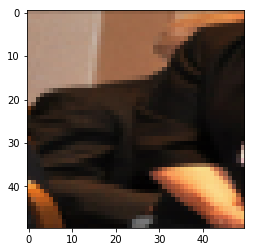

In [63]:
fig,ax = plt.subplots(1)
ax.imshow((images_train[1]))
print(bounded_annotations_train[1])

In [ ]:
strategies = ['stratified','most_frequent','prior','uniform']
for strat in strategies:
    clf = DummyClassifier(strategy=strat, random_state=42)
    clf.fit(images_train_stack, bounded_annotations_train)
    DummyClassifier(constant=None, random_state=42, strategy=strat)
    print(clf.score(images_val_stack, bounded_annotations_val))
    y_pred = clf.predict(images_val_stack)
    print("Accuracy:", accuracy_score(bounded_annotations_val, y_pred))
    print("Precision_weighted:", precision_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(bounded_annotations_val, y_pred))

In [150]:
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.02,train_size=0.02, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)

579329
521922
387243
458475
92614
336078
318857
492408
233500


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


197525
94087
322827
112272
415533
165248
534511
554036
132196
347319
184157
140067
135149
559752
185906
412190
529136
272807
20052
369701
422255
272426
579735
531201
298464
520448
81966
566043
215315
2560
107353
279803
548936
129563
181468
168717
376136
115226
161996
223165
156296
300024
259060
60699
12661
546046
204529
432053
144747
388865
576397
49143
258460
473709
520321
413122
319649
284964
22240
371348
351235
153202
16448
39548
98116
462512
244683
18309
528471
77001
369860
376165
437660
297387
517584
462164
278732
82776
322847
25470
401041
436932
174526
556342
261696
406040
188009
7220
64454
393384
193047
65643
140481
357771
128838
20917
368397
577513
48428
477847
426975
560748
79645
227520
329748
121565
24380
580082
324603
556855
441507
57676
423638
269160
363621
226354
549876
377300
438255
211033
341335
64744
213207
95273
60678
126770
284014
469768
469853
370441
229159
475056
78633
219474
100396
540342
237861
351841
53793
151732
351968
126907
199029
517251
263270
204015
431613
1

462792
579382
531309
475493
418172
124367
204705
479068
231593
139948
459463
260871
238290
383309
560217
491753
576413
556744
53608
304391
318311
550246
167346
486567
420402
389352
517931
38920
175530
309541
170687
433825
104953
324682
96475
442686
180099
498079
542638
175477
361738
555034
106123
112697
406646
573874
101978
441952
84422
14487
413026
293949
437356
324427
185513
358065
311208
3685
312574
382653
474955
189539
287233
572550
189836
111646
452488
51720
145891
362604
193808
558900
298481
60040
407135
467411
238729
438055
558455
176085
338704
561635
486555
131816
33009
222245
222245
467746
175112
140074
579267
531958
526877
224677
468068
178625
186599
399878
304483
496799
377422
233210
549622
238589
306342
79513
51606
538848
538214
115950
374371
215070
400305
338086
225313
410603
577884
149060
66862
101643
144497
398331
513533
197406
537807
226162
194738
264504
481851
18605
550133
401229
365358
505713
6602
333654
213117
199639
449201
111606
12810
549563
122983
15374
150192
288

559755
288204
260929
517246
48742
184820
426994
439107
225104
380034
470718
555639
553975
130512
506710
441327
428381
201501
203881
16578
32607
365314
108451
102976
186157
295798
565886
58171
102256
86412
524352
300678
295461
361618
107129
380325
8677
545549
234234
60774
434045
14824
477392
143168
19828
262001
562382
508561
29473
190334
54563
100975
203388
375099
236141
474161
209890
112124
56145
92420
5237
311522
407522
475482
72256
574784
122750
545791
57697
575206
481920
258397
24411
467245
8494
380931
330894
150082
338943
324567
113199
482472
541463
512156
564573
57999
235721
80215
329766
268023
400343
129546
203612
485876
109117
255941
316336
113970
487693
346926
332537
358767
499027
217113
57745
97056
167623
120103
255554
376024
524325
47249
333580
132573
219488
169360
536932
140352
13944
362117
81057
4404
53643
380280
407413
581857
132850
69866
482699
294102
192929
472439
313709
68987
275631
26190
412880
282558
312143
399258
142557
1397
553736
257102
203433
476965
114027
463851


178742
506750
288828
205571
512390
275608
22411
545257
191592
297227
236184
127235
23874
439765
41398
118794
29014
443393
385701
347354
575305
195151
390000
108140
215511
522862
316699
94687
337353
557122
191962
369357
421315
53608
569610
16123
51750
183790
225508
475978
292537
107376
399680
462849
301362
567990
457797
246528
375108
240955
423855
203269
152701
97211
81485
77304
318032
112272
171758
416473
84422
469798
70975
223404
347319
408099
464652
229105
254129
97458
151830
238994
442874
510359
205917
547388
426022
90258
573954
269927
14209
355075
73889
481648
5094
39686
291016
266168
392825
291504
246160
280377
104711
62203
517182
270790
482201
4702
502593
333066
219958
292146
444487
217268
148217
559995
326508
238227
153727
326336
59167
147211
83508
198057
16273
302213
59141
219810
199639
98510
513466
28319
85112
577928
158996
447041
138435
246434
72971
163239
475007
357036
376524
157480
500649
499138
324104
385316
400818
56845
459824
351352
33669
185004
493355
549409
307534
3892

393094
378415
151364
339250
43256
222209
208868
467334
411441
436195
106917
439333
383569
168822
505962
320523
43876
381395
144246
551441
366016
178533
9919
417848
66487
494055
369823
262031
178198
484494
404486
251723
287575
577613
351210
171950
388960
422215
60684
330726
390073
391065
502153
320308
378229
504488
52131
64602
198611
464546
444312
444794
124577
523682
275130
136886
143764
141342
351260
472506
134986
110984
8920
77195
329055
561864
547528
419445
376384
54806
181929
290566
209563
133845
288733
518667
469605
533011
352188
537258
159021
256184
312786
539449
192104
95812
105564
102473
104999
428785
296009
132793
140909
116831
503227
367011
123411
224776
427548
132698
297570
28523
186552
97844
17450
337232
309163
468841
143367
217991
255179
167713
280177
111922
128732
310714
232658
201596
116088
487783
221895
116123
192450
401071
315229
563129
310042
323558
43750
351126
155047
167743
550944
99388
567287
95185
468894
498786
113142
461445
200351
14312
41669
366103
406055
177277

274559
91926
545710
539977
563280
331871
50323
210909
536938
2639
362745
273046
310645
330863
76101
324923
557659
297997
561168
426824
370996
316075
133609
311208
164485
333152
381199
556954
564302
263618
349793
512940
60874
454683
351595
336919
498645
478636
372989
464898
151893
576012
143563
247789
302551
425418
154869
532535
313494
555625
500761
405210
360053
380305
231368
309412
291780
202906
562015
237337
336063
241408
435161
307299
388900
398130
375815
509700
390328
298146
228478
111422
51390
170512
349621
307174
392180
101559
464833
79367
536368
413122
211686
220688
333868
216674
168215
552561
172406
365218
301537
565040
42416
463616
485683
475561
274763
571903
186344
79076
336230
450832
409414
261071
529427
145911
478072
472266
251897
301764
72769
156849
334616
545950
407596
522338
389159
133543
60678
372748
271466
181661
471799
508665
389660
260138
370613
384659
175801
552432
253219
499700
159225
96177
37863
321938
537844
536806
35397
411399
210672
199188
494424
488747
491430


101330
254701
73885
571048
319136
293061
504154
555982
313334
495403
390002
62337
280898
329892
1958
284018
276531
504284
282883
319260
80969
44734
579312
358717
442043
447688
355737
102976
317022
234949
88282
206203
340157
364251
566536
235518
255898
517049
85777
322695
522755
560898
74429
276895
66156
373648
566427
238604
287831
167525
248948
514650
574116
156986
550237
246298
253221
334714
223091
374001
359722
361119
977
526165
510813
342010
144242
485267
368468
127400
137984
260741
145264
350363
67446
435161
296344
159993
252084
163506
523564
308610
220795
91952
355647
75458
342592
370145
317153
392851
138186
304150
131118
161056
513704
562862
410707
579255
412566
544968
286129
314526
274376
141851
441062
87813
338719
122724
293577
443634
319098
406710
382924
532239
561624
53170
42529
196049
363346
496053
551956
225372
369296
26784
295193
123837
469661
170513
227724
65896
8429
305224
264821
322472
198323
239436
275339
323705
455672
166201
514558
49542
81576
562394
33930
215374
1518

135989
256824
303959
229874
252779
165100
557187
458475
237781
257558
204867
578734
537475
68377
4859
88068
450330
116334
335824
547797
327157
581857
324103
333337
193479
193476
128320
138961
510729
439057
524736
271996
140883
212248
113851
297019
56859
567091
481553
124473
358200
125120
258853
63677
345432
244416
113762
178789
83332
179823
487476
19845
458160
542638
72354
408243
142570
297417
269561
237111
313364
578215
41079
151570
435869
95989
58766
210584
42481
410190
412720
525933
44540
367125
292752
170130
201939
286688
457822
543665
196899
89425
503378
258888
510399
198437
20707
289510
251974
55874
419145
144246
328036
365140
260656
274562
318333
571677
372199
171158
118543
581198
178951
422810
321991
224734
566642
30395
199256
12544
462944
59252
385804
283720
390310
363541
141386
78087
350299
297173
337621
398157
403873
31943
181443
502148
136184
400204
122250
575476
227652
380192
561910
288164
181468
342109
535460
419001
219663
141304
188587
244383
363455
52986
460915
315269
2

479390
143382
534094
173978
18557
72509
256308
333805
188130
381193
397445
155344
404828
236936
97283
286254
182997
403258
100722
183642
266353
285550
104711
454636
181837
97595
182384
376623
328853
565740
549236
349530
477259
185334
234916
163128
99728
354616
514006
391509
291201
349140
295399
538407
409220
104809
567972
335109
473631
214563
560969
72233
387887
215889
16758
548662
490490
21330
528493
221494
361592
99046
456724
176479
157049
310131
126734
554982
154790
547542
123643
367146
270784
568311
199640
11461
106964
204606
225923
103430
175162
579229
27742
476198
179476
187855
441546
259240
529910
30779
43163
378912
165571
125380
232500
369000
565595
332578
376719
546824
131703
341941
328751
288610
227127
124428
129485
136015
40407
105697
10058
462878
420750
53670
69117
241390
10784
177658
271447
322691
162372
143559
132571
219064
59596
17180
248564
145736
490723
57870
224303
443432
422774
434859
365430
56753
211457
266383
374904
4578
289341
528994
125814
156608
93756
266910
380

563839
92746
355657
244549
301769
212627
35552
24571
45230
399876
115893
224759
470305
536103
43251
453938
231782
120385
222926
430159
380034
251008
547315
429448
449510
349690
92710
292537
84427
425622
429236
127643
574001
464430
155340
260637
494351
294074
555015
561891
552502
265938
157981
165587
24625
68287
119604
281502
404502
191477
102667
251448
502862
81971
570574
310499
200447
427137
558542
268516
469921
55947
145645
463969
119594
349153
233143
322768
113982
562936
58153
12728
221427
42947
391481
495149
463616
402448
129510
409216
17100
342639
1403
518207
571773
380192
55237
341457
430817
483090
21531
334011
319899
41840
577838
345302
158362
575711
505861
103234
81784
331326
519723
249251
107843
129921
218116
479608
540229
93519
438496
519993
441965
65163
27710
509800
110500
574645
300407
477658
22071
54749
556512
319990
37953
486257
298987
418115
9185
383888
315322
411243
275088
259677
436932
96901
137250
474817
49283
542866
517049
254712
152096
350013
289255
299920
256896
31

537379
161463
511829
366139
90570
283912
318476
404395
295575
64267
459716
218037
255849
217143
286619
234948
190387
250833
156090
322101
151245
427389
534789
109011
363548
329831
320957
417476
37479
510290
319818
402420
21253
81676
455037
539631
150440
576817
228744
391367
288921
568174
273606
145645
225848
535010
363554
435716
157476
984
493845
324052
234468
45422
225228
114326
151732
498730
580216
576593
334220
129247
408981
113211
443432
329476
11591
146053
98233
21212
115359
111606
29601
542552
451550
255329
252599
309568
154995
417744
353000
8063
554524
380665
336935
492040
382107
542181
249287
295394
319783
501571
332706
141065
511869
211552
454112
184835
267028
137075
59571
388217
405964
271469
458025
580510
546952
504299
400190
109838
61697
478485
38558
33361
338651
107903
272255
207454
402281
286550
419610
580414
14938
347111
502112
307966
569341
417797
41997
267260
507535
274337
454273
545237
129926
365469
225071
183504
295778
251347
514191
46068
243373
379914
552561
175669


565264
145311
91926
535010
415794
254079
447714
328217
161356
538609
433874
488962
299426
227552
322870
387514
344622
47347
221889
455651
508665
179462
334187
292001
574248
538916
62864
380284
287029
336369
142269
455169
44437
371313
526204
107586
218595
520873
454502
23914
26506
512292
63797
37771
258240
153888
437900
381334
399922
365008
321234
552962
414284
216406
353358
317102
302680
538701
266697
302588
437034
458664
208414
94420
164908
425342
150049
36907
313579
557122
405278
443653
513461
509706
394764
547509
485649
471900
361303
288905
211830
464030
575417
545710
456975
9095
42860
9615
389351
195755
65610
338760
522891
285249
6941
575119
566427
458249
20651
104661
58834
302511
183611
165930
351221
204014
345283
213436
256869
426191
278214
418394
259000
306109
333309
258727
530745
31590
79459
311715
268441
473765
444274
293169
322002
243384
505903
576996
388696
493251
95034
22071
231532
76571
506582
26913
340545
365340
297135
58283
575863
385863
471558
548933
484528
31765
563746

142418
404865
544884
396179
366470
339454
488632
161381
493148
161356
327209
330914
126814
363346
182181
257807
411061
501571
86267
449414
483833
347483
515206
26498
421534
219355
503887
567396
425112
116831
251523
307174
165571
118413
224395
434190
550875
100821
230572
83155
154083
331863
379735
499500
168992
301432
187282
196418
9488
378906
136064
64681
359704
81474
414999
445761
205159
399191
169638
563584
408206
445323
33612
2211
519157
478368
147753
560325
34397
87450
223838
7307
425148
205181
23812
83931
122460
170803
353288
225113
534751
529667
514839
474069
196817
130318
561673
355133
215858
12497
402083
260564
158718
265412
326493
7627
260512
380306
118697
233471
365231
18041
89052
218836
455427
287854
505058
326531
534048
15394
547960
133113
534000
404869
168994
370634
321182
478145
501710
431973
580191
567085
418198
542036
44911
325806
498372
303076
51390
466035
335722
556833
118219
356384
532286
386497
387685
128175
340758
435931
565777
200241
222994
318261
89103
194346
664

110092
385674
324488
514006
580822
285131
431899
65420
107776
407220
530683
510617
435267
18370
83014
164044
387977
325981
152701
386532
555183
465294
452535
324428
464415
332109
536402
88540
525944
99628
475664
334197
390160
11831
208055
502606
261648
406445
306454
569177
281327
331982
120537
191869
288513
522947
425114
316194
498421
554729
494579
396372
396247
60952
576155
52250
165773
238641
63724
48974
60774
36318
392584
180087
28314
196817
342807
64722
236316
386239
249348
105728
318574
320892
394182
342585
506414
233245
445556
108896
209304
306030
206066
379350
558824
258129
219978
140581
99727
27516
135959
411554
534001
186799
563364
13121
138571
22741
317237
220096
40730
464937
4608
277145
81845
354380
255418
113212
124174
182454
70804
73387
267055
352295
546147
465813
282934
401400
99676
243211
291947
44594
367869
572179
360751
536595
354846
458677
53793
287062
267284
21095
103059
515390
62348
479590
540457
278923
436108
189951
88744
306925
376559
79106
255139
407685
574563
50

569017
113982
482940
516990
401518
66124
213342
171581
559752
211843
460722
345145
148343
32606
116851
284599
304694
126869
486123
321588
365527
539099
258249
395920
239478
319795
456790
468068
289490
80654
142400
106748
379434
12428
294223
165531
122867
251111
452005
448653
344793
465814
74201
46737
39548
358523
440810
481171
84128
268901
47981
456522
371796
30001
574443
312015
308758
197155
52897
261280
51706
102576
213826
173019
526896
450621
40304
186268
247181
223315
500941
438671
295263
382695
52131
213790
130908
567161
30488
415670
105820
108599
532014
98550
377110
227743
80654
419062
245938
296777
580277
503479
225113
347787
143006
61779
20707
296540
232963
90566
475313
141834
324413
487679
397315
426118
258882
334723
229318
205781
101234
139944
571157
176736
279034
288943
379211
42472
555833
236568
305093
329077
575835
542651
313131
460134
276017
184626
214792
48271
556956
572252
238589
113276
47652
466772
398036
243071
437522
451983
335984
64704
320432
35817
376559
564157
295

38838
415305
340700
108575
270275
506617
515196
390675
80406
286092
167033
26438
471283
153140
286247
201342
417607
111705
82600
237721
13249
193254
510012
365624
459800
182956
447863
142767
536179
231500
282485
458592
198202
310131
311776
385272
511218
546211
268533
536368
394896
516106
460231
314390
145606
249226
386253
75027
399095
50772
251439
469330
143616
553077
493626
225241
333654
238858
22149
56868
466822
87450
493692
580212
145503
499309
406977
37527
516168
177840
180682
533638
127729
492711
114648
283170
88185
34752
288548
393268
200625
72023
462062
352758
324950
393544
27330
508565
218546
89602
332925
258077
422283
78827
557875
473003
140724
178774
327181
80363
91778
381758
138192
468588
57676
68717
477442
224349
542658
291889
362745
417763
77602
83102
255808
429038
509364
146972
456753
129201
402359
384085
535676
37074
327205
104541
178839
429015
326639
52846
26900
142262
41742
95185
373360
446471
70459
47729
221937
432627
396927
376029
517453
408239
158794
203252
494856
4

5313
159929
61729
522827
36903
443490
222983
434004
560997
322127
11041
18244
224242
126814
413892
131976
310341
473095
511160
253674
505927
544274
274632
349919
244804
356108
400603
346433
281498
395684
414639
50178
463814
476341
214087
176263
18934
580586
481402
66005
60567
20757
376868
436038
467432
154343
95789
368811
285893
250278
464081
553366
123719
479214
333775
5483
533888
524790
334600
131915
198611
470062
99988
437816
332115
11496
574915
290705
197585
135759
37716
250250
95676
62558
578513
448064
508343
576702
418315
560137
57870
475258
432527
321717
239144
297872
147674
138405
22193
306128
152815
139157
14791
46242
5688
336840
183450
464888
371965
114705
69583
298573
549928
93838
432212
457638
170428
403981
448504
454291
92869
326504
502223
420900
119423
71631
243219
80821
173316
322990
206492
259527
463044
344482
209433
214067
9
120247
520800
553202
51302
396420
41516
84479
343484
191191
476681
130402
88538
70265
178791
201431
304919
475763
420765
489103
495233
183653
3514

307153
121350
387329
569356
371166
178443
194161
81166
96973
139456
266618
268586
454422
299712
498786
188693
548175
25833
22871
427803
280788
450910
447065
74127
571964
16383
561006
252664
12251
524531
91310
4694
402844
106199
28517
189318
379193
470189
541338
414162
73226
174623
472041
202829
236556
210542
326496
53405
37160
95409
445397
533602
381485
366517
17590
26833
16616
368397
571880
432247
192780
192234
489103
484405
279025
418736
85846
71330
270500
274130
144203
284960
288941
459763
441605
361373
370479
508741
169907
408838
496942
86715
248779
221856
304939
560009
45026
267388
76578
169732
248830
485367
292554
210728
209176
372774
459471
303608
263212
523466
348279
407348
326770
465005
284246
578619
145911
437184
456736
506283
438795
472872
519993
151327
303735
230572
91744
87378
235953
228461
487060
262691
214445
182634
222191
173966
195137
543805
328951
221803
104249
427789
356213
124914
521210
374725
260970
504560
206937
563391
473612
23676
199570
6753
330429
405897
414548

132778
388662
74316
321181
51359
523536
486947
457904
446974
396030
276621
363764
519939
329766
496902
27241
235534
347016
395340
572456
31922
426403
55651
186799
393924
458522
567342
138166
142280
377056
10318
185436
193659
238795
314537
471008
535460
240247
334441
151483
552880
333247
259557
578737
311065
493576
205547
72746
253710
229357
173149
551983
428320
205916
19394
7583
38257
450168
391237
218037
503385
81845
488980
368717
300374
58674
405543
388824
89571
504257
270475
52497
143958
579938
202168
557283
524068
366577
151364
461998
357728
60350
209304
310085
377056
34097
83730
69700
192852
512351
76681
467076
323421
160014
424110
62552
212523
381093
176038
364169
92559
370136
455322
508885
287659
61832
345265
362438
428345
159409
256815
157860
393140
110204
9919
384967
95501
516273
414202
459203
108566
553800
521644
391456
400702
367990
367337
515803
370461
255425
475578
180987
475763
27777
249620
455400
115392
127809
63662
166750
367005
446937
336267
466035
270715
55317
396927


412190
61209
114326
530758
310091
232047
448174
254418
545022
139165
64008
424797
381556
193062
234745
114880
529389
227982
282899
270198
511734
442277
279947
32455
443940
445327
64802
381194
319260
64202
62558
539797
281567
273641
543930
520471
43411
399122
189405
580277
1204
215881
56786
441327
321852
396534
156802
497633
39083
256603
369433
561251
326684
501571
263784
411541
389292
305215
68231
110459
55169
317153
473575
404578
264821
177666
18627
246342
146186
101713
273250
147303
96208
479707
534796
63893
459600
316581
515457
385307
384775
189561
494415
101140
233613
509484
414202
184889
335093
325530
135815
541580
2575
449904
115345
497592
492302
454796
93424
529490
219591
69308
428477
283913
201940
520978
430281
276639
128421
282198
49382
23996
469921
381139
291658
337621
532128
196460
34377
4244
489469
251167
471470
4065
475743
462512
200476
194738
354248
321679
8520
124914
410190
352192
529133
55303
434319
65400
432914
491346
377732
558142
574648
403913
415235
29602
319576
415

132038
289490
521386
467858
6562
492292
333555
26801
245797
401608
566785
282131
538640
394186
42553
492684
536494
15486
7735
424915
576780
455408
441449
161510
200320
49363
56364
15069
367856
403221
49884
37160
73226
76985
385522
145189
122939
141710
182502
233672
373880
493407
562973
158897
498649
256539
218711
197212
563559
278913


In [159]:
print(images_train.shape)
print(images_train.shape[0])
dataset_size = images_train.shape[0]
TwoDim_dataset = images_train.reshape(dataset_size,-1)

(12098, 50, 50, 3)
12098


In [218]:
tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)

In [160]:
enn = EditedNearestNeighbours()
X_res_tm, y_res_tm = enn.fit_resample(TwoDim_dataset, bounded_annotations_train)

KeyboardInterrupt: 

In [ ]:
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(TwoDim_dataset, bounded_annotations_train)

In [130]:
sm = SMOTE(random_state=42)
X_res_sm, y_res_sm = sm.fit_sample(TwoDim_dataset, bounded_annotations_train)
#X_res, y_res = sm.fit_sample(images_train_stack.reshape(images_bboxes_equal[1].shape[0], -1), bounded_annotations_train)

KeyboardInterrupt: 

In [134]:
#x_res_3d = X_res.reshape(X_res.shape[0], 104, 107)
#x_res_3d = X_res_ada.reshape(X_res_ada.shape[0], 50, 50, 1)
x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50, 3)


In [137]:
print(x_res_3d.shape)
print(y_res_tm.shape)
print(y_res_tm)

(78, 50, 50, 3)
(78,)
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 37 37 37 37 37 37 38 38 38 38 38 38 55 55 55 57 57 57
 57 62 84 84 84 89]


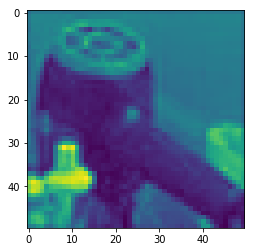

In [183]:
fig,ax = plt.subplots(1)
ax.imshow((x_res_3d[20057]))


In [43]:
path = "data/train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)
train_annotations = train["annotations"]
del train

bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.03,train_size=0.03, random_state=42)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)
joblib.dump(value=images_train, filename='outputs/images_trainrand0,03.npy')
joblib.dump(value=images_val, filename='outputs/images_valrand0,03.npy')
joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_rand0,03.npy')
joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_rand0,03.npy')



249882
283867
480208
65280
184211
447437


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


176194
542174
54354
577685
382118
429319
226597
569024
264930
431510
350013
70296
266217
538640
232862
356015
409120
17967
18584
545929
333424
5482
444627
558092
550396
255669
241025
559497
264304
570628
318468
310315
112882
271157
205620
541797
252599
343307
271136
330256
365544
492078
460030
16980
502485
508724
408854
298458
301373
334892
224445
549447
475947
244549
253834
329748
5962
426915
134562
247545
347736
163723
23275
235081
231401
435929
164657
565641
43383
521204
250677
42278
455166
188380
434859
382589
51359
304889
427852
221004
59351
523484
224781
209662
174526
372480
303788
330916
510371
173185
247475
438196
107753
114880
485180
557825
160535
330922
200280
395198
81971
136343
300232
415131
514556
177922
428117
576457
97391
311416
166489
405897
533477
141386
183445
102942
185358
294138
373697
389715
259417
55695
369207
335351
244088
457871
573954
550842
50106
160615
260817
540162
175912
569356
92280
78509
37527
444644
567665
436288
156709
577481
540082
90498
201640
430346


150037
21469
91852
345388
260138
195368
1777
162828
99165
125365
312504
43780
250737
376757
551438
88025
300014
318967
157288
152096
486309
223091
529886
562325
249764
395409
302538
231963
337146
325523
205785
219229
139595
211843
40874
471945
480532
207875
222964
511200
108606
83624
275969
290370
391351
419501
388020
250744
287953
301200
358176
64492
157105
394330
149280
166201
517652
43001
471515
512140
322064
118330
51799
425721
174470
573670
323489
390856
205023
21268
373400
230046
155995
544561
510260
322953
324567
47281
461252
508855
264388
43171
200642
335492
55410
482049
122950
289861
194551
139469
566368
413374
303213
487286
476965
432956
322321
113152
210604
427618
255604
392664
100331
440778
289514
405058
376132
224379
117366
346274
411937
392394
564063
174098
212429
28307
437778
54218
459585
326966
36639
7945
480948
311562
126432
456285
250630
38862
53900
393576
12488
497819
454406
63818
71
498022
193148
304391
242193
48319
139068
137250
487286
231705
9768
305247
415589
336

152844
340610
129871
429644
242163
474446
332203
72233
145502
276811
444997
139151
2209
68685
222703
357989
324232
255226
248066
454940
527720
35322
29327
407065
268192
250737
177954
195124
406855
285170
220518
411061
75334
368661
394436
116155
455419
333461
416165
48670
100958
390423
26133
167996
45785
128709
401059
21343
82220
296876
302349
76988
543716
462110
38933
87334
431400
409628
543378
164487
213095
508245
511200
87598
20104
73549
479332
111933
55575
23134
297811
459659
89340
506750
209304
160142
560135
102473
445249
73434
116100
41398
268067
448099
470539
426246
399162
296894
257946
64111
549199
6352
461847
485187
222506
505343
70297
174188
79170
323558
262307
261381
434328
150276
73513
299786
543272
441461
518555
172665
433305
533633
92686
277401
98290
458756
144018
567665
203926
166650
421534
370466
348907
218775
10281
366417
488792
240813
348609
381828
173749
412806
394964
36748
72505
176925
518769
261710
185587
471113
258073
517326
102540
178742
506927
314750
347189
44635

77745
67331
540495
167229
245697
75925
159929
80406
551922
457274
370130
57375
150671
99539
397987
64588
194273
319649
317557
492851
562253
373373
1488
494240
383805
446
161367
30395
142276
150053
123180
90679
463546
126433
115372
156512
580414
206700
109277
563280
75361
106835
178971
22612
304095
111635
63230
406062
50945
118682
298350
509620
319731
457660
337047
186525
326377
368818
97861
332867
22806
11576
43270
413676
411851
490940
112053
308758
224778
377598
257669
72111
415944
477622
346492
466432
563435
202226
308100
69768
237081
55130
336357
298008
579909
509023
204962
180765
232467
523306
439991
408829
193495
467145
323646
306219
23695
571541
67565
97878
475804
571366
365123
39570
100142
291797
497030
279373
468313
554698
461208
537258
517115
51199
359825
113513
543275
431808
354932
327202
329737
290719
177516
580579
95081
542643
563645
174375
209005
157215
113893
409678
49248
581637
569242
430086
489983
76636
67974
150185
184684
264197
330220
482989
458143
450894
373120
57035

408266
537878
536145
212025
197705
277613
406807
392664
190942
570968
296648
455117
6247
532711
550028
549114
4843
111972
538007
425912
519369
456709
467300
347263
138915
275037
462709
509321
286016
271701
209176
279733
333796
321448
53643
408506
554104
530216
315165
284338
126126
577520
190353
85998
43719
91952
115156
494749
75726
459310
141947
5345
54083
551316
233642
34624
572745
507889
302055
39987
572500
493245
95559
427180
273035
500991
187432
18529
446307
309368
278989
498241
312506
393036
10877
396010
326335
505962
223718
308548
29942
183395
401707
240952
449781
338833
384563
63866
552167
140308
458413
311706
493504
470147
509608
105589
112226
170962
505160
392083
437676
275556
226976
47735
73434
382342
480712
485526
266032
114617
361051
343748
346876
356396
72453
424907
207455
476893
76912
6428
560309
160573
428440
278055
370136
434156
242982
121857
79883
295461
145994
511751
389382
336078
11159
516624
393576
538308
74232
518510
498786
498588
339793
435326
576089
519685
354842

559484
270536
185051
196460
219454
237031
265796
526295
249983
212856
336313
197593
64170
415663
522244
248839
493131
536041
488634
179823
103528
327262
506927
394214
307940
360535
313927
209246
423643
579045
524375
301605
50563
520654
538809
409184
508855
216091
250991
94300
301431
65457
421202
339690
52992
478092
173801
22226
438375
250067
469851
52299
126126
22484
552502
546940
39548
202010
416622
536663
386796
410972
37478
482161
501358
358576
254129
526362
5620
292116
362140
106003
200619
433221
512634
418586
483305
221478
519939
530002
296477
8114
110000
458202
392924
316238
74183
45617
223203
525223
174399
412222
52250
399097
554750
230227
355248
546695
116074
356868
164842
276332
138189
408029
413382
495043
12283
54130
308422
415370
404565
151581
401400
523735
447615
73187
252998
494785
60982
562335
47333
361755
93535
361059
10229
444893
117349
459706
59174
536935
386603
137212
86221
140067
451160
355194
295642
116026
389498
61354
68430
210728
576550
349827
170390
121363
545274

133281
423330
378848
9025
60812
68947
146469
368087
236611
242378
103554
45148
61463
311208
236897
59388
545334
530289
96713
168818
62292
305853
94925
80520
262001
28318
345145
354771
516034
370802
274509
75339
220736
105444
97458
202762
449847
125541
495059
54594
494548
541580
197636
478683
494785
7145
507136
515019
444018
559949
6233
287299
357967
27534
563319
572814
549347
266071
103699
38122
52270
158515
65343
276491
276894
120088
286166
197322
4289
437435
419632
579716
5688
265701
530729
341621
369355
308963
335212
75587
556823
73022
439057
226046
43773
137778
122913
409897
184751
100311
153923
16060
526887
492580
325932
14791
562819
369610
491888
284846
442732
447849
255203
342589
406792
208008
528712
50518
222351
352389
369609
458772
387392
513210
203975
43895
457686
386724
419904
371758
532181
258391
351159
249817
338242
27888
87616
310649
424596
150942
547767
54013
396260
30888
441734
250941
201939
245780
462925
369504
132019
16359
482234
538701
435322
486250
252105
561424
267

268681
17799
302289
125452
165350
347051
246071
516189
526362
137250
259188
36166
395740
251121
155040
578683
394197
351013
429052
366665
373664
536760
369784
357272
132607
113521
262454
329035
13800
571842
164772
429038
363656
330909
444644
460730
133791
483757
391361
48665
322002
527267
516289
159175
40248
347167
543830
256190
24169
268583
239144
565286
53720
129129
207463
499237
540567
286181
185991
444487
474760
51643
256869
147710
326757
30133
65407
461657
370124
387299
176721
255714
329179
362284
349905
59454
370661
451032
146907
45999
72902
220896
557191
212321
475674
527344
35571
356916
84314
541496
191805
105933
169576
548742
550000
445388
15110
529887
376457
556067
481841
217448
426903
191042
405515
14337
267555
439185
573973
542060
498786
460038
398331
140180
360313
420396
448317
486513
307240
421145
559262
286348
280913
351818
420236
16665
84238
311324
65163
20251
102655
78314
535358
57828
269260
354699
105472
955
34061
29189
164081
57088
422063
532866
491833
64800
470618
2

436092
534000
159398
497393
120644
562176
150185
567037
18418
272176
392758
172040
457660
476575
428485
348595
548742
181595
40351
558387
286930
467723
269738
146623
512662
442785
323267
56293
579053
482515
192671
374878
144018
204021
456602
35367
472506
242203
222358
492183
443479
564681
564072
274019
80391
560691
317216
324871
3999
41826
363548
206349
489735
295887
233104
119621
455366
482505
314558
447150
89093
107072
361746
183244
207862
405991
399148
253777
298459
314558
390883
70566
191277
286751
549928
294957
451196
56845
104891
324513
54194
179914
118848
265253
523154
294688
163474
244983
423909
357424
25994
481178
147772
122137
6936
48267
425114
301431
43150
224414
560655
416648
57866
360283
492495
566785
204683
299974
109896
469024
477451
390474
103510
329762
196797
124765
101749
83079
559875
370802
122093
20168
459110
436802
580414
364380
572024
492711
141348
258727
551303
113617
36289
141304
83986
511345
85657
271862
549127
363750
379766
231601
64093
435554
63556
486899
104

484758
424991
554541
23096
238200
203454
492292
131107
568378
502485
465333
111525
52983
143870
163358
526987
79869
276089
272100
441460
543684
292533
393384
330785
65979
338134
269504
560495
258397
476160
341768
221615
124532
270440
79191
468588
178901
476151
512449
412687
127932
570477
92753
53670
31913
507665
543378
541027
225477
560571
35547
296648
520553
488940
114240
389692
472027
433334
190796
293647
229969
399009
475902
530869
128116
384499
117770
61535
45314
325821
209092
451594
549810
302289
11075
532398
455505
545806
380351
521775
554464
195992
132946
157105
204889
57515
249362
304221
9542
181155
5260
465813
80044
138290
134770
243558
249688
531253
480107
71828
109858
546499
377044
192642
530551
521998
105100
276009
567423
386979
145856
387561
505884
187803
287094
504554
263896
142393
451597
510552
12650
335144
465776
228611
346930
460339
378720
549172
124840
32629
406420
406753
17877
143348
223366
121622
145006
185177
503875
171339
129712
400919
221012
34038
263744
347217
7

716
532219
44341
437073
496256
157105
218985
90582
533917
460780
578843
527082
328847
225604
213530
448698
103504
71232
409126
215493
451727
345145
110087
490712
1906
547308
347403
129888
131172
40844
143348
14862
282843
548889
6981
123975
722
457383
46580
53095
49123
280473
567858
115365
229559
211918
133937
553388
233437
271171
86620
533957
331222
96339
347463
179650
231019
52219
308758
262673
424278
446899
569989
283257
427435
50462
395340
322268
431024
397605
455311
553267
532577
379508
276610
472392
478410
186145
552810
361256
292543
516990
417700
123127
123753
413164
94293
239520
263418
393985
7251
248150
424821
181176
444664
140585
181711
429606
98864
150385
398571
288649
489520
304694
530670
382631
282131
283129
225088
191754
502884
506183
221909
42427
120127
196851
239532
354003
499636
31788
138387
470333
211810
188440
329476
475664
268306
569550
117366
256877
419276
115359
141160
103726
314844
210450
280187
270284
420747
446628
17839
286248
234978
158195
132500
139887
117275


53587
492715
405579
54738
35004
262670
97861
562777
506342
566839
468801
47954
152529
82796
450136
92096
155177
536286
516106
501635
432428
490057
419232
536900
40205
318959
110536
401703
224522
312476
520176
444986
420396
427586
502862
268711
223499
275630
161234
509691
371965
452750
367285
8086
243504
133166
375947
369199
323475
285260
565002
134924
314837
450281
66566
321702
369326
490723
517882
400845
249145
573732
404322
339130
331998
265586
378533
125720
484742
156534
120335
300950
206387
581744
118895
37015
382400
11505
463342
77095
206583
425127
296417
310085
238729
14938
380252
141586
147779
258397
157186
148583
336901
215380
142570
241421
210642
97492
79453
396412
555808
139789
109088
11948
523689
132841
18529
255017
353316
162557
515106
494985
275613
124593
441461
102202
474556
91696
177289
130287
212532
417487
73195
123336
57744
461917
342203
571342
338971
73824
32134
552199
95659
176435
33687
553682
532137
103380
261887
580026
470147
495789
162753
144000
158028
193953
4574

463739
534094
550944
256322
361291
178389
355950
122802
538821
444644
138536
354770
210079
516265
520094
291973
314048
488689
154354
171158
262172
123749
252212
479501
36841
524377
117796
499611
44729
543378
580082
497847
209851
438061
396143
11630
21528
252998
42418
515229
158353
424979
315322
431933
424459
398609
185229
54375
380591
289058
72809
112801
386341
40056
460143
444794
546105
502916
21254
553975
133166
574812
178000
508429
479168
493880
129133
27701
229583
145503
274039
393037
462798
20971
368876
23996
450975
365206
84096
131812
56928
319863
347509
158451
174188
424459
491400
442811
572354
542231
532543
241294
524520
458397
255971
471658
382386
170483
246009
61819
116737
506971
381928
141952
495124
253675
474601
882
407413
108505
338012
438844
193327
175669
174930
58403
291018
206155
255335
239596
360283
344040
70307
33471
429745
548153
74273
93649
270999
385972
421325
224396
384422
14477
376983
440381
137892
108164
300806
479387
294912
303484
365858
4489
129781
140346
8877

449808
530966
20434
451024
511963
520036
579446
576518
496440
36221
43892
141101
500273
139285
577125
341212
265833
71845
347754
365943
504566
154704
271633
498022
153604
15269
206363
444571
197264
277613
132954
173284
411603
473575
543182
99135
478198
537608
145502
64339
338087
221665
8781
132954
294416
217046
339978
358200
70804
370162
457659
336397
237210
471504
545987
171564
28231
115087
61498
191249
576187
531998
567847
254476
488683
268826
560748
468493
119571
111673
278335
561624
311616
131450
287881
545525
525898
266334
379517
563645
282444
184820
469770
52037
38532
360071
471515
349319
56323
540890
511285
297765
172930
60043
140992
422939
148385
400218
158378
377518
82745
473500
370738
354248
264456
522110
465779
542365
437970
250574
172937
477442
220250
23413
95185
354305
404450
576155
418885
244461
173812
261485
541832
89005
523358
267022
271499
564443
532188
425380
372514
98760
246287
17096
22287
213389
401509
16578
306249
74917
186018
370235
304134
537367
574961
365284
386

400409
523876
281557
331588
122667
505343
571311
145856
143965
432286
103966
549166
273029
431820
441619
528566
357989
271447
488990
254800
558851
506576
142996
434118
478997
38923
408576
536641
452782
418085
224759
335477
242163
329134
296581
225088
31621
476060
50810
461494
244675
56676
498022
347048
538686
146582
273379
369156
81283
235281
227178
425917
183910
530211
287289
481807
272155
127006
42619
225230
258735
301238
387796
502089
273929
461098
27777
421648
178178
131211
520879
572505
57500
165945
138536
53900
509132
409063
536932
155942
60190
380453
475142
296009
279632
527337
448812
521632
86552
37514
338894
762
273548
460441
40940
456705
66246
295154
52250
360412
86435
299426
18370
547135
238589
108042
403135
289248
471113
159965
147442
473102
15379
26068
508299
355119
22863
239593
536855
369491
213535
309386
514650
521872
372748
160967
440074
302982
224733
9990
302250
360695
266043
552553
336195
354716
81555
158201
361359
336167
189810
383731
199432
111673
396412
267216
5021

271574
217531
397186
27237
30387
298468
537878
152269
270407
534716
73434
419679
2083
150942
41997
563592
192627
210932
317091
406250
432307
243787
28728
86825
523433
303703
563058
150969
155118
311251
11029
105998
302051
200879
191994
552330
355737
503170
499598
335359
523729
88155
188955
203818
219030
115619
567976
472108
203304
279775
468519
453523
256451
61732
170139
28560
385522
56510
139887
39272
170432
273716
311174
563297
551275
571351
67680
363764
220942
454003
495875
221289
61729
563584
76005
184805
213207
398071
260702
555921
237592
359535
480773
52208
580741
357015
189153
408099
377251
532062
59556
100128
69661
456155
177829
185258
81365
54086
78909
522129
537790
448839
109386
221948
254362
26359
500467
153380
432349
394880
77542
450716
82202
47879
227066
388353
246725
102357
205707
528642
328951
436662
307316
146751
262991
197525
268737
175855
349
347505
216899
56161
11426
445952
280508
340611
47372
159495
51630
294509
447639
302989
210395
69826
134818
272480
311899
168332

140693
380039
277096
552502
509210
292183
90218
556458
502179
576752
577358
478859
318637
376839
311522
265330
568369
208731
308653
37183
218715
319045
542431
15073
279693
416644
370963
311478
68445
320454
121792
455505
56677
485113
33068
53474
363525
256720
296706
544005
135499
265277
534959
14125
211788
51639
157202
577787
375815
344040
237685
339766
135242
130081
543171
306288
513795
331313
382731
396661
398615
245566
217487
202080
141366
209433
423966
537152
370851
397736
487903
181493
294199
483690
496613
176596
347505
405543
240944
224905
521709
142349
96897
134128
14938
364862
331203
328314
496747
379607
355571
340425
35741
311416
475130
19131
2907
427046
160573
130647
399042
525300
38380
103759
17877
352623
388149
21718
390969
127743
401369
310085
115018
309840
274559
410754
222755
531153
64377
440675
260991
14477
23737
221684
454514
317274
451278
468085
133403
55728
312182
204423
74127
425542
496039
573922
162735
371587
508722
551427
226232
396030
123282
432037
327841
248417
7

359691
370059
399750
327330
549002
333775
564580
278665
257013
349663
544690
557045
36221
111922
448503
375099
191338
572923
95486
6233
511650
50602
382517
34285
156812
403305
292898
417105
546218
71441
188587
66157
263651
172091
300488
167574
332821
499135
91948
202326
380148
177404
501995
74179
359168
476198
191321
248012
465169
559995
38487
416258
130914
208646
450800
211843
131589
73022
437292
231593
487340
275961
155097
451529
446688
324450
460353
390243
31375
25858
250372
225848
285810
201929
150480
80553
518555
461099
231993
235446
345644
297159
210728
495247
307869
536252
141166
362151
94459
270723
14472
303650
437073
276639
294549
564185
337104
2782
3514
226559
115117
254845
438091
186121
157783
284551
403135
83804
26027
323963
39100
561761
62558
48727
65836
80386
162645
187855
151353
249807
1139
258400
374102
239515
404214
22166
92098
211217
144193
293393
434161
481702
360179
292510
182181
468796
134902
471927
223500
124364
342766
381377
400822
14938
438157
16773
228514
56924

474930
130142
563791
390806
261381
52924
484353
104817
436168
356480
28307
491287
16334
353270
14230
80215
231071
552112
378950
543026
348616
413556
246009
295999
355458
527858
315555
132750
58694
529136
36197
547100
427301
182096
138891
363956
90523
254714
401085
283650
497642
544386
192090
154817
174228
239784
254787
570874
374102
403910
512322
274422
218201
111831
67988
102739
103969
572173
43968
123286
577148
60812
403221
92988
58268
175609
538133
246181
233224
198383
124804
270290
166813
388303
205559
260634
190601
148862
164955
436564
579907
286619
142689
444033
566783
418315
219474
233926
348316
128278
308653
164461
358265
108451
17420
337985
333775
90258
340995
511587
147337
183585
246056
282982
115126
529433
500982
22658
234083
269045
246719
116892
472907
51152
369036
278347
35514
343104
108446
20611
254562
485267
447075
414828
324709
333818
251442
124577
350724
218307
128463
136302
253584
81842
205234
313637
441546
390806
197662
248337
399971
365755
519218
116123
359686
36763

464079
536054
469661
415604
196406
106878
79268
187518
169937
538523
394889
183131
100777
242744
428446
519157
344814
222964
362091
303668
249291
94863
142466
379965
197605
318783
320275
341341
368702
439373
465302
504896
72715
265160
442531
495073
276584
58580
336079
200798
563793
577613
216003
428816
202554
557483
471351
383446
516487
122586
478872
197561
544687
482665
107428
150151
357769
233744
574562
286101
246026
126045
509358
573963
248745
326148
258249
41887
7049
398850
256877
492351
95749
102910
433007
115902
18466
411814
22429
241421
505038
129565
200830
396143
204384
501006
467911
29456
169499
562335
282803
25273
121322
62344
24026
399650
88155
83386
103549
361670
380429
129246
230931
577613
192579
368060
10403
502748
227734
199021
540486
201969
64800
496918
137778
468258
520808
549644
152431
143665
205547
166678
497815
310685
204021
260088
81593
466580
320081
561917
295315
398172
537879
187119
527571
30888
327702
145898
373077
538637
506898
553586
435716
199533
381139
13775

71222
558786
339938
372980
190550
107119
571719
82904
36262
445621
486506
277439
424482
445216
75866
494531
73264
569174
578215
491426
172425
350009
371745
237743
48474
516771
146645
568143
116123
30888
171536
441062
448648
475380
483714
361930
408292
544866
202490
199363
65407
5689
438196
377211
469330
253528
553455
220156
323862
358730
376740
34340
114820
27710
251671
116794
402083
319197
553396
507196
28006
164972
427895
327561
533041
380797
443527
127
305451
358616
93655
447839
20456
306240
215910
516175
331919
537774
363885
535768
340129
313260
515899
194553
10856
355786
62472
579312
14844
451279
60482
394518
521796
454452
422170
285149
119882
166474
150082
264033
169686
508208
418155
274633
268681
338880
69468
505642
581233
260677
429741
61439
521201
146560
174787
334631
566897
323129
253528
522834
532704
192954
230210
73568
36028
178838
364303
455287
322407
552031
437810
228974
129060
577405
504616
73648
350621
449573
333181
506026
191551
515019
140340
531979
549599
439271
14798

247706
305885
236222
451119
453787
101772
260634
44583
230670
451206
499959
4809
248168
287760
86031
272228
318241
220843
567224
260400
222587
155588
402281
390658
134819
431194
18317
251671
90712
298721
507952
101559
323489
478968
242153
460862
492040
575294
200597
340459
393553
345576
22166
164142
335133
476447
89788
335552
491857
54374
144242
40844
417264
227843
578702
71011
455523
267604
430481
233863
371718
203248
405246
494711
487870
426500
85114
193540
296913
344629
48267
374046
305327
359567
396481
412855
447479
119419
200476
407617
301558
360306
80391
346026
385658
306535
357289
417303
368087
88315
579447
42682
240691
269434
436321
490645
123878
513138
273808
368547
41482
560047
574697
203891
334587
149615
270440
296648
416157
267661
37931
241457
462517
442790
451800
408206
142426
316583
345997
21599
555294
532625
41756
261541
496458
117637
263462
179906
22796
559194
226545
518416
386527
145502
104953
262001
478145
124408
236484
195027
295903
303311
283673
554464
90103
137382


561308
397973
372121
564271
331409
54173
129712
339159
410509
408249
180504
99623
565641
102724
479680
116650
297995
262748
364032
146881
54124
106513
24002
447025
111996
89227
549605
257807
196619
304530
226632
458682
477440
506062
2842
462803
464440
489497
220889
462901
338197
29041
491830
262359
304115
249666
126433
103380
197853
581662
61674
205391
381163
135193
251842
446864
260991
22650
316595
357362
565546
563791
166310
422050
448471
232875
535229
156035
433023
572840
76130
355737
193471
364698
498354
289255
364680
90744
84314
497930
296777
277788
305282
462398
455350
469147
57166
560526
65643
253522
347455
169172
363716
111799
6057
128750
535948
80030
514749
527786
92006
76835
347865
538580
137690
349658
350174
475960
215081
116229
122948
359951
374302
508244
385307
27888
132552
510729
298318
68801
454749
132773
563793
269431
466828
95999
373480
37682
394583
263418
116663
353072
417602
201490
85948
434028
522803
97660
158055
449669
425289
341335
11774
26052
510813
211484
560576

225477
266976
121040
250827
207734
41404
537304
237514
246688
109423
10083
179672
510414
419232
53184
524766
104556
59237
460370
305278
10540
497393
416655
37198
483806
302470
146096
27929
90582
477440
479815
127450
27937
467447
397826
160629
302712
260010
366470
482810
226632
290047
478448
129865
505579
500457
314929
12240
156885
418385
288753
277764
74386
513881
28276
256950
86825
514635
477440
183266
382472
125550
188658
189993
382
286511
63163
569718
99135
308878
57560
311991
32611
117721
113
368547
88759
452371
56028
115126
500612
103042
498372
529524
429446
71754
577343
425055
26052
530717
578533
370873
180641
208868
2697
67490
356144
95099
322427
481940
144467
343542
494089
557781
137984
320682
236176
20489
190547
290403
95308
135010
390002
416619
42472
344187
538557
537996
251754
120499
213742
484668
295394
176318
130065
129712
377594
469024
181028
426300
206363
497694
313803
102220
551175
572879
132972
330238
123749
260604
567721
236267
528915
558615
402142
59319
369212
450864

139944
355594
419445
292294
230169
159038
223165
511269
12726
84591
287232
408978
399939
56359
60350
110187
341421
176737
483714
443479
334432
336981
460673
437102
370836
196018
230945
195797
144881
177860
464875
190382
418115
561190
125652
256950
10244
313787
443373
191332
540626
463176
460045
214726
149185
378440
73610
532988
365517
344138
15588
449154
78689
571644
485317
394501
123201
411111
123614
559249
288880
523701
151483
454177
498492
492040
353484
36262
483677
379433
119297
346926
321363
387812
221448
366695
222251
141376
361670
127581
554689
257232
429065
548184
425055
312841
549188
92230
175801
385157
428810
51894
250809
185906
454722
310457
231682
130245
126770
157199
178957
39470
27974
352241
455532
467674
90238
106671
80085
508990
301671
61877
328075
363827
248666
317474
80134
324427
90882
452470
15564
407590
403464
224677
575792
363363
374371
525721
335656
494462
236818
96436
39632
371382
352192
360589
59075
137514
24554
243986
268622
476881
510359
340314
262529
329476
3

395551
317911
562389
195978
249968
535753
565938
414684
320875
499135
303683
426585
236282
392186
471182
19797
45366
34377
359716
400869
474062
426031
202624
66767
117939
389772
52295
293353
434753
560635
49408
323958
360269
441883
26784
217574
408405
186045
422585
406646
520451
483771
309502
116204
501346
287027
362244
438485
569610
421794
102766
578453
88274
566839
576676
297564
301615
298698
576944
480457
532988
255770
22924
430530
103578
9069
321070
471935
349204
39371
256549
525179
271987
24939
163136
451061
229228
125407
101090
491287
371718
30431
246777
434773
30665
399276
329766
175523
278457
415755
284902
256539
334136
288274
535049
152976
79394
265974
271395
185287
420862
454722
340898
339307
445073
168884
173966
9599
324877
31084
51704
442197
318892
477442
348924
538057
32060
220037
511506
535282
452642
448842
181438
402470
396030
418811
288194
109156
82246
425207
516895
402287
406073
163594
473712
156682
296933
23363
123862
428208
35995
33329
337661
209126
392030
416948
185

190466
189666
371874
331444
49135
510859
218603
40181
395225
486839
334019
476848
54065
218142
281085
163743
449904
378522
495633
139372
100668
498918
309135
197270
122263
102599
249538
83368
117839
17468
517656
128127
365218
220372
445080
162682
571648
422405
223270
26221
342255
387669
72889
551082
436221
99599
366724
230572
422479
120490
166489
143499
358334
82894
41311
24552
523564
241305
71936
30960
20644
392035
16032
287201
59024
327549
181515
351157
139456
161836
56313
21571
268023
384930
57820
195975
424337
336552
281721
323536
160746
249272
309412
8422
93191
169826
296188
50031
563746
154613
447228
150151
308
538922
461521
34039
490665
547284
331326
497819
248753
392827
434354
319712
130872
229107
58684
200494
332276
365231
254292
79269
301558
463792
305348
508398
22411
28576
120676
70854
579938
48925
578856
441338
249073
253417
317431
72016
423796
335289
248640
506920
303743
338189
433296
84422
270024
503875
11774
158378
147277
130337
122511
132954
149204
320816
151351
104631


128581
51396
41103
157198
418675
548167
65793
556203
78909
134362
105401
362244
289662
27763
120067
473052
565018
534655
226329
29473
300197
310501
426261
303236
3602
295575
382056
57676
296851
544329
9990
315654
365218
314247
352192
102754
403999
175745
549133
201192
334588
83566
276694
177148
255610
160443
86514
387368
453351
385589
305550
451550
486839
211850
515075
83174
498179
977
33820
299972
337068
361448
343707
174766
417376
159993
219225
520063
203229
530950
465575
472455
456113
230863
19338
549715
343853
424059
40844
333555
57901
558656
91639
292920
382423
342381
36157
170666
93106
92781
121659
85549
471008
168022
423643
510768
511789
400940
366702
575267
254356
415464
315310
333337
387685
67786
529586
479687
18418
51443
370843
556745
91051
159324
108375
389074
534941
574153
261945
9075
503554
574645
490541
59573
472617
462040
372309
462040
559484
416978
62995
80708
343676
159924
33042
424404
3671
464856
378558
261514
342618
239984
468519
108876
74273
155090
137778
89571
8404

167870
360309
324537
305106
530950
408946
181851
216072
170902
321852
489967
279882
264197
41890
266441
154289
444953
173870
257013
491319
248034
423734
146584
507444
444010
170366
350681
572902
548010
571573
61524
459787
501576
52756
327110
408846
569062
391999
371489
255003
73661
531201
262529
61606
354843
415670
452905
38317
114153
157476
520361
432019
464956
134705
124859
294049
495266
404990
444418
502015
508881
477807
339579
440811
392177
262956
578261
470254
173570
575331
80386
435347
490870
367259
38196
280971
320333
377572
68242
107862
308145
468826
528344
98233
211771
385837
97722
197120
419718
227248
147278
560422
32739
195968
441058
549849
505092
561464
267324
486567
290584
330649
292767
400380
62770
398087
411108
555574
101559
182201
354205
318185
57284
261863
576996
545670
229530
80231
456389
346309
150650
90566
49460
459319
571514
142674
364174
342583
557314
292522
338169
421825
270715
96030
246875
107607
274537
202762
91154
215304
245530
365927
436780
479332
331919
3257

581582
174896
125746
528006
76015
165833
58624
73843
282558
543642
576098
423454
302680
536663
122099
153727
109213
325040
525823
529787
129445
39201
119195
53595
579329
317532
105688
303495
392949
59736
448368
66696
513766
402298
358486
368409
261342
280508
339501
356060
248694
432297
132170
501289
336484
449508
425359
345518
567916
355801
443243
480812
536265
461868
69783
341431
101594
156527
468125
455427
259687
180987
185844
393686
480572
377342
406755
493504
462292
250827
508592
413541
564099
278230
530717
191900
29377
92553
444350
134383
415283
506371
139230
240046
168948
569769
367615
326947
27888
254210
390345
124580
477104
438368
139970
491664
388961
11271
149924
166751
570951
251219
3870
90324
230864
407477
368521
454225
314778
506988
402938
101687
282252
475664
265594
558551
230864
115392
419053
568492
550056
399672
508191
463839
109509
501874
466373
361088
430166
419053
522481
143764
512797
428391
112619
154895
551100
424907
250232
424340
489218
445590
570205
204529
349943


338169
537924
319669
253335
337232
439248
570203
86654
578513
579446
80386
458598
192531
154503
523495
417766
544046
415787
406121
192048
363298
547115
11402
258000
145140
133532
546708
40723
493173
402759
105079
129648
174794
381633
558523
381875
100930
333868
78412
38862
410580
138453
312446
241100
559194
424278
107535
308195
462071
418697
275930
462082
89725
304173
187483
331541
339211
534859
192322
393290
93424
466132
315719
350009
334803
574140
396741
509740
405401
213009
461226
267435
266114
117764
336221
214028
190387
500057
400818
411745
450833
502231
177339
353519
530991
22440
486650
271580
265938
314398
252144
448355
57445
361858
17967
161749
442612
297680
544856
13302
325015
484033
526337
404428
493293
452229
568432
525675
50263
463969
56868
divided by 255
to_categorical


In [138]:
images_train = x_res_3d
bounded_annotations_train = y_res_tm

In [139]:
x_train = images_train/255
x_test = images_val/255
print("divided by 255")
corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")


divided by 255
to_categorical


In [224]:
images_train_gray = []
images_val_gray = []
for img in images_train:
    images_train_gray.append(rgb2gray(img))
for img in images_val:
    images_val_gray.append(rgb2gray(img))
full_picture_features = calculateFeatures(images_train_gray)
full_picture_features_val = calculateFeatures(images_val_gray)

np.set_printoptions(threshold=np.inf)
#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067


3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714


5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359


6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999


8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644


10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
1024

11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
1161

12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
1299

14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
1436

15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
1573

16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
1709

18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
1846

19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
1984

21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
2120

22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
2257

23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
2394

25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
2532

26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
2669

27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
2807

29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
2944

1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651


3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300


4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950


6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589


8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236


9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885


11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
1127

12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492
12493
12494
12495
12496
12497
12498
12499
12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512
12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
1264

13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
13957
13958
13959
13960
13961
13962
13963
13964
13965
13966
13967
13968
13969
13970
13971
13972
13973
13974
13975
13976
13977
13978
13979
13980
13981
13982
13983
13984
13985
13986
13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
13997
13998
13999
14000
14001
14002
14003
14004
14005
14006
14007
14008
14009
14010
14011
14012
14013
1401

15223
15224
15225
15226
15227
15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
15250
15251
15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282
15283
15284
15285
15286
15287
15288
15289
15290
15291
15292
15293
15294
15295
15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
1538

16589
16590
16591
16592
16593
16594
16595
16596
16597
16598
16599
16600
16601
16602
16603
16604
16605
16606
16607
16608
16609
16610
16611
16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705
16706
16707
16708
16709
16710
16711
16712
16713
16714
16715
16716
16717
16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729
16730
16731
16732
16733
16734
16735
16736
16737
16738
16739
16740
16741
16742
16743
16744
16745
16746
16747
16748
16749
16750
16751
16752
16753
16754
1675

17963
17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975
17976
17977
17978
17979
17980
17981
17982
17983
17984
17985
17986
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000
18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
1812

19335
19336
19337
19338
19339
19340
19341
19342
19343
19344
19345
19346
19347
19348
19349
19350
19351
19352
19353
19354
19355
19356
19357
19358
19359
19360
19361
19362
19363
19364
19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375
19376
19377
19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388
19389
19390
19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412
19413
19414
19415
19416
19417
19418
19419
19420
19421
19422
19423
19424
19425
19426
19427
19428
19429
19430
19431
19432
19433
19434
19435
19436
19437
19438
19439
19440
19441
19442
19443
19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454
19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
19472
19473
19474
19475
19476
19477
19478
19479
19480
19481
19482
19483
19484
19485
19486
19487
19488
19489
19490
19491
19492
19493
19494
19495
19496
19497
19498
19499
19500
1950

20710
20711
20712
20713
20714
20715
20716
20717
20718
20719
20720
20721
20722
20723
20724
20725
20726
20727
20728
20729
20730
20731
20732
20733
20734
20735
20736
20737
20738
20739
20740
20741
20742
20743
20744
20745
20746
20747
20748
20749
20750
20751
20752
20753
20754
20755
20756
20757
20758
20759
20760
20761
20762
20763
20764
20765
20766
20767
20768
20769
20770
20771
20772
20773
20774
20775
20776
20777
20778
20779
20780
20781
20782
20783
20784
20785
20786
20787
20788
20789
20790
20791
20792
20793
20794
20795
20796
20797
20798
20799
20800
20801
20802
20803
20804
20805
20806
20807
20808
20809
20810
20811
20812
20813
20814
20815
20816
20817
20818
20819
20820
20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
20831
20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
20845
20846
20847
20848
20849
20850
20851
20852
20853
20854
20855
20856
20857
20858
20859
20860
20861
20862
20863
20864
20865
20866
20867
20868
20869
20870
20871
20872
20873
20874
20875
2087

22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
22195
22196
22197
22198
22199
22200
22201
22202
22203
22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246
22247
22248
22249
2225

23450
23451
23452
23453
23454
23455
23456
23457
23458
23459
23460
23461
23462
23463
23464
23465
23466
23467
23468
23469
23470
23471
23472
23473
23474
23475
23476
23477
23478
23479
23480
23481
23482
23483
23484
23485
23486
23487
23488
23489
23490
23491
23492
23493
23494
23495
23496
23497
23498
23499
23500
23501
23502
23503
23504
23505
23506
23507
23508
23509
23510
23511
23512
23513
23514
23515
23516
23517
23518
23519
23520
23521
23522
23523
23524
23525
23526
23527
23528
23529
23530
23531
23532
23533
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
2361

24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
24845
24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858
24859
24860
24861
24862
24863
24864
24865
24866
24867
24868
24869
24870
24871
24872
24873
24874
24875
24876
24877
24878
24879
24880
24881
24882
24883
24884
24885
24886
24887
24888
24889
24890
24891
24892
24893
24894
24895
24896
24897
24898
24899
24900
24901
24902
24903
24904
24905
24906
24907
24908
24909
24910
24911
24912
24913
24914
24915
24916
24917
24918
24919
24920
24921
24922
24923
24924
24925
24926
24927
24928
24929
24930
24931
24932
24933
24934
24935
24936
24937
24938
24939
24940
24941
24942
24943
24944
24945
24946
24947
24948
24949
24950
24951
24952
24953
24954
24955
24956
24957
24958
24959
24960
24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
24976
24977
24978
24979
24980
24981
24982
24983
2498

26191
26192
26193
26194
26195
26196
26197
26198
26199
26200
26201
26202
26203
26204
26205
26206
26207
26208
26209
26210
26211
26212
26213
26214
26215
26216
26217
26218
26219
26220
26221
26222
26223
26224
26225
26226
26227
26228
26229
26230
26231
26232
26233
26234
26235
26236
26237
26238
26239
26240
26241
26242
26243
26244
26245
26246
26247
26248
26249
26250
26251
26252
26253
26254
26255
26256
26257
26258
26259
26260
26261
26262
26263
26264
26265
26266
26267
26268
26269
26270
26271
26272
26273
26274
26275
26276
26277
26278
26279
26280
26281
26282
26283
26284
26285
26286
26287
26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
2635

27562
27563
27564
27565
27566
27567
27568
27569
27570
27571
27572
27573
27574
27575
27576
27577
27578
27579
27580
27581
27582
27583
27584
27585
27586
27587
27588
27589
27590
27591
27592
27593
27594
27595
27596
27597
27598
27599
27600
27601
27602
27603
27604
27605
27606
27607
27608
27609
27610
27611
27612
27613
27614
27615
27616
27617
27618
27619
27620
27621
27622
27623
27624
27625
27626
27627
27628
27629
27630
27631
27632
27633
27634
27635
27636
27637
27638
27639
27640
27641
27642
27643
27644
27645
27646
27647
27648
27649
27650
27651
27652
27653
27654
27655
27656
27657
27658
27659
27660
27661
27662
27663
27664
27665
27666
27667
27668
27669
27670
27671
27672
27673
27674
27675
27676
27677
27678
27679
27680
27681
27682
27683
27684
27685
27686
27687
27688
27689
27690
27691
27692
27693
27694
27695
27696
27697
27698
27699
27700
27701
27702
27703
27704
27705
27706
27707
27708
27709
27710
27711
27712
27713
27714
27715
27716
27717
27718
27719
27720
27721
27722
27723
27724
27725
27726
27727
2772

28928
28929
28930
28931
28932
28933
28934
28935
28936
28937
28938
28939
28940
28941
28942
28943
28944
28945
28946
28947
28948
28949
28950
28951
28952
28953
28954
28955
28956
28957
28958
28959
28960
28961
28962
28963
28964
28965
28966
28967
28968
28969
28970
28971
28972
28973
28974
28975
28976
28977
28978
28979
28980
28981
28982
28983
28984
28985
28986
28987
28988
28989
28990
28991
28992
28993
28994
28995
28996
28997
28998
28999
29000
29001
29002
29003
29004
29005
29006
29007
29008
29009
29010
29011
29012
29013
29014
29015
29016
29017
29018
29019
29020
29021
29022
29023
29024
29025
29026
29027
29028
29029
29030
29031
29032
29033
29034
29035
29036
29037
29038
29039
29040
29041
29042
29043
29044
29045
29046
29047
29048
29049
29050
29051
29052
29053
29054
29055
29056
29057
29058
29059
29060
29061
29062
29063
29064
29065
29066
29067
29068
29069
29070
29071
29072
29073
29074
29075
29076
29077
29078
29079
29080
29081
29082
29083
29084
29085
29086
29087
29088
29089
29090
29091
29092
29093
2909

In [225]:
svm = svmFit(picture_features_svm, bounded_annotations_train)
#svm = svm_rbfFit(picture_features_svm, bounded_annotations_train)


rf = randomForestFit(picture_features_rf, bounded_annotations_train, 300)

Fitting the classifier to train
Fitting the classifier to train


In [226]:
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
rf_conf = rfPredict(picture_features_rf_val, bounded_annotations_val, rf)
joblib.dump(value=svm, filename='outputs/svm_tomek0,95.npy')
joblib.dump(value=svmResults, filename='outputs/svm_tomek0,95_confusion_matrix.npy')


joblib.dump(value=rf, filename='outputs/rf_tomek_0,95_300trees.npy')
joblib.dump(value=rf_conf, filename='outputs/conf_mat_rf_tomek_0,95_300trees.npy')

Predicting the test set
Accuracy: 0.3263565122507688
Precision_micro: 0.3263565122507688
Precision_macro: 0.08671835220092336
Recall_micro: 0.3263565122507688
Recall_macro: 0.05095838605241075
F1 score_micro: 0.3263565122507688
F1 score_macro: 0.04828163485168229
Hamming loss: 0.6736434877492312
              precision    recall  f1-score   support

           0       0.36      0.95      0.52      9266
           1       0.00      0.00      0.00       248
           2       0.17      0.14      0.16      1539
           3       0.00      0.00      0.00       301
           4       0.33      0.08      0.13       192
           5       0.11      0.00      0.01       216
           6       0.00      0.00      0.00       158
           7       0.00      0.00      0.00       352
           8       0.09      0.00      0.01       380
           9       0.23      0.04      0.06       457
          10       0.00      0.00      0.00        66
          11       0.43      0.46      0.44        69


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[8837    0   72    0    9    0    0    0    2   10    0    1    0    0
     1    0    0    0    0    1    1    0    2    1    0    4    0    1
     0    1   23    0   32   13    1    0    0    1    0    7    0   27
     3    1    0   17    1    0    0    0    0    0    0    1    3    0
    95    0    0    0   30    0   14    1    0    0    0    0    1    0
     0    2    0   42    5    0    0    0    3    0]
 [ 241    0    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    0    0    0    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    1    0    0    0    0    0]
 [1189    0  215    0    2    1    0    1    0    2    0    1    0    1
     0    0    0    0    0    1    0    0    2    0    0    0    0    0
     0    0    7    0   15    

Errors: [66 45 23 67 41 30  0  0  0  0 28 25  0 17 54 56 13  7 50 48  0  2  0 69
 49  2 50  0 56  0  0 67 41  9 55  0  0 75  0  0  0  0  0 28 43  0 25  0
  0 49  0 43 28  0  2 54  0  0 23  5  0  0 73  0  2 14 16  1 76  0 26 17
  0 27 68 26  0 40 50  2 56  0  0  0 58 15  0 40  0 51 42 73 33 67 26 38
 56 25 32 40 17 74 26 38  0 26 49 19 40  0 56  0 44  0  8  0  4 39  6  0
 40 77  0 41 26  0 17  9 60 41 27 30  0 56 36  7  0 35  2 25  0  0 61  9
  0 33  0 55 52 56  0 13  0 56  1  0 53 14 28  0  0 35  0  7 33  2 71 30
 28  0  0 56  8 65 73 24 74 62 73 18  0 24 17  6  0 25 41 56  0 60 39 46
 39 41 18 73  0  2 17 56 68  0 19 60  0 20 45 49 13  2 65 38  0  9 17 28
 46 44  0  4 32 47 16 73  0  0 39 46 45 66 17  2  0  1 30 43 23 56  0  2
 46 19  0 14 29  0 62 48  0 57  0  0 31  0  2  1 60  6 38 73  0  0 51  0
 69 73  0 65 73 28 26  0  2 15 48 37  0  5  0 42  0 10  0 40  0 52  0 39
 56  0  0 20 68  0 22  0 33 60  0 77  0 39  0 39  0 44  0 13 60 25  8  0
 30  7 51 14 71 45 55 17  0  0 48 17  2  0 

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.33      0.99      0.49      9266
           1       0.00      0.00      0.00       248
           2       0.29      0.04      0.07      1539
           3       0.00      0.00      0.00       301
           4       0.86      0.09      0.17       192
           5       0.00      0.00      0.00       216
           6       0.00      0.00      0.00       158
           7       0.00      0.00      0.00       352
           8       0.00      0.00      0.00       380
           9       0.50      0.01      0.03       457
          10       0.00      0.00      0.00        66
          11       1.00      0.26      0.41        69
          12       0.00      0.00      0.00        42
          13       0.00      0.00      0.00       338
          14       0.11      0.00      0.01       364
          15       0.00      0.00      0.00       165
          16       0.00      0.00      0.00       189
          17       0.00    

['outputs/conf_mat_rf_tomek_0,95_300trees.npy']

In [141]:
print(len(images_train))
print(len(x_train))
print(len(bounded_annotations_train))

78
78
78


In [37]:
svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
joblib.dump(value=svmrbf, filename='outputs/svmrbf_rand0,99.npy')
joblib.dump(value=svmrbfResults, filename='outputs/svmrbf_rand0.99_confusion_matrix.npy')

Fitting the classifier to train


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

In [386]:
datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
print("datagen train")
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)

datagen train


In [148]:
print(x_train.shape)
print(ylabels_train.shape)
print(x_test.shape)
print(ylabels_test.shape)

(78, 50, 50, 3)
(78, 79)
(6050, 50, 50, 3)
(6050, 80)


In [144]:
print("1% ENN NN")
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 5)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [128]
    dense_sizes = [128]
    conv_layers = [3]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard,early_stopping_monitor],shuffle=True)
                        #model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        #epochs=10, callbacks = [tensorboard], validation_data = (x_test, ylabels_test))
                        y_pred = model.predict(x_test)
                        #print(y_pred)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        true_class_list = true_class.eval()
                        predictions_list = predictions.eval()
                        print(classification_report(true_class_list, predictions_list, digits=3))
                        print("Accuracy:", accuracy_score(true_class_list, predictions_list))
                        print("Precision_micro:", precision_score(true_class_list, predictions_list, average = 'micro'))
                        print("Precision_macro:", precision_score(true_class_list, predictions_list, average = 'macro'))
                        print("Recall_micro:", recall_score(true_class_list, predictions_list, average = 'micro'))
                        print("Recall_macro:", recall_score(true_class_list, predictions_list, average = 'macro'))
                        print("F1 score_weighted:", f1_score(true_class_list, predictions_list, average = 'micro'))
                        print("F1 score_macro:", f1_score(true_class_list, predictions_list, average = 'macro'))
                        print("Hamming loss:", hamming_loss(true_class_list, predictions_list))
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        '''
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        model.save('outputs/' + NAME +'5%_tomek_100epochs.h5')

1% ENN NN
3-conv-128-nodes-3-dense-128-dense_size-3-kernel


ValueError: A target array with shape (6050, 80) was passed for an output of shape (None, 79) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [199]:
print("Accuracy:", accuracy_score(true_class_list, predictions_list))
print("Precision_micro:", precision_score(true_class_list, predictions_list, average = 'micro'))
print("Precision_macro:", precision_score(true_class_list, predictions_list, average = 'macro'))
print("Recall_micro:", recall_score(true_class_list, predictions_list, average = 'micro'))
print("Recall_macro:", recall_score(true_class_list, predictions_list, average = 'macro'))
print("F1 score_weighted:", f1_score(true_class_list, predictions_list, average = 'weighted'))
print("F1 score_macro:", f1_score(true_class_list, predictions_list, average = 'macro'))
print("Hamming loss:", hamming_loss(true_class_list, predictions_list))
print(classification_report(true_class_list, predictions_list))
print(confusion_matrix(true_class_list, predictions_list))

Accuracy: 0.34898330302529346
Precision_micro: 0.34898330302529346
Precision_macro: 0.1300799393051655
Recall_micro: 0.34898330302529346
Recall_macro: 0.09374213151425231
F1 score_weighted: 0.26485993713251876
F1 score_macro: 0.09590403461314762
Hamming loss: 0.6510166969747065
              precision    recall  f1-score   support

           0       0.44      0.87      0.59      5560
           1       0.15      0.06      0.09       149
           2       0.34      0.37      0.35       924
           3       0.17      0.08      0.11       181
           4       0.24      0.22      0.23       115
           5       0.13      0.08      0.10       130
           6       0.00      0.00      0.00        95
           7       0.13      0.02      0.04       211
           8       0.12      0.01      0.02       228
           9       0.55      0.18      0.27       275
          10       0.00      0.00      0.00        39
          11       0.53      0.24      0.33        41
          12      

In [15]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import itertools
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
import keras.backend as K
from random import shuffle, seed
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score, roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
import time



def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # How many selected items are relevant?
    precision = c1 / c2

    return precision

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / c3

    return recall

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list


def equalClassSizes(annotations, number_instances, path):
    bounded_images = []
    bounded_annotations = []
    image_ids = []
    instance_counts = [0] * 91
    seed(42)
    shuffle(annotations)
    for annotation in annotations:
        if instance_counts[annotation['category_id']] < number_instances:
            try:
                image_id = annotation['image_id']
                image_id_string = str(image_id).zfill(12)
                image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
                image = preProcessImage(image) 
                image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                       , (104, 107),
                               anti_aliasing=True)
                bounded_images.append(image_resized)
                bounded_annotations.append(annotation['category_id'])   
                image_ids.append(image_id)
                instance_counts[annotation['category_id']] +=1
            except Exception as ex:
                    print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    image_ids = np.asarray(image_ids)
    return image_ids,bounded_images,bounded_annotations

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            image_id_string = str(image_id).zfill(12)
            image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (50, 50),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"
#val_annotations = val["annotations"]
'''
print("NN 2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90")
path = "train2014/COCO_train2014_"
id_list = [2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90]

bbox_category_ids = []
bboxes = []
bbox_val_category_ids = []
bboxes_val = []
for annotation in train_annotations:
    if annotation['category_id'] in id_list:
        bbox_category_ids.append(annotation['category_id'])
        bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
for annotation in val_annotations:
    if annotation['category_id'] in id_list:
        bbox_val_category_ids.append(annotation['category_id'])
        bboxes_val.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
'''
'''
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.2,train_size=0.8, random_state=42)
print(len(train_split_strat_x))
print(len(test_split_strat_x))
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)
'''
'''
print(len(bboxes))
print(len(bboxes_val))
images_train, bounded_annotations_train = getBoundingBoxPreselected(bboxes, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(bboxes_val, valpath)
'''

#joblib.dump(value=images_train, filename='outputs/images_train_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')
#joblib.dump(value=images_val, filename='outputs/images_val_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')
#joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')

'''
print(images_train.shape)
print(images_train.shape[0])
dataset_size = images_train.shape[0]
TwoDim_dataset = images_train.reshape(dataset_size,-1)
'''
'''
smt = SMOTETomek(random_state=42)
X_res_tm, y_res_tm = smt.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''
'''
tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)
x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50, 3)

images_train = x_res_3d
bounded_annotations_train = y_res_tm
'''



'\ntl = TomekLinks()\nX_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)\nx_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50, 3)\n\nimages_train = x_res_3d\nbounded_annotations_train = y_res_tm\n'

In [56]:

images_train = joblib.load('outputs/images_train_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')
images_val = joblib.load('outputs/images_val_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')
bounded_annotations_train = joblib.load('outputs/bounded_annotations_train_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')
bounded_annotations_val = joblib.load('outputs/bounded_annotations_val_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')

'''
images_train = joblib.load('outputs/images_train_strat_0,925.npy')
images_val = joblib.load('outputs/images_val_strat_0,925.npy')
bounded_annotations_train = joblib.load('outputs/bounded_annotations_train_strat_0,925.npy')
bounded_annotations_val = joblib.load('outputs/bounded_annotations_val_strat_0,925.npy')
'''

"\nimages_train = joblib.load('outputs/images_train_strat_0,925.npy')\nimages_val = joblib.load('outputs/images_val_strat_0,925.npy')\nbounded_annotations_train = joblib.load('outputs/bounded_annotations_train_strat_0,925.npy')\nbounded_annotations_val = joblib.load('outputs/bounded_annotations_val_strat_0,925.npy')\n"

In [57]:
print(images_train.shape)
print(images_train.shape[0])

(28807, 50, 50, 3)
28807


In [46]:

print(images_train.shape)
print(images_train.shape[0])
dataset_size = images_train.shape[0]
TwoDim_dataset = images_train.reshape(dataset_size,-1)

'''
smt = SMOTETomek(random_state=42)
X_res_tm, y_res_tm = smt.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''
'''
sm = SMOTE(random_state=42)
X_res_tm, y_res_tm = sm.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''
ros = RandomOverSampler(random_state=0)
X_res_tm, y_res_tm = ros.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''
rus = RandomUnderSampler(random_state=42)
X_res_tm, y_res_tm = rus.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''
'''
enn = EditedNearestNeighbours(random_state=42)
X_res_tm, y_res_tm = enn.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''
'''
tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)
'''
x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50, 3)

images_train = x_res_3d
bounded_annotations_train = y_res_tm

(28807, 50, 50, 3)
28807


In [38]:
joblib.dump(value=x_res_3d, filename='outputs/randomoversampling_subset.npy')
joblib.dump(value=y_res_tm, filename='outputs/randomoversampling_subset_annotations.npy')

['outputs/randomoversampling_subset_annotations.npy']

In [50]:
images_train = joblib.load('outputs/smotetomeksubsetcolored.npy')
bounded_annotations_train = joblib.load('outputs/smotetomeksubsetcoloredannotations.npy')

In [21]:
print('Original dataset shape %s' % Counter(bounded_annotations_train))
print('Resampled dataset shape %s' % Counter(y_res_tm))

Original dataset shape Counter({2: 135, 11: 135, 14: 135, 17: 135, 23: 135, 34: 135, 36: 135, 39: 135, 58: 135, 65: 135, 74: 135, 76: 135, 78: 135, 80: 135, 89: 135, 90: 135})
Resampled dataset shape Counter({2: 135, 11: 135, 14: 135, 17: 135, 23: 135, 34: 135, 36: 135, 39: 135, 58: 135, 65: 135, 74: 135, 76: 135, 78: 135, 80: 135, 89: 135, 90: 135})


In [58]:
x_train = images_train/255
x_test = images_val/255
print("divided by 255")
corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_0,9rand.npy')
#joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_0,9rand.npy')
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")

divided by 255
to_categorical


In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
print("datagen train")
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)

datagen train


In [ ]:
print("NN COCO datagen")
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    early_stopping_monitor = EarlyStopping(patience = 10)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [128]
    dense_sizes = [128]
    conv_layers = [3]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        #model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=200, validation_data = (x_test, ylabels_test), callbacks = [tensorboard,early_stopping_monitor],shuffle=True)
                        
                        model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=70,shuffle=True), 
                        epochs=200, callbacks = [tensorboard,early_stopping_monitor], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
                        y_pred = model.predict(x_test)
                        #print(y_pred)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        true_class_list = true_class.eval()
                        predictions_list = predictions.eval()
                        print(classification_report(true_class_list, predictions_list, digits=3))
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        confusion = tf.confusion_matrix(labels=y_, predictions=y, num_classes=num_classes)
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        model.save('outputs/' + NAME +'_random_oversampling.h5')
                        '''

NN COCO datagen
3-conv-128-nodes-3-dense-128-dense_size-3-kernel
Epoch 1/200
412/412 [==============================] - 643s 2s/step - loss: 2.4037 - acc: 0.2457 - val_loss: 1.9093 - val_acc: 0.3893
Epoch 2/200
412/412 [==============================] - 603s 1s/step - loss: 1.8874 - acc: 0.4031 - val_loss: 1.7139 - val_acc: 0.4615
Epoch 3/200
412/412 [==============================] - 572s 1s/step - loss: 1.6156 - acc: 0.4971 - val_loss: 1.3480 - val_acc: 0.5700
Epoch 4/200
412/412 [==============================] - 571s 1s/step - loss: 1.4645 - acc: 0.5414 - val_loss: 1.2835 - val_acc: 0.5952
Epoch 5/200
412/412 [==============================] - 574s 1s/step - loss: 1.3834 - acc: 0.5680 - val_loss: 1.1954 - val_acc: 0.6187
Epoch 6/200
412/412 [==============================] - 601s 1s/step - loss: 1.2986 - acc: 0.5965 - val_loss: 1.1785 - val_acc: 0.6300
Epoch 7/200
412/412 [==============================] - 600s 1s/step - loss: 1.2569 - acc: 0.6078 - val_loss: 1.1671 - val_acc: 0.63

In [49]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from random import shuffle, seed
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC, LinearSVC
import itertools
from imblearn.under_sampling import TomekLinks
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.dummy import DummyClassifier
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (50, 50),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def svm_rbfFit(x_train, y_train):
    print("Fitting the classifier to train")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    return IoU

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            image_id_string = str(image_id).zfill(12)
            image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (50, 50),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations


images_train_gray = []
images_val_gray = []
for img in images_train:
    images_train_gray.append(rgb2gray(img))
del images_train
for img in images_val:
    images_val_gray.append(rgb2gray(img))
del images_val


images_train_gray = np.asarray(images_train_gray)
print(images_train_gray.shape)
print(images_train_gray.shape[0])
'''
dataset_size = images_train_gray.shape[0]
TwoDim_dataset = images_train_gray.reshape(dataset_size,-1)
'''
'''
tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)

x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50)

images_train_gray = x_res_3d
bounded_annotations_train = y_res_tm
'''
full_picture_features = calculateFeatures(images_train_gray)

full_picture_features_val = calculateFeatures(images_val_gray)


np.set_printoptions(threshold=np.inf)
#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

svm = svmFit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
joblib.dump(value=svm, filename='outputs/svm_subset_randomoversampling.npy')
joblib.dump(value=svmResults, filename='outputs/svm_subset_randomoversampling.npy')

del picture_features_svm
del picture_features_svm_val

picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val
#svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
#svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
#joblib.dump(value=svmrbf, filename='outputs/svm_rbf_all_0.02random.npy')



try:
    rf = randomForestFit(picture_features_rf, bounded_annotations_train, 300)
except Exception as ex:
    print(ex)
try:
    rf_conf = rfPredict(picture_features_rf_val, bounded_annotations_val, rf)
except Exception as ex:
    print(ex)
joblib.dump(value=rf, filename='outputs/rf_subset_randomoversampling.npy')
joblib.dump(value=rf_conf, filename='outputs/conf_mat_rf_subset_randomoversampling.npy')



(79280, 50, 50)
79280
Fitting the classifier to train
Predicting the test set
Accuracy: 0.3777918692313112
Precision_micro: 0.3777918692313112
Precision_macro: 0.36031968639431855
Recall_micro: 0.3777918692313112
Recall_macro: 0.4211664520902999
F1 score_weighted: 0.3648923445931875
F1 score_macro: 0.3408921087584135
Hamming loss: 0.6222081307686887
              precision    recall  f1-score   support

           1      0.581     0.405     0.478      2474
          10      0.342     0.680     0.455       650
          12      0.360     0.572     0.442       512
          15      0.473     0.106     0.173      1669
          21      0.200     0.695     0.310       462
          29      0.424     0.477     0.449       935
          31      0.354     0.470     0.403       794
          34      0.452     0.644     0.531      1022
          52      0.349     0.078     0.128      1021
          59      0.472     0.185     0.266      1450
          64      0.414     0.477     0.443       851

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


['outputs/conf_mat_rf_subset_randomoversampling.npy']